<a href="https://colab.research.google.com/github/mille-s/GEM24_D2T_StratifiedSampling/blob/main/GEM24_D2T_utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - D2T data selection

## Prepare repo

In [ ]:
#@title Install packages

from IPython.display import clear_output
! pip install datasets
! pip install json2html

clear_output()

In [ ]:
#@title Import required libraries

import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
import random
import json

## Set parameters

In [ ]:
#@title Filepath definition (upload XML file(s) whose name starts with "subtask-dataset_" (e.g. D2T-1-FA_) in TESTDATA folder after running!)

# project_dir_path = os.path.join('/', 'content', 'drive', 'MyDrive', 'WebNLG_data_selection')
project_dir_path = '/content'
rdf_path = os.path.join(project_dir_path, 'testdata')
csv_path = os.path.join(project_dir_path, 'csv_sampling')

subtask = 'D2T-1'#@param['D2T-1', 'D2T-2']
dataset = 'FA'#@param['CFA', 'FA', 'FI']
# seed used for GEM'24: 49
seed = 49#@param
seed = int(seed)
datacode = subtask+'-'+dataset

output_path = os.path.join(csv_path, datacode+'_samplingData.csv')

if not os.path.exists(rdf_path):
  os.makedirs(rdf_path)

if not os.path.exists(csv_path):
  os.makedirs(csv_path)

## Create csv file with sampling info. Run once for each file.

In [ ]:
#@title Function for sampling.

def extract_data(rdf_filepath, stratify_categories, exclude_size, project='WebNLG'):

  '''
      This method:
      a. extracts the required entries (RDF triple(s), number of triples, property and category) from the json file.
      b. categorizes the triple and verbalisation pair as seen/unseen category based on its presence in the training set.
      c. groups the required extracted entry field (in this case, number of triples and property) for stratified selection.
  '''

  data = []
  count = 0
  original_id = 1
  for filename in os.listdir(rdf_filepath):
    if '.xml' in filename and datacode in filename:
      tree = ET.parse(f"{rdf_filepath}/{filename}")
      root = tree.getroot()

      # extract triples
      for entry in root.findall('./entries/entry'):
        triples = []
        pred = []
        for triple in entry.find('modifiedtripleset').findall('mtriple'):
          str_triple = triple.text
          triples.append(str_triple)
          only_pred = str_triple.split('|')[1]
          pred.append(only_pred)
        if exclude_size == 'none' or (exclude_size == '1 only' and int(entry.attrib['size']) > 1) or (exclude_size == '1 and 2' and int(entry.attrib['size']) > 2):
          curr_entry = {
              'id': count,
              'original_id': original_id,
              'triples': triples.copy(),
              'property': pred.copy(),
              'num_triples': int(entry.attrib['size']),
              'category': 'unseen' if entry.attrib['category'] in ['Athlete', 'Artist', 'CelestialBody', 'MeanOfTransportation', 'Politician'] else 'seen',
              'category_all': entry.attrib['category']
          }
          num_to_use = 0
          # For WebNLG and GEM, the whole size was used (between 1 and 7)
          if project == 'WebNLG' or project == 'GEM':
            num_to_use = curr_entry['num_triples']
          # For long-input experiments, we only consider the tens digit
          elif project == 'LongInput':
            num_to_use = (str(curr_entry['num_triples'])[0] if len(str(curr_entry['num_triples'])) == 2 else 0)
          if stratify_categories == 'seenUnseen':
            curr_entry['strat_field'] = str(num_to_use)+curr_entry['category']
          elif stratify_categories == 'allCategories':
            curr_entry['strat_field'] = str(num_to_use)+curr_entry['category_all']
          elif stratify_categories == 'ignoreCategories':
            curr_entry['strat_field'] = str(num_to_use)
          data.append(curr_entry)
          count += 1
          # print(curr_entry['strat_field'])
        original_id += 1

  # Remove data points for which there is only one member in a stratify category (triggers an error when stratifying, needs 2 members min)
  clean_data = []
  # Make a dico with the count of instances of each strat_field
  count_strat_field_instances = {}
  for datapoint in data:
    if datapoint['strat_field'] in count_strat_field_instances:
      count_strat_field_instances[datapoint['strat_field']] += 1
    else:
      count_strat_field_instances[datapoint['strat_field']] = 1
  # If a count of a strat_field is one, do no include it in the final dataset
  for datapoint_clean in data:
    if count_strat_field_instances[datapoint_clean['strat_field']] == 1:
      print(f"  Removed datapoint  {datapoint_clean['strat_field']} because there is only one member!")
    else:
      clean_data.append(datapoint_clean)

  num_strat_field_values = len(count_strat_field_instances.keys())

  return clean_data, count_strat_field_instances

In [ ]:
#@title Sampling parameters

# GEM: ignoreCategories
stratify_categories = 'ignoreCategories'#@param['allCategories', 'seenUnseen', 'ignoreCategories']
# GEM: 180
number_samples = "180"#@param[14, 15, 20, 21, 50, 100, 120, 150, 175, 180, 200, 300, 400, 500]
num_samples = int(number_samples)
# GEM: 1 only
exclude_size = '1 only'#@param['none', '1 only', '1 and 2']
# GEM: GEM
project = 'GEM'#@param['WebNLG', 'GEM', 'LongInput']
# Get data
data, count_strat_field_instances = extract_data(rdf_path, stratify_categories, exclude_size, project)

print(f'Will stratify using {len(count_strat_field_instances.keys())} categories.')
if project == 'WebNLG' or project == 'GEM':
  print(sorted(count_strat_field_instances.keys()))
elif project == 'LongInput':
  print(sorted([str(x)+'0-'+str(x)+'9' for x in count_strat_field_instances.keys()]))

Will stratify using 6 categories.
['2', '3', '4', '5', '6', '7']


In [ ]:
#@title Stratified selection using train_test_split

# tset = pd.DataFrame.from_dict(data)

# X_train, X_test, = train_test_split(tset, test_size=num_samples, random_state=seed, stratify=tset['strat_field'], shuffle=True)
# print(len(X_train), len(X_test))


In [ ]:
#@title Balanced selection using groupby

tset = pd.DataFrame.from_dict(data)

# I found three ways, not sure what they exactly do; the second and third ones allow for specifying the random_state
# X_test = tset.groupby(tset['strat_field']).apply(lambda s: s.sample(30))
# X_test = tset.sample(frac = 1.0, random_state=seed, axis=0).groupby(tset['strat_field']).head(30)
# The third one below seems more controlled; grouby uses axis=0
num_samples_per_category = int(num_samples / len(count_strat_field_instances.keys()))
X_test = tset.groupby(by=tset['strat_field']).sample(n = num_samples_per_category, random_state=seed)

print(X_test)

        id  original_id                                            triples  \
37      37           46  [Ciudad_Ayala | timeZone | Pacific_Daylight_Ti...   
747    747          920  [Turn_Me_On_(album) | producer | Wharton_Tiers...   
758    758          936  [Turn_Me_On_(album) | genre | Punk_blues, Punk...   
1128  1128         1423  [Ciudad_Ayala | country | Mexico, Mexico | lea...   
1367  1367         1723  [Darinka_Dentcheva | influencedBy | Andrzej_Pi...   
...    ...          ...                                                ...   
1365  1365         1721  [Estádio_Municipal_Coaracy_da_Mata_Fonseca | l...   
1233  1233         1553  [1147_Stavropolis | apoapsis | 418476000000.0,...   
751    751          927  [Super_Capers | editing | Stacy_Katzman, Super...   
1084  1084         1365  [English_Without_Tears | runtime | 89.0, Engli...   
848    848         1048  [Estádio_Municipal_Coaracy_da_Mata_Fonseca | l...   

                                               property  num_tr

In [ ]:
#@title Print some numbers
# tset['num_triples']
# len(tset.loc[tset['category'] == 'unseen'])
# print(X_test['num_triples'])

# Show mean of column that contains triple number in each input (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
# print(X_test.loc[:, 'num_triples'].mean())
print(f"{round(X_test['num_triples'].mean(), 2)} triples per input on average")

def count_num_instances(pd_column):
  count = {}
  for category in pd_column:
    if category in count:
      count[category] += 1
    else:
      count[category] = 1

  for count_category in sorted(count):
    print(f'{count_category}\t{count[count_category]}')
    # print(f'{count[count_category]}')
  print('-----------------')

count_num_instances(X_test['num_triples'])
count_num_instances(X_test['category_all'])

4.5 triples per input on average
2	30
3	30
4	30
5	30
6	30
7	30
-----------------
Airport	10
Artist	7
Astronaut	11
Athlete	2
Building	6
CelestialBody	6
City	7
ComicsCharacter	5
Company	6
Film	27
Food	7
MeanOfTransportation	3
Monument	9
MusicalWork	27
Politician	4
Scientist	23
SportsTeam	11
University	6
WrittenWork	3
-----------------


In [ ]:
#@title Play around with groupby
# df_test_gb = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
#                               'Parrot', 'Parrot'],
#                    'Max Speed': [380., 370., 24., 26.]})
# print(df_test_gb)

# print(df_test_gb.groupby(['Animal']).mean())

In [ ]:
#@title Create CSV file
X_test.to_csv(output_path, index=False)

# 2 - Create HTML tables for inputs. Run once for each file.

In [ ]:
#@title Generate HTML tables from pandas dataframe (running the code above before)
from json2html import *
import json
import codecs
import os

path_out_pd = '/content/tables_pd'
if not os.path.exists(path_out_pd):
  os.makedirs(path_out_pd)

for ind in X_test.index:
  triple_set = X_test['triples'][ind]
  orig_id = X_test['original_id'][ind]
  # orig_id starts numbering at 1, while the lists of outputs texts will start numbering at 0, so we need to remove 1 from the original ID to maintain alignment with output files lines
  with codecs.open(os.path.join(path_out_pd, f'{datacode}_{str(orig_id-1).rjust(4, "0")}.html'), 'w', 'utf-8') as fo:
    list_dico_input = []
    for triple in triple_set:
      dico_triples = {}
      dico_triples['Subject'] = triple.split(' | ')[0]
      dico_triples['Property'] = triple.split(' | ')[1]
      dico_triples['Object'] = triple.split(' | ')[2]
      list_dico_input.append(dico_triples)
    fo.write(json2html.convert(json = list_dico_input))

In [ ]:
#@title Generate HTML tables from HuggingFace data

# from datasets import load_dataset
# from json2html import *
# import codecs
# import os
# import re
# import json

# # struct2text: common_gen, cs_restaurants, dart, e2e_nlg, totto, web_nlg_en, web_nlg_ru
# # schema_guided_dialog
# dataset_name = 'web_nlg_en'
# dataset = load_dataset('gem', dataset_name)
# # subSets = ['test', 'validation', 'train']
# subSets = ['test']

# for subSet in subSets:
#   x = 0
#   subSet_inputs = dataset[subSet]
#   while x < len (subSet_inputs):
#     # fileName_out = 'out_tables/'+dataset_name+'-'+subSet+'-'+str(x)+'.html'
#     fileName_out = 'tables_/'+subSet_inputs[x]['gem_id']+'.html'
#     if not os.path.exists('tables_'):
#       os.makedirs('tables_')
#     print('Processing '+fileName_out)
#     fo = codecs.open(fileName_out, 'w', 'utf-8')
#     list_dico_input = []
#     if dataset_name == 'web_nlg_en' or dataset_name == 'web_nlg_ru':
#       for triple in subSet_inputs[x]['input']:
#         dico_triples = {}
#         dico_triples['Subject'] = triple.split(' | ')[0]
#         dico_triples['Property'] = triple.split(' | ')[1]
#         dico_triples['Object'] = triple.split(' | ')[2]
#         list_dico_input.append(dico_triples)
#     elif dataset_name == 'common_gen':
#       dico_concepts = {}
#       dico_concepts['Concepts'] = subSet_inputs[x]['concepts']
#       list_dico_input.append(dico_concepts)
#     elif dataset_name == 'cs_restaurants':
#       dico_DAs = {}
#       DA = subSet_inputs[x]['dialog_act'].split('(')[0]
#       triples = subSet_inputs[x]['dialog_act'].split('(')[1].split(')')[0]
#       dico_DAs['Dialogue Act'] = DA
#       if re.search(',', triples):
#         dico_DAs['Topics'] = triples.split(',')
#       else:
#         dico_DAs['Topic'] = triples
#       list_dico_input.append(dico_DAs)
#     elif dataset_name == 'e2e_nlg':
#       list_properties = subSet_inputs[x]['meaning_representation'].split(', ')
#       for input_property in list_properties:
#         dico_properties = {}
#         prop_name = input_property.split('[')[0]
#         prop_value = input_property.split('[')[1].split(']')[0]
#         dico_properties['Property'] = prop_name
#         dico_properties['Value'] = prop_value
#         list_dico_input.append(dico_properties)
#     elif dataset_name == 'schema_guided_dialog':
#       dico_DAs = {}
#       dico_DAs['Dialogue Acts'] = subSet_inputs[x]['dialog_acts']
#       list_dico_input.append(dico_DAs)
#     fo.write(json2html.convert(json = list_dico_input))
#     fo.close()
#     x += 1

## Download files

In [ ]:
#@title Zip and download tables
from google.colab import files
zip_name_inter = '/content/html_tables.zip'
!zip -r {zip_name_inter} /content/tables_pd

clear_output()

files.download(zip_name_inter)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Zip and download CSVs
from google.colab import files
zip_name_inter = '/content/CSVs.zip'
!zip -r {zip_name_inter} /content/csv_sampling

clear_output()

files.download(zip_name_inter)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Check the contents of the created CSVs
import glob
import pandas as pd
import os

csv_files = glob.glob(os.path.join(csv_path, '*.csv'))

dico_properties = {}

for csv_file in sorted(csv_files):
  props_unique = []
  count_props_all = 0
  head, tail = os.path.split(csv_file)
  # print(tail)
  df_triple_sets = pd.read_csv(csv_file)['triples']
  # print(df_triple_sets)
  for triple_set in df_triple_sets:
    triples_list = triple_set.replace('"', "'").replace("['", "").replace("']", "").split("', '")
    properties_list = [triple.split(' | ')[1] for triple in triples_list]
    for triple_property in properties_list:
      count_props_all += 1
      if triple_property not in props_unique:
        props_unique.append(triple_property)
  dico_properties[tail] = props_unique
  # print(f'  {count_props_all} properties found (810 expected).')

for dataset in dico_properties:
  print(dataset, ':', len(dico_properties[dataset]), 'different properties found:')
  print('  ', sorted(dico_properties[dataset]))

D2T-1-FA_samplingData.csv : 151 different properties found:
   ['absoluteMagnitude', 'address', 'affiliation', 'album', 'almaMater', 'apoapsis', 'architect', 'areaTotal', 'artist', 'assembly', 'associatedBand/associatedMusicalArtist', 'author', 'award', 'birthDate', 'birthName', 'birthPlace', 'birthYear', 'broadcastedBy', 'budget', 'buildingStartDate', 'campus', 'category', 'certification', 'chairmanTitle', 'champions', 'cinematography', 'citizenship', 'city', 'cityServed', 'club', 'completionDate', 'country', 'course', 'creator', 'currency', 'currentTenants', 'currentclub', 'cylinderCount', 'deathDate', 'deathPlace', 'deathYear', 'demonym', 'director', 'discovered', 'discoverer', 'dishVariation', 'distributor', 'doctoralAdvisor', 'editing', 'editor', 'elevationAboveTheSeaLevel', 'epoch', 'established', 'ethnicGroup', 'firstAired', 'followedBy', 'format', 'foundingDate', 'fullName', 'genre', 'governmentType', 'gross', 'ground', 'hasToItsNorth', 'hasToItsSoutheast', 'hasToItsSouthwest',

# 3 - Create individual files for sampled system outputs and format for LLM eval

First (i) upload all system outputs in a folder named "sys_outputs" (files should follow the format 1-whatever-youWant_yeah5_D2T-1-FA_en.txt), (ii) generate the corresponding csv file(s) with the code above (or upload manually in a folder called "csv_sampling"), and (iii) for formatting the files for the LLM-as-judge evaluation (last cell), generate the html_tables.zip with the code above or upload manually in the /content/ folder.

In [ ]:
#@title Map JSON format to one text per line format
# Used to normalise the format of some raw LLM outputs
import json
import os
import glob
import codecs
import re

zip_file_path = '/content/LLMs_out_raw.zip'
out_folder = '/content/normalised_outputs'
download_outfolder = True

if not os.path.exists(out_folder):
  os.makedirs(out_folder)

if os.path.exists(zip_file_path):
  if not os.path.exists('/content/LLMs'):
    ! unzip {zip_file_path}
  for sys_id, sys_texts_path in enumerate(glob.glob(os.path.join('/content/LLMs', '*.json'))):
    head, tail = os.path.split(sys_texts_path)
    language = tail.rsplit('_', 1)[1].rsplit('.', 1)[0].lower()
    filename = ''
    if re.search('-', tail):
      filename = str(sys_id+1)+'-'+tail.split('_', 1)[1].split('-', 1)[0]+'_D2T-1-FA_'+language+'.txt'
    else:
      filename = str(sys_id+1)+'-'+tail.split('_', 1)[1].split('_', 1)[0]+'_D2T-1-FA_'+language+'.txt'
    with codecs.open(os.path.join(out_folder, filename), 'w', 'utf-8') as fo:
      # print(tail)
      data_llm = None
      with codecs.open(sys_texts_path, 'r', 'utf-8') as finput:
        data_llm = json.load(finput)
      for count, datapoint in enumerate(data_llm):
        # Remove the linebreaks in the outputs
        single_line_output = datapoint['output'].replace('\n', ' ')
        while re.search('  ', single_line_output):
          single_line_output = single_line_output.replace('  ', ' ')
        # print(f"{count} - {single_line_output}")
        fo.write(single_line_output+'\n')

  if download_outfolder:
    from google.colab import files
    zip_name_inter = '/content/LLMs_normalised_outputs.zip'
    !zip -r {zip_name_inter} /content/normalised_outputs
    files.download(zip_name_inter)

In [ ]:
#@title Create one text file per sampled input/output per team per language per test set
import os
import glob
from pandas import *
import codecs

out_sampled_folder = '/content/d2t_outputs-sampled'

# The 3 CSV files for each task have the same IDs sampled, so we can just use one file per task
list_csv_D2T1_OIDs = None
list_csv_D2T2_OIDs = None
# The original IDs are numbered starting from 1, we want a number starting from 0 to aling with list indices in the system output files; make it into a dic for easy access afterwards
list_csv_ids = {}
if os.path.exists('/content/csv_sampling/D2T-1-FA_samplingData.csv'):
  list_csv_D2T1_OIDs = read_csv('/content/csv_sampling/D2T-1-FA_samplingData.csv')['original_id'].tolist()
  list_csv_ids['D2T-1'] = [OID1-1 for OID1 in sorted(list_csv_D2T1_OIDs)]
if os.path.exists('/content/csv_sampling/D2T-2-FA_samplingData.csv'):
  list_csv_D2T2_OIDs = read_csv('/content/csv_sampling/D2T-2-FA_samplingData.csv')['original_id'].tolist()
  list_csv_ids['D2T-2'] = [OID2-1 for OID2 in sorted(list_csv_D2T2_OIDs)]


for sys_output_path in glob.glob(os.path.join('/content/sys_outputs', '*.txt')):
  head, tail = os.path.split(sys_output_path)
  # Get parameters of every output file
  team_ID = tail.split('-', 1)[0]
  lang_out = tail.rsplit('.', 1)[0].rsplit('_', 1)[1]
  data_code_out = tail.rsplit('.', 1)[0].rsplit('_', 1)[0].rsplit('_', 1)[1]
  subtask_code_out = data_code_out.rsplit('-', 1)[0]
  # print(tail)
  # print(f'  {team_ID}')
  # print(f'  {lang_out}')
  # print(f'  {data_code_out}')
  # print(f'  {subtask_code_out}')

  # Create subfolder to store sampled system outputs
  dest_folder_sample = os.path.join(out_sampled_folder, data_code_out, lang_out, team_ID)
  if not os.path.exists(dest_folder_sample):
    os.makedirs(dest_folder_sample)

  # Read sys output
  sys_output_all_lines = codecs.open(sys_output_path).readlines()

  for id_sampled in list_csv_ids[subtask_code_out]:
    # Create text files the last part of the name of which matches the name of the sampled input files
    dest_filename_sample = os.path.join(dest_folder_sample, '['+team_ID+'_'+lang_out+']_'+data_code_out+'_'+str(id_sampled).rjust(4, "0")+'.txt')
    with codecs.open(dest_filename_sample, 'w', 'utf-8') as fo:
        fo.write(sys_output_all_lines[id_sampled].strip())


In [ ]:
#@title Zip and download sampled output text files
from IPython.display import clear_output
from google.colab import files
zip_name_inter = '/content/d2t_outputs-sampled.zip'
!zip -r {zip_name_inter} /content/d2t_outputs-sampled
clear_output()

files.download(zip_name_inter)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Group output files in json files in the same format as the files packaged for human/LLM evaluation
import random
import json
import os
import glob
import codecs
random.seed = 49

# None will create one single file per language, while specifying a number will split the files to satisfy the max number indicated
len_package = None
outfolder = '/content/json4evalHumLLM'
# outfileName = 'longInputD2T_LLMtexts'
outfileName = 'GEM_paraph2_LLMtexts'

path_zip_sampled_outputs = '/content/d2t_outputs-sampled.zip'
path_html_tables = '/content/html_tables.zip'

if os.path.exists(path_zip_sampled_outputs) and os.path.exists(path_html_tables):
  if not os.path.exists(outfolder):
    os.makedirs(outfolder)

  # Extract zip files
  if not os.path.exists('/content/content/d2t_outputs-sampled'):
    !unzip -q $path_zip_sampled_outputs
  if not os.path.exists('/content/content/tables_pd'):
    !unzip -q $path_html_tables

  # Make dico with HTML inputs where keys are input ID (e.g. D2T-1-FA_0015)
  dico_html_inputs = {}
  for HTML_table in glob.glob('/content/content/tables_pd/*.html'):
    filename = os.path.basename(HTML_table).rsplit('.', 1)[0]
    # print(filename)
    with codecs.open(HTML_table, 'r', 'utf-8') as f:
      html_content = f.read()
      # print((html_content))
      dico_html_inputs[filename] = html_content
  # print(dico_html_inputs)

  # Make dico with all systems outputs and their input
    # {
    #   "id": "sw_D2T-2-FA_0362_2",
    #   "input": "<table border=\"1\"><thead><tr><th>Subject</th><th>Property</th><th>Object</th></tr></thead><tbody><tr><td>Samir_Nasri</td><td>ReligionOrWorldview</td><td>Islam</td></tr><tr><td>Samir_Nasri</td><td>DateOfBirth</td><td>1987-06-26</td></tr><tr><td>Samir_Nasri</td><td>ParticipantIn</td><td>UEFA_Euro_2008</td></tr></tbody></table>",
    #   "output": "Samir Nasri, aliyezaliwa tarehe 26 Juni 1987, ni Muislamu aliyechezea UEFA Euro 2008."
    # },

  # Lists and dico to count how many different datasets, languages, systems, inputs we have, to check the numbers at the end
  datasets_list = []
  # There can be different systems for different languages, or systems that have outputs for several languages
  # So we need to store how many different systems we have for each language
  languages_systems_dico = {}
  inputs_list = []

  dico_datapoints = {}
  for dataset_path in glob.glob('/content/content/d2t_outputs-sampled/*'):
    datset_name = dataset_path.rsplit('/', 1)[1]
    if datset_name not in datasets_list:
      datasets_list.append(datset_name)
    for language_path in sorted(glob.glob(dataset_path + '/*')):
      language_name = language_path.rsplit('/', 1)[1]
      if language_name not in languages_systems_dico.keys():
        languages_systems_dico[language_name] = []
      if language_name not in dico_datapoints.keys():
        dico_datapoints[language_name] = []
      for system_path in sorted(glob.glob(language_path + '/*')):
        system_name = system_path.rsplit('/', 1)[1]
        if system_name not in languages_systems_dico[language_name]:
          languages_systems_dico[language_name].append(system_name)
        for output_text_file in sorted(glob.glob(system_path + '/*')):
          filename = os.path.basename(output_text_file).rsplit('.', 1)[0]
          language_fromfilename = filename.split(']', 1)[0].split('[', 1)[1].split('_', 1)[1]
          assert language_fromfilename == language_name
          system_fromfilename = filename.split(']', 1)[0].split('[', 1)[1].split('_', 1)[0]
          assert system_fromfilename == system_name
          input_id = filename.split(']_', 1)[1].rsplit('.', 1)[0]
          output_text = codecs.open(output_text_file, 'r', 'utf-8').read().strip()
          input_html = dico_html_inputs[input_id]
          if input_id not in inputs_list:
            inputs_list.append(input_id)
          datapoint = {
              "id": f"{language_name}_{input_id}_{system_name}",
              "input": input_html,
              "output": output_text
          }
          dico_datapoints[language_name].append(datapoint)

  # print(f'Found {len(datasets_list)} datasets, {len(languages_list)} languages, {len(systems_list)} systems, {len(inputs_list)} input files.')
  # print(list_datapoints)
  assert sum(len(w) for w in dico_datapoints.values()) == len(datasets_list) * sum(len(v) for v in languages_systems_dico.values()) * len(inputs_list), f'Expected {len(datasets_list) * sum(len(v) for v in languages_systems_dico.values()) * len(systems_list) * len(inputs_list)} datapoints, found {sum(len(w) for w in dico_datapoints.values())}.'
  print(f'Found {sum(len(w) for w in dico_datapoints.values())} datapoints (looks good).')

  for language_key in dico_datapoints:
    # Shuffle list of datapoints
    shuffled_list_datapoints = random.sample(dico_datapoints[language_key], len(dico_datapoints[language_key]))
    if len_package == None:
      with codecs.open(os.path.join(outfolder, f'{language_key}_{outfileName}.json'), 'w', 'utf-8') as f:
        json.dump(shuffled_list_datapoints, f, indent=4)
        print(f'Created {language_key} json in {outfolder}')
    else:
      # Make packages of a given size
      packages = [shuffled_list_datapoints[i:i+len_package] for i in range(0, len(shuffled_list_datapoints), len_package)]
      # Save list packages as JSON
      for i, package in enumerate(packages):
        path_outfile = os.path.join(outfolder, f'{language_key}_{outfileName}_{i}.json')
        with open(path_outfile, 'w') as f:
          json.dump(package, f, indent=4)
          print(f'Created {language_key}-{i} json in {outfolder}')




Found 360 datapoints (looks good).
Created en json in /content/json4evalHumLLM


# 4 - Create individual files for reference texts collected on AMT

In [ ]:
#@title Read json and check texts (UPLOAD FIRST)
import json
import re
import codecs
import os
import glob

# First upload '/content/en_references_v2-formatted.json' and '/content/csv_sampling/d2t_outputs-sampled-onlyWebnlgRef_grouped_checked.zip'

# Load json
references_json = json.load(open('/content/en_references_v2-formatted.json'))
# Unzip sampled output folder, which contains lists of IDs of sampled outputs
if not os.path.exists('/content/content/d2t_outputs-sampled_grouped'):
  ! unzip '/content/csv_sampling/d2t_outputs-sampled-onlyWebnlgRef_grouped_checked.zip'

# Get list of IDs for all sampled outputs
list_IDs_sampled = []
for dataset_path in glob.glob(os.path.join('/content/content/d2t_outputs-sampled_grouped', '*')):
  head, tail = os.path.split(dataset_path)
  # print(tail)
  path_IDs = os.path.join(dataset_path, 'en', 'AllSizes', 'AllSizes_sampled_ids.txt')
  # Open IDs file, read, and split the list on the first line
  datasets_IDs_sampled = codecs.open(path_IDs, 'r', 'utf-8').readlines()[0].strip().replace('[', '').replace(']', '').replace("'", '').split(', ')
  for dataset_ID_sampled in datasets_IDs_sampled:
    full_ID = f'en_{tail}_{dataset_ID_sampled}'
    list_IDs_sampled.append(full_ID)
# print(len(list_IDs_sampled))
# print(list_IDs_sampled)

ids_error = []
all_ids_collected = []
# Find some errors
with codecs.open('/content/writing_problems.txt', 'w', 'utf-8') as fo1:
  for reference_text in references_json["references"]:
    id = reference_text["short_id"]
    text = reference_text["english_output"].strip().replace('\r\n', ' ')
    all_ids_collected.append(id)
    # Capture people who pasted some definitions
    if re.search('\[', text):
      fo1.write(f'{id} (pasted definition): {text}\n')
      print(f'{id} (pasted definition): {text}')
      ids_error.append(id)
    # Capture people who pasted the input
    elif re.search('Subject', text):
      fo1.write(f'{id} (pasted input): {text}\n')
      print(f'{id} (pasted input): {text}')
      ids_error.append(id)

  # Find missing files
  for ID_sampled in list_IDs_sampled:
    if ID_sampled not in all_ids_collected:
      fo1.write(f'{ID_sampled} (missing)\n')
      print(f'{ID_sampled} (missing)')

if len(ids_error) == 0:
  print('No errors found!')

ids_seen = []
texts_seen = []
with codecs.open('/content/writing_duplicates.txt', 'w', 'utf-8') as fo2:
  for reference_text in references_json["references"]:
    id = reference_text["short_id"]
    text = reference_text["english_output"].strip().replace('\r\n', ' ')
    # Check if there is a duplicate for a text with error
    if id in ids_error:
      print(f'Found alternative to error {id}')
    # Capture duplicate outputs
    if id not in ids_seen:
      ids_seen.append(id)
      texts_seen.append(text)
    else:
      index_id = ids_seen.index(id)
      fo2.write(f'{id} (duplicate): {texts_seen[index_id]}\n')
      # print(f'{id} (duplicate): {texts_seen[index_id]}')



In [ ]:
#@title Create files
import json
import os
import codecs

# First upload '/content/en_references-formatted.json'

# Create folders for text files
path_collected_references = os.path.join('/content', 'texts_AMT')
if not os.path.exists(path_collected_references):
  os.makedirs(path_collected_references)

# Load json
ids_seen = []
references_json = json.load(open('/content/en_references_v2-formatted.json'))
for reference_text in references_json["references"]:
  id = reference_text["short_id"]
  # We only take the first text available
  if id not in ids_seen:
    ids_seen.append(id)
    language = id.split('_', 1)[0]
    id_nolang = id.split('_', 1)[1]
    text = reference_text["english_output"].strip().replace('\r\n', ' ')
    filename = os.path.join(path_collected_references, f'[0_{language}]_{id_nolang}.txt')
    with codecs.open(filename, 'w', 'utf-8') as fo:
      fo.write(text)
print(f'{str(len(ids_seen))} files were created (1,080 expected.)')

In [ ]:
#@title Zip and download texts
from google.colab import files
from IPython.display import clear_output

zip_name_inter = '/content/texts_AMT.zip'
!zip -r {zip_name_inter} /content/texts_AMT

clear_output()

files.download(zip_name_inter)

# 5 - Create files for automatic evaluation by size (sizes 2 to 7 and all sizes together)

In [ ]:
#@title Group references and system outputs by size
from posix import write
import glob
import pandas as pd
import os
import re
import codecs
import shutil

language_out = 'en' #['en', 'es', 'sw']
teams_withdrawn = ['8']
# First upload '/content/csv_sampling/d2t_inputs-sampled.zip' and /content/csv_sampling/d2t_outputs-sampled.zip

folder_suffix = '-enAmtRefs' #param['-onlyWebnlgRef', '-enAmtRefs', '-enAmtRefs_secondary']
outputs_sampled_folder= '/content/csv_sampling/d2t_outputs-sampled'+folder_suffix+'.zip'
inputs_sampled_folder= '/content/csv_sampling/d2t_inputs-sampled.zip'

# Unzip sampled input and output files if they have not been unzipped already:
if not os.path.exists('/content/d2t_inputs-sampled'):
  ! unzip {outputs_sampled_folder}
  ! unzip {inputs_sampled_folder}

# Delete /content/d2t_outputs-sampled_grouped folder
if os.path.exists('/content/d2t_outputs-sampled'+folder_suffix+'_grouped'):
  shutil.rmtree('/content/d2t_outputs-sampled'+folder_suffix+'_grouped')

def writeFile(file_to_write, content, total_num_lines, current_num_lines):
    file_to_write.write(content)
    # After all lines except the last one, insert linebreak
    if current_num_lines < total_num_lines-1:
      file_to_write.write('\n')

# Create new output folders for storing files with grouped outputs for each team
subfolders_out = sorted([os.path.join(f.path, language_out) for f in os.scandir('/content/d2t_outputs-sampled'+folder_suffix+'/d2t_outputs-sampled') if f.is_dir()])
# print(subfolders_out)
subfolders_out_grouped = []
for subfolder_out in subfolders_out:
  # '/content/d2t_outputs-sampled-onlyWebnlgRef/d2t_outputs-sampled/D2T-1-CFA/en'
  new_folder_name = re.sub('d2t_outputs-sampled'+folder_suffix, 'd2t_outputs-sampled'+folder_suffix+'_grouped', subfolder_out)
  subfolders_out_grouped.append(new_folder_name)
  if not os.path.exists(new_folder_name):
    os.makedirs(new_folder_name)

# Read files with sampling info (we only need one file per subtask since all IDs are the same for each subtask)
csv_files = glob.glob(os.path.join('/content/d2t_inputs-sampled/info_sampling-csv', '*-FA_samplingData.csv'))

# Build a dico with the IDs grouped by size
# {'D2T-1': {2: [46, 920, 936, 1423, 1723, 410, 1653, 1589, 762, 1471, 590, 1685, 1217, 1355, 99, 1339, 1079, 1420, 276, 771, 757, 845, 472, 1222, 1072, 582, 1043, 360, 1387, 1113], ...}}
dico_ids_per_size = {}
for csv_file in sorted(csv_files):
  head, tail = os.path.split(csv_file)
  task = tail.rsplit('-', 1)[0]
  df_triple_sets = pd.read_csv(csv_file)
  dico_ids_per_size[task] = {}
  for n in range(2, 8):
    dico_ids_per_size[task][n] = [df_triple_sets.loc[df_triple_sets['num_triples'] == n, 'original_id'].tolist()][0]
# print(dico_ids_per_size)
# print(subfolders_out)
# print(subfolders_out_grouped)

# subfolder_out is something like /content/d2t_outputs-sampled/D2T-1-CFA/en
for subfolder_out, subfolder_out_grouped in zip(subfolders_out, subfolders_out_grouped):
  list_sampled_IDs = []
  # Get folders inside subfolder_out
  teams_out_folders = sorted([f.path for f in os.scandir(subfolder_out) if f.is_dir() and f.name not in teams_withdrawn])
  # print(teams_out_folders)
  # For each team out folder, check if the path contains one of the keys in dico_ids_per_size
  # team_out_folder is something like /content/d2t_outputs-sampled/D2T-1-CFA/en/1
  for team_out_folder in teams_out_folders:
    num_of_IDs_total = 0
    head_tf, team_id = os.path.split(team_out_folder)
    print(team_out_folder)
    # There are 2 subtasks in dico_ids_per_size: D2T-1 and D2T-2
    for task in dico_ids_per_size.keys():
      # Make sure we are in the output folder of the right subtask
      if task in team_out_folder:
        # print(f'  {task} found in {team_out_folder}')
        # Within each subtask, we want to create separate files for each input size
        for size in dico_ids_per_size[task]:
          # print(f'  NumOfIDs: {num_of_IDs_total}')
          print(f'    {size}: {dico_ids_per_size[task][size]}')
          # Create a folder for each size (to run the eval later on with my notebook, I need to process all hypotheses for one (set of) reference file(s)).
          if not os.path.exists(os.path.join(subfolder_out_grouped, 'Size'+str(size))):
            os.makedirs(os.path.join(subfolder_out_grouped, 'Size'+str(size)))
          # Create a folder where we'll group all the sizes for each system in one file
          if not os.path.exists(os.path.join(subfolder_out_grouped, 'AllSizes')):
            os.makedirs(os.path.join(subfolder_out_grouped, 'AllSizes'))

          # Get a padded version of all IDs in dico_ids_per_size[task][size]
          for num_of_IDs_for_a_size, id in enumerate(dico_ids_per_size[task][size]):
            # We need to subtract 1 to the original ID to match the ID of the files, for which the numbering starts from 0
            padded_aligned_id = str(id-1).zfill(4)
            # Now iterate over all the output files of the current folder
            for team_out_file_path in glob.glob(os.path.join(team_out_folder, '*.txt')):
              head_tf, tail_tf = os.path.split(team_out_file_path)
              # Look for files that match one of the IDs of texts of a specific size
              if padded_aligned_id in tail_tf:
                with codecs.open(team_out_file_path, 'r', 'utf-8') as ftext:
                  contents_read = ftext.read()
                  # Write separate files for all sizes
                  with codecs.open(os.path.join(subfolder_out_grouped, 'Size'+str(size), str(team_id)+'_Size'+str(size)+'.txt'), 'a', 'utf-8') as f_sep:
                    writeFile(f_sep, contents_read, len(dico_ids_per_size[task][size]), num_of_IDs_for_a_size)
                  # Write one file with all sizes grouped
                  with codecs.open(os.path.join(subfolder_out_grouped, 'AllSizes', str(team_id)+'_AllSizes.txt'), 'a', 'utf-8') as f_all:
                    writeFile(f_all, contents_read, len(dico_ids_per_size[task][size])*len(dico_ids_per_size[task]), num_of_IDs_total)
            num_of_IDs_total += 1

          # Now gather the IDs of the inputs that will match the filenames for each dataset and size
          padded_aligned_id_list = [str(id-1).zfill(4) for id in dico_ids_per_size[task][size]]
          with codecs.open(os.path.join(subfolder_out_grouped, 'Size'+str(size), 'Size'+str(size)+'_sampled_ids.txt'), 'w', 'utf-8') as f_id_sep:
            f_id_sep.write(str(sorted(padded_aligned_id_list)))
          # Add all the IDs into a list for all sizes
          for padded_aligned_id2 in padded_aligned_id_list:
            if padded_aligned_id2 not in list_sampled_IDs:
              list_sampled_IDs.append(padded_aligned_id2)
  with codecs.open(os.path.join(subfolder_out_grouped, 'AllSizes', 'AllSizes_sampled_ids.txt'), 'a', 'utf-8') as f_id_all:
    f_id_all.write(str(sorted(list_sampled_IDs)))




In [ ]:
#@title Zip and download files
from google.colab import files
from IPython.display import clear_output

folder_to_zip = '/content/d2t_outputs-sampled'+folder_suffix+'_grouped'
zip_name_inter = folder_to_zip+'.zip'
!zip -r {zip_name_inter} {folder_to_zip}

clear_output()

files.download(zip_name_inter)

# 6 - Create plots from automatic evaluation logs

In [1]:
#@title Download metrics logs (BLEU, METEOR, chrF++, BERTScore)
! gdown 1mcsMq3cWq8YOVNUxbB0sVVhbL4QySw6v
! gdown 15-3Mac8uV3chkkXNYnQ4HrADlMwVH7Y_
! gdown 1-Db-jDYhuv9vL6rGV5AsfnRuoDu6B9K1
! gdown 1isYBazXO0y0NEByPOZQqOXlUegL-Uerf
! gdown 1zYyfopIVnl_dg3RQzZ5xlYNateyv_RDt
! gdown 1fAMGIY5nlsSHF3bLu6Xz4ey-nO08ukI8

Downloading...
From: https://drive.google.com/uc?id=1mcsMq3cWq8YOVNUxbB0sVVhbL4QySw6v
To: /content/log_eval_D2T-1-CFA.zip
100% 19.8k/19.8k [00:00<00:00, 36.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=15-3Mac8uV3chkkXNYnQ4HrADlMwVH7Y_
To: /content/log_eval_D2T-1-FA.zip
100% 19.7k/19.7k [00:00<00:00, 32.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Db-jDYhuv9vL6rGV5AsfnRuoDu6B9K1
To: /content/log_eval_D2T-1-FI.zip
100% 19.7k/19.7k [00:00<00:00, 36.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1isYBazXO0y0NEByPOZQqOXlUegL-Uerf
To: /content/log_eval_D2T-2-CFA.zip
100% 17.0k/17.0k [00:00<00:00, 32.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zYyfopIVnl_dg3RQzZ5xlYNateyv_RDt
To: /content/log_eval_D2T-2-FA.zip
100% 16.9k/16.9k [00:00<00:00, 41.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fAMGIY5nlsSHF3bLu6Xz4ey-nO08ukI8
To: /content/log_eval_D2T-2-FI.zip
100% 16.9k/16.9k [00:00<00:00, 42.9MB/s]


Archive:  /content/log_eval_D2T-1-FA.zip
   creating: content/log_eval/
  inflating: content/log_eval/log_eval_D2T-1-FA_en_4_Size4.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_1_Size3.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_3_Size5.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_7_Size6.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_6_AllSizes.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_5_Size5.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_7_Size5.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_4_Size6.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_4_Size2.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_5_Size6.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_7_Size3.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_2_AllSizes.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_5_Size2.txt  
  inflating: content/log_eval/log_eval_D2T-1-FA_en_4_Size3.txt  
  inflating:

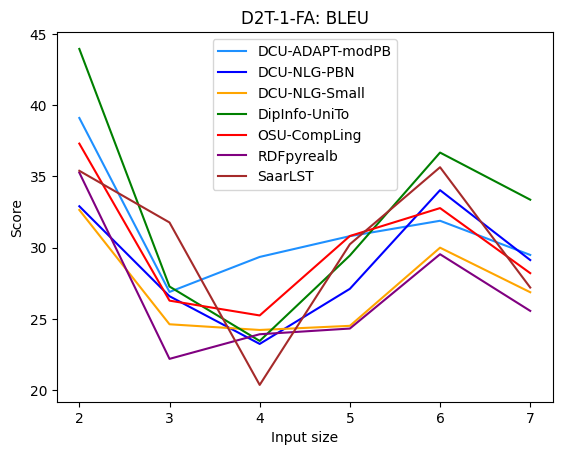

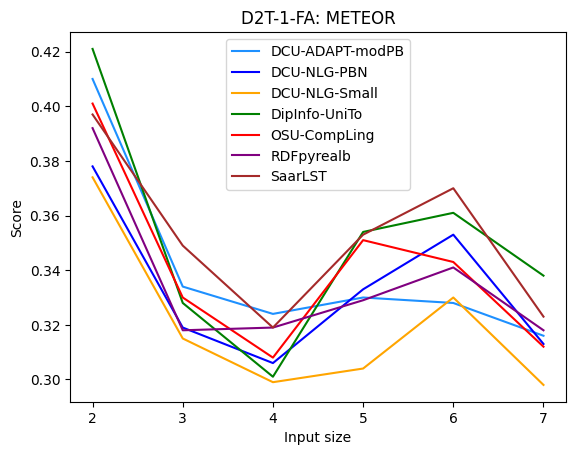

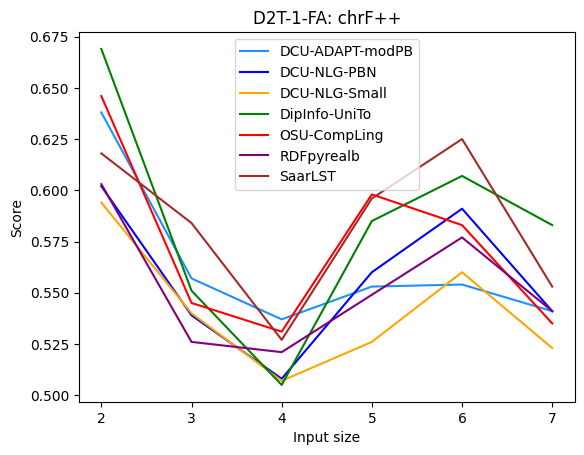

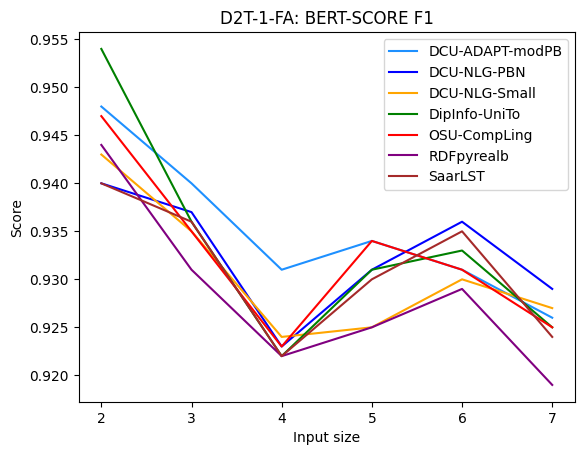

In [2]:
#@title Parse log files and create plots per size
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import re
import shutil

# First upload the log_eval.zip file (for 1 dataset) obtained with this notebook: https://github.com/mille-s/WebNLG-2020_Metrics

dataset = 'D2T-1-FA' #@param['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
# Unzip log_eval folder
# For when we zip the folders inside the content folder
path_logEval = '/content/content/log_eval'
path_zip = '/content/log_eval_'+dataset+'.zip'
if os.path.exists(path_logEval):
  shutil.rmtree(path_logEval)
  ! unzip {path_zip}
else:
  ! unzip {path_zip}

# dataset = 'D2T-1-FA'#@param['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
metrics = ['BLEU', 'METEOR', 'chrF++', 'BERT-SCORE F1']
system_IDnames_dico = {'1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST', '8':'DCU-NLG-Small-noT5', '9':'DCU-NLG-PBN-2nd'}

# dico_plot_BLEU = {}
# dico_plot_METEOR = {}
# dico_plot_chrF = {}
# dico_plot_BERT = {}
dico_plot_per_size = {}
dico_plot_all_sizes = {}
eval_files_paths = glob.glob(os.path.join(path_logEval, '*.txt'))
for eval_file_path in sorted(eval_files_paths):
  head, tail = os.path.split(eval_file_path)
  # values for "size": 2 to 7, and "s" for all sizes
  size = tail.rsplit('_', 1)[1].rsplit('.', 1)[0].split('Size')[1]
  sys_id = tail.rsplit('_', 1)[0].rsplit('_', 1)[1]
  dataset = tail.rsplit('_', 3)[0].rsplit('_', 1)[1]
  # print(f'{sys_id}  {size}')

  # Make a key in dico_plot with a new system id
  # if sys_id not in dico_plot_BLEU:
  #   dico_plot_BLEU[sys_id] = []
  # if sys_id not in dico_plot_METEOR:
  #   dico_plot_METEOR[sys_id] = []
  # if sys_id not in dico_plot_chrF:
  #   dico_plot_chrF[sys_id] = []
  # if sys_id not in dico_plot_BERT:
  #   dico_plot_BERT[sys_id] = []

  # The scores are on the penultimate line of the log file, the metrics names 2 lines above
  log_lines_metrics = [line.rstrip('\n') for line in open(eval_file_path)][-3]
  log_lines_scores = [line.rstrip('\n') for line in open(eval_file_path)][-1]
  # Split lines with names and scores
  # Metrics are separated by 4 spaces, with 2 initial spaces; some metrics have a space inside the name
  metrics_list = [x for x in log_lines_metrics.split('  ') if not x == '']
  # Scores are separated by an unknown number of spaces that depends on the metric name (to show metrics and scores aligned)
  scores_list = [x for x in log_lines_scores.split(' ') if not x == '']
  # Get the pairs metric/score for the metrics we are interested in
  for metric_name, score in zip(metrics_list, scores_list):
    if metric_name in metrics:
      # print(f'{metric_name}: {score}')
      if not size == 's':
        if metric_name not in dico_plot_per_size:
          dico_plot_per_size[metric_name] = {}
        if sys_id not in dico_plot_per_size[metric_name]:
          dico_plot_per_size[metric_name][sys_id] = []
        dico_plot_per_size[metric_name][sys_id].append(float(score))
      else:
        # print(f'{sys_id} AllSizes')
        # print(f'{metric_name}: {score}')
        if sys_id not in dico_plot_all_sizes:
          dico_plot_all_sizes[sys_id] = []
        dico_plot_all_sizes[sys_id].append(float(score))
  # print(metrics_list)
  # print(scores_list)


# Print the lines to put in a latex table
print(f'\nResults all sizes (order: BLEU, METEOR, chrF++, BERT-SCORE F1):')
print(dico_plot_all_sizes)
for sys_id in dico_plot_all_sizes:
  print(system_IDnames_dico[sys_id]+' & '+' & '.join([str(x) for x in dico_plot_all_sizes[sys_id]])+' \\\\')

print(f'\nResults per size:')
print(dico_plot_per_size)

system_colors = {'1':'dodgerblue', '2':'blue', '3':'orange', '4':'green', '5':'red', '6':'purple', '7':'brown', '8':'purple', '9':'purple'}
# Make and save plots in png
for metric_name in dico_plot_per_size:
  for sys_id in dico_plot_per_size[metric_name]:
    plt.plot(range(2, len(dico_plot_per_size[metric_name][sys_id]) + 2), dico_plot_per_size[metric_name][sys_id], label=system_IDnames_dico[sys_id], color=system_colors[sys_id])
  plt.title(f'{dataset}: {metric_name}')
  plt.xlabel("Input size")
  plt.ylabel("Score")
  plt.legend()
  #https://blog.timodenk.com/exporting-matplotlib-plots-to-latex/
  # I can't generate the plots inside latex
  # plt.savefig(f'{dataset}_{metric_name}.pgf')
  # Save the plot as a png file
  plt.savefig(f'{dataset}_{metric_name}.png')
  # plt.show needs to be after savefig, otherwise the image is blank
  plt.show()



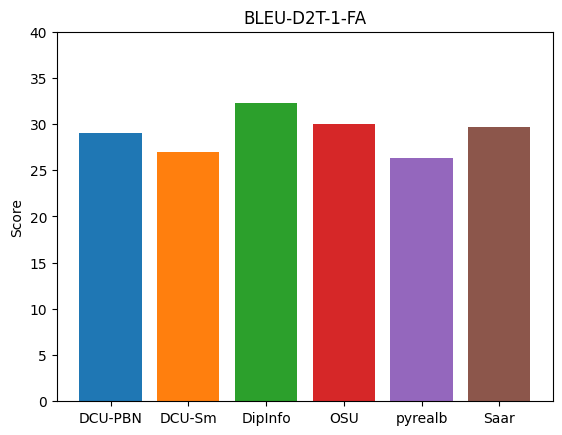

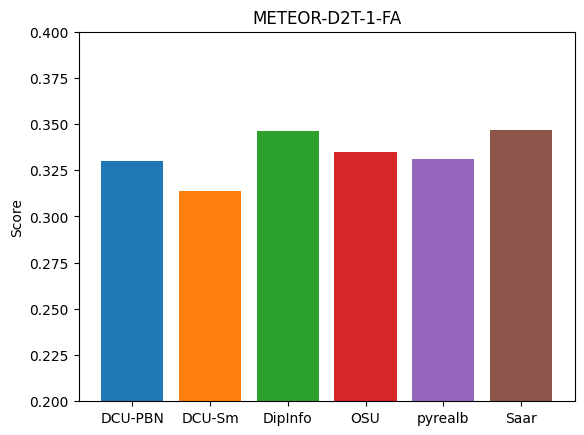

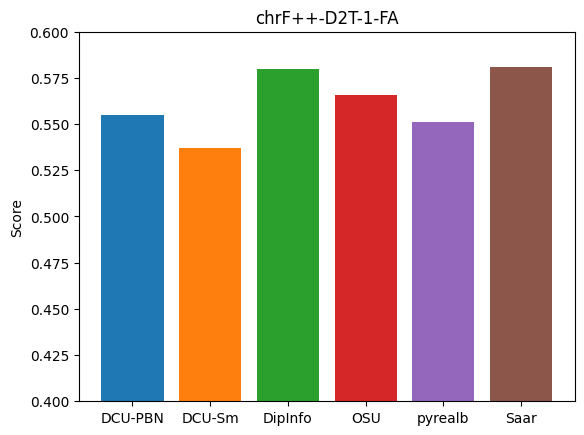

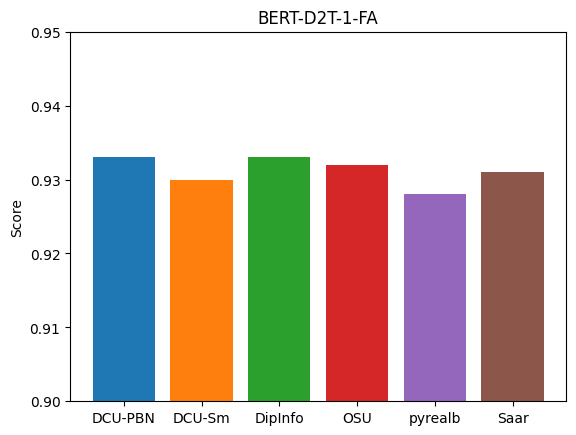

In [3]:
#@title Parse log files and create plots for all sizes

import matplotlib.pyplot as plt

# Metrics order in dico_plot_all_sizes: BLEU, METEOR, chrF++, BERT-SCORE F1
metrics_order = ['BLEU', 'METEOR', 'chrF++', 'BERT']
metrics_lower_limit = [0, 0.2, 0.4, 0.9]
metrics_upper_limit = [40, 0.4, 0.6, 0.95]
system_IDShortnames_dico = {'2':'DCU-PBN', '3':'DCU-Sm', '4':'DipInfo', '5':'OSU', '6':'pyrealb', '7':'Saar', '8':'DCU-Sm-noT5', '9':'DCU-PBN-2nd'}
teams = [system_IDShortnames_dico[x] for x in dico_plot_all_sizes.keys() if not x == '1']

for metric_id in range(4):
  fig, ax = plt.subplots()
  bar_labels = teams
  bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
  scores = [dico_plot_all_sizes[x][metric_id] for x in dico_plot_all_sizes.keys() if not x == '1']
  ax.bar(teams, scores, label=bar_labels, color=bar_colors)
  plt.ylim(metrics_lower_limit[metric_id], metrics_upper_limit[metric_id])
  ax.set_ylabel('Score')
  ax.set_title(metrics_order[metric_id]+'-'+dataset)
  # ax.legend(title='Teams')
  plt.savefig(f'{dataset}_{metrics_order[metric_id]}_allSys.png')
  plt.show()

  # Also create a Latex table for the paper



In [4]:
#@title Calculate D2T score differences for each system on the different datasets

system_IDShortnames = ['DCU-PBN', 'DCU-Sm', 'DipInfo', 'OSU', 'pyrealb', 'Saar']
#BLEU (Systems 2 to 7): one list of 6 scores per system (scores: 1-FA, 1-CFA, 1-FI, 2-FA, 2-CFA, 2-FI)
bleuScores = [[29.08, 25.2, 26.02, 23.96, 30.34, 20.46], [27.0, 22.98, 20.85, 19.48, 24.9, 16.88], [32.31, 29.01, 28.24, 27.22, 32.01, 21.26], [30.03, 24.45, 21.44, 24.97, 27.06, 16.9], [26.37, 21.67, 21.97, 19.97, 25.05, 16.28], [29.7, 23.48, 20.76, 28.25, 26.47, 20.16]]
#METEOR (Systems 2 to 7): one list of 6 scores per system (scores: 1-FA, 1-CFA, 1-FI, 2-FA, 2-CFA, 2-FI)
meteorScores = [[0.33, 0.297, 0.322, 0.295, 0.348, 0.3], [0.314, 0.279, 0.292, 0.26, 0.3, 0.267], [0.346, 0.315, 0.342, 0.304, 0.354, 0.307], [0.335, 0.293, 0.306, 0.295, 0.334, 0.282], [0.331, 0.291, 0.31, 0.287, 0.335, 0.286], [0.347, 0.307, 0.331, 0.32, 0.359, 0.315]]
#CHRF (Systems 2 to 7): one list of 6 scores per system (scores: 1-FA, 1-CFA, 1-FI, 2-FA, 2-CFA, 2-FI)
chrfScores = [[0.555, 0.513, 0.549, 0.49, 0.581, 0.49], [0.537, 0.488, 0.507, 0.438, 0.51, 0.442], [0.58, 0.543, 0.587, 0.512, 0.592, 0.502], [0.566, 0.514, 0.537, 0.496, 0.567, 0.475], [0.551, 0.495, 0.527, 0.479, 0.561, 0.472], [0.581, 0.524, 0.557, 0.538, 0.597, 0.518]]
#BERT (Systems 2 to 7): one list of 6 scores per system (scores: 1-FA, 1-CFA, 1-FI, 2-FA, 2-CFA, 2-FI)
bertScores = [[0.933, 0.923, 0.92, 0.936, 0.937, 0.924], [0.93, 0.918, 0.914, 0.925, 0.923, 0.914], [0.933, 0.926, 0.924, 0.937, 0.936, 0.923], [0.932, 0.92, 0.915, 0.934, 0.93, 0.917], [0.928, 0.918, 0.917, 0.921, 0.923, 0.916], [0.931, 0.921, 0.917, 0.934, 0.929, 0.919]]

def calculateDiffs(list_scores, system_IDShortnames, metric):
  print(metric)
  for pos, systemScores in enumerate(list_scores):
    system_name = system_IDShortnames[pos]
    if system_name == 'DCU-Sm':
      print(f'  {system_name}')
      print(f'    1 FA to CFA: {round(systemScores[1]-systemScores[0], 2)}')
      print(f'    1 FA to FI: {round(systemScores[2]-systemScores[0], 2)}')
      print(f'    ------')
      print(f'    2 FA to CFA: {round(systemScores[4]-systemScores[3], 2)}')
      print(f'    2 FA to FI: {round(systemScores[5]-systemScores[3], 2)}')
      print(f'    ------')
      print(f'    FA 1 to 2: {round(systemScores[3]-systemScores[0], 2)}')
      print(f'    CFA 1 to 2: {round(systemScores[4]-systemScores[1], 2)}')
      print(f'    FI 1 to 2: {round(systemScores[5]-systemScores[2], 2)}')

calculateDiffs(bleuScores, system_IDShortnames, 'BLEU')
calculateDiffs(meteorScores, system_IDShortnames, 'METEOR')
calculateDiffs(chrfScores, system_IDShortnames, 'chrF++')
calculateDiffs(bertScores, system_IDShortnames, 'BERT')

BLEU
  DCU-Sm
    1 FA to CFA: -4.02
    1 FA to FI: -6.15
    ------
    2 FA to CFA: 5.42
    2 FA to FI: -2.6
    ------
    FA 1 to 2: -7.52
    CFA 1 to 2: 1.92
    FI 1 to 2: -3.97
METEOR
  DCU-Sm
    1 FA to CFA: -0.03
    1 FA to FI: -0.02
    ------
    2 FA to CFA: 0.04
    2 FA to FI: 0.01
    ------
    FA 1 to 2: -0.05
    CFA 1 to 2: 0.02
    FI 1 to 2: -0.02
chrF++
  DCU-Sm
    1 FA to CFA: -0.05
    1 FA to FI: -0.03
    ------
    2 FA to CFA: 0.07
    2 FA to FI: 0.0
    ------
    FA 1 to 2: -0.1
    CFA 1 to 2: 0.02
    FI 1 to 2: -0.07
BERT
  DCU-Sm
    1 FA to CFA: -0.01
    1 FA to FI: -0.02
    ------
    2 FA to CFA: -0.0
    2 FA to FI: -0.01
    ------
    FA 1 to 2: -0.01
    CFA 1 to 2: 0.01
    FI 1 to 2: 0.0


In [5]:
import os

FORGe_input_folder = '/content/wiki-gen-demo/FORGe/DCU_TCD_FORGe_WebNLG23/code'


print(FORGe_input_folder.rsplit('/', 1)[0])
print(os.path.split(FORGe_input_folder))

/content/wiki-gen-demo/FORGe/DCU_TCD_FORGe_WebNLG23
('/content/wiki-gen-demo/FORGe/DCU_TCD_FORGe_WebNLG23', 'code')


# 7 - Qualitative evaluation

Choose eval_method and run all cells in this group.
This group creates csv files with the following system-level scores for each language (en, es, sw) for each of the 6 D2T subtasks (180 input/output pairs each):

With eval_method == 'LLM':

(1) Scores of each of the 4 indivual LLMs (1 rating per LLM per input/output pair): /content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv.

(2) Average scores of the 4 LLMs (4 ratings per input/output pair): /content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv.

With eval_method == 'Human':

(3) Average human scores (2 human ratings per input/output pair): /content/csv_sysLevel_scores/sysLevel_scores_Humans.csv.

For both it also creates files with 180 scores for each language\*dataset\*system\*evaluator combination, where "evaluator" is either "human" (averaging the ratings for each data point) or one of the LLMs: /content/csv_for_correls/

In [20]:
#@title Download human eval and LLM-as-judge eval raw files
# o3, 4o, Gemini
! gdown 1DwHd-rjsFxaza3Q8mCI3PBMdA_0luCry
# DeepSeek
! gdown 10-jA_TquoHrpsn6TerlBmUNQLs5Rr2gz
# Human
! gdown 1fBCYOdv0eQ7Xb-13bHY0XyQKXwayP2nh

Downloading...
From: https://drive.google.com/uc?id=1DwHd-rjsFxaza3Q8mCI3PBMdA_0luCry
To: /content/LLM-eval_final_jsons.zip
100% 236k/236k [00:00<00:00, 10.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10-jA_TquoHrpsn6TerlBmUNQLs5Rr2gz
From (redirected): https://drive.google.com/uc?id=10-jA_TquoHrpsn6TerlBmUNQLs5Rr2gz&confirm=t&uuid=132208bc-11d4-4bb8-b342-b6ddae1a014a
To: /content/r1_llama_70b_en-es-sw.zip
100% 23.6M/23.6M [00:00<00:00, 25.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fBCYOdv0eQ7Xb-13bHY0XyQKXwayP2nh
To: /content/all_human_annotations.zip
100% 1.22M/1.22M [00:00<00:00, 58.3MB/s]


In [30]:
#@title Prepare repo (before running, upload zip with jsons that contain evaluations)
from IPython.display import clear_output
import os

eval_method = 'LLM'#@param['LLM', 'Human']

if eval_method == 'LLM':
  # Unzip evaluations from Gemini and GPT
  if not os.path.exists('/content/LLM-eval_final_jsons'):
    assert os.path.exists('/content/LLM-eval_final_jsons.zip'), 'You need to upload LLM-eval_final_jsons.zip'
    ! unzip /content/LLM-eval_final_jsons.zip

  # Unzip evaluations from DeepSeek
  if not os.path.exists('/content/r1_llama_70b_en-es-sw'):
    assert os.path.exists('r1_llama_70b_en-es-sw.zip'), 'You need to upload r1_llama_70b_en-es-sw.zip'
    ! unzip r1_llama_70b_en-es-sw.zip

elif eval_method == 'Human':
  # Unzip evaluations from DeepSeek
  if not os.path.exists('/content/human-eval_final_jsons'):
    assert os.path.exists('all_human_annotations.zip'), 'You need to upload en_all_annotations.zip'
    ! unzip all_human_annotations.zip -d /content/human-eval_final_jsons

clear_output()

## Compute scores

In [31]:
#@title Format DeepSeek outputs and save jsons in LLM-eval_final_jsons folder
# DeepSeek outputs came out with a slightly different format from the Gemini and GPT outputs.

import glob
import json

# If no score is found for a datapoint, ignore it ('no') or assisng a default score (between 1 and 7)
assign_default_score = 'no'#@param['no', '1', '2', '3', '4', '5', '6', '7']

if eval_method == 'LLM':
  llama_jsons = glob.glob(os.path.join('/content/r1_llama_70b_en-es-sw', '*.json'))

  languages = ['en', 'es', 'sw']
  allowed_scores = [1, 2, 3, 4, 5, 6, 7]
  criteria = {'No-Omissions':'no-omissions', 'No-Additions':'no-additions', 'Grammaticality':'grammaticality', 'Fluency':'fluency'}

  counter_all_datapoints = 0
  for language in languages:
    print(f'\n{language}\n--------')
    list_dico_new_json = []
    counter_lng_datapoints = 0
    for llama_json in llama_jsons:
      dico_new_json = {}
      data_r1 = ''
      with open(llama_json, 'r') as f:
        data_r1 = json.load(f)
      # print(data_r1['id'])
      language_json = data_r1['id'].split('_', 1)[0]
      if language_json == language:
        dico_new_json['eid'] = data_r1['id']
        dico_new_json['annotator_id'] = 'R1-Llama-70B'

        # Check data
        if data_r1['parsed_response']:
          for criterion in sorted(criteria.keys(), reverse=True):
            if data_r1['parsed_response'][criterion]['Score']:
              if int(data_r1['parsed_response'][criterion]['Score']) in allowed_scores:
                key_name = criteria[criterion]
                dico_new_json[key_name] = int(data_r1['parsed_response'][criterion]['Score'])
              else:
                # This does not happen in the data
                print(f'{data_r1["id"]} - Criterion score out of range: {criterion}')
            else:
              # This does not happen either in the data
              print(f'{data_r1["id"]} - Criterion score missing: {criterion}')
          counter_lng_datapoints += 1
          # Add eval point to the main dico
          list_dico_new_json.append(dico_new_json)
        else:
          # We have 11 cases of no answer from the model. Excluding data points for now.
          print('  Missing scores for', data_r1['id'], ':', data_r1['parsed_response'])
          if not assign_default_score == 'no':
            for criterion in sorted(criteria.keys(), reverse=True):
              # Assign median score for missing evals
              key_name = criteria[criterion]
              dico_new_json[key_name] = int(assign_default_score)
              print(f'    Assigned {assign_default_score} for {criterion}')
            list_dico_new_json.append(dico_new_json)

    counter_all_datapoints += counter_lng_datapoints
    print(f'Language {language}: {counter_lng_datapoints} data points')

    # Save list_dico_new_json in a json file
    with open(f'/content/LLM-eval_final_jsons/{language.upper()}_R1-Llama-70B_scores.json', 'w') as f:
      json.dump(list_dico_new_json, f, indent=4)

    print(f'All datapoints: {counter_all_datapoints}')


en
--------
  Missing scores for en_D2T-2-FI_0408_7 : None
  Missing scores for en_D2T-2-FI_1383_4 : None
  Missing scores for en_D2T-2-FI_0271_3 : None
Language en: 8277 data points
All datapoints: 8277

es
--------
Language es: 3240 data points
All datapoints: 11517

sw
--------
  Missing scores for sw_D2T-2-FA_0017_3 : None
  Missing scores for sw_D2T-2-CFA_0046_3 : None
  Missing scores for sw_D2T-2-FA_0682_2 : None
  Missing scores for sw_D2T-2-FA_0017_2 : None
  Missing scores for sw_D2T-2-FA_0672_2 : None
  Missing scores for sw_D2T-1-CFA_0471_1 : None
  Missing scores for sw_D2T-1-FI_1497_1 : None
  Missing scores for sw_D2T-2-CFA_1061_3 : None
Language sw: 2692 data points
All datapoints: 14209


In [32]:
#@title Calculate system_level scores D2T assigned by each LLM or by the set of human annotators and create CSVs

import json
import glob
import os
import math
import pandas as pd

csv_sys_level_scores = '/content/csv_sysLevel_scores'
if not os.path.exists(csv_sys_level_scores):
  os.makedirs(csv_sys_level_scores)

pd.set_option('display.max_rows', 10)
allowed_scores = [1, 2, 3, 4, 5, 6, 7]
# Use this dictionary to map values to other values
score_map = {0:0}

def check_scores(score_list, allowed_scores):
  new_score_list = []
  for score in score_list:
    if score in score_map:
      score = score_map[score]
    assert score in allowed_scores, f'Score out of range: {score}'
    new_score_list.append(score)
  return pd.Series(new_score_list)

assert_GEM_data = True#@param{type:'boolean'}
DEBUG = False#@param{type:'boolean'}

json_files = ''
if eval_method == 'LLM':
  # Load the files one at a time; there is one file per LLM-language combination (4*3 = 12 files in total)
  json_folder = '/content/LLM-eval_final_jsons'
  json_files = glob.glob(os.path.join(json_folder, '*.json'))

elif eval_method == 'Human':
  # Load the files one at a time; there is one file per language (since human annotators did not each do all annotations, unlike LLMs)
  json_folder = '/content/human-eval_final_jsons'
  json_files = glob.glob(os.path.join(json_folder, '*.json'))

pd_list = [pd.read_json(json_file) for json_file in sorted(json_files)]

# Create dataframes to store system-level scores
sysLevel_scores_perLLM = pd.DataFrame(columns=['language', 'task', 'system', eval_method, 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])
sysLevel_scores_Humans = pd.DataFrame(columns=['language', 'task', 'system', eval_method, 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])

system_task_counter = 0
for df in pd_list:
  if DEBUG:
    print(df)
  # LLM and Human files use different IDs (eid VS id)
  if eval_method == 'LLM':
    # split eid column using underscores and create corresponding columns in the dataframe
    df[['language', 'task', 'id', 'system']] = df['eid'].str.split('_', expand=True)
  elif eval_method == 'Human':
    # split id column using underscores and create corresponding columns in the dataframe
    df[['language', 'task', 'id', 'system']] = df['id'].str.split('_', expand=True)

  # Convert 'task' and 'system' columns to string to avoid TypeError during sorting
  df['task'] = df['task'].astype(str)
  df['system'] = df['system'].astype(str)

  if eval_method == 'LLM':
    print('Getting scores for', df['annotator_id'][0], df['language'][0], '...')
  elif eval_method == 'Human':
    print('Getting human scores for', df['language'][0])

  # Get all possible values for task and system column
  unique_tasks = sorted(df['task'].unique())
  unique_systems = sorted(df['system'].unique())
  print('', unique_tasks)
  print('', unique_systems)

  # Get the average scores for each system for each task
  for task in unique_tasks:
    if DEBUG:
      print(f'Task: {task}\n===========')
    for system in unique_systems:
      if DEBUG:
        print(f'\nSystem: {system}')
      # get scores in each of the 4 score columns
      no_omissions_scores = df.loc[(df['task'] == task) & (df['system'] == system), 'no-omissions']
      no_omissions_scores = check_scores(no_omissions_scores, allowed_scores)
      no_additions_scores = ''
      # LLM and human files have different criterion names (hyphen VS underscore)
      if eval_method == 'LLM':
        no_additions_scores = df.loc[(df['task'] == task) & (df['system'] == system), 'no-additions']
      elif eval_method == 'Human':
        no_additions_scores = df.loc[(df['task'] == task) & (df['system'] == system), 'no_additions']
      no_additions_scores = check_scores(no_additions_scores, allowed_scores)
      grammaticality_scores = df.loc[(df['task'] == task) & (df['system'] == system), 'grammaticality']
      grammaticality_scores = check_scores(grammaticality_scores, allowed_scores)
      fluency_scores = df.loc[(df['task'] == task) & (df['system'] == system), 'fluency']
      fluency_scores = check_scores(fluency_scores, allowed_scores)
      #Get average scores
      average_no_omissions_score = no_omissions_scores.mean()
      average_no_additions_score = no_additions_scores.mean()
      average_grammaticality_score = grammaticality_scores.mean()
      average_fluency_score = fluency_scores.mean()
      if DEBUG:
        if len(no_omissions_scores) > 0:
          print(f'  Average no-omissions score: {average_no_omissions_score}')
          print(f'  Average no-additions score: {average_no_additions_score}')
          print(f'  Average grammaticality score: {average_grammaticality_score}')
          print(f'  Average fluency score: {average_fluency_score}')

      # If there are no numbers to average, "mean" returns a float that prints 'nan'. Filter out these cases.
      if not math.isnan(average_fluency_score):

        if eval_method == 'LLM':
          # There are scores missing for DeepSeek
          if not df['annotator_id'][0] == 'R1-Llama-70B':
            if assert_GEM_data:
              assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 180, 'There should be 180 ratings for each criterion!'
          else:
            if assert_GEM_data:
              if no_omissions_scores.count() == 180:
                assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 180, 'There should be 180 ratings for each criterion!'
            else:
              print(f"  Less than 180 scores found: {df['language'][0]}-{task}-{system}", no_omissions_scores.count(), no_additions_scores.count(), grammaticality_scores.count(), fluency_scores.count())
          # Add a row to sysLevel_scores_perLLM dataframe
          sysLevel_scores_perLLM.loc[system_task_counter] = [df['language'][0], task, system, df['annotator_id'][0], average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
        elif eval_method == 'Human':
          assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() , 'There should be the same number of ratings for each criterion!'
          if not no_omissions_scores.count() >= 388:
            # There should be 2 annotators per datapoint (2*180) + several datapoints with additional annotators for IAA (apparently at least 30 additional scores in EN, 28 in ES)
            print('??? ERROR??? Less than 388 scores:', df['language'][0], task, system, '|| Found', str(no_omissions_scores.count()))
          # print(f'Number of no-omissions scores: {no_omissions_scores.count()}')
          # print(f'Number of no-additions scores: {no_additions_scores.count()}')
          # print(f'Number of grammaticality scores: {grammaticality_scores.count()}')
          # print(f'Number of fluency scores: {fluency_scores.count()}')
          # Add row to sysLevel_scores_Humans dataframe
          sysLevel_scores_Humans.loc[system_task_counter] = [df['language'][0], task, system, eval_method, average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]

        system_task_counter += 1

print()
# At this point, all submissions, including the withdrawn one, were evaluated
# EN = 46 rows: 7 systems * 6 datasets + 1 system * 3 datasets + human *1 dataset
# ES = 18 rows: 3 systems * 6 datasets
# SW = 15 rows: 2 systems * 6 datasets + 1 system * 3 datasets
# All languages = 79 rows; 4 LLMS-> 316 rows
if eval_method == 'LLM':
  if assert_GEM_data:
    assert len(sysLevel_scores_perLLM) == 316, 'There should be 316 rows (EN, ES, SW) with scores with the 4 LLMs!'
    print('Number of rows OK (316).')
  print(sysLevel_scores_perLLM)
  # Dump dataframe in a CSV file
  sysLevel_scores_perLLM.to_csv(os.path.join(csv_sys_level_scores, 'sysLevel_scores_perLLM.csv'), index=False)
elif eval_method == 'Human':
  assert len(sysLevel_scores_Humans) == 64, 'There should be 64 rows (EN+ES) with scores for the human evals!'
  print('Number of rows OK (64).')
  print(sysLevel_scores_Humans)
  # Dump dataframe in a CSV file
  sysLevel_scores_Humans.to_csv(os.path.join(csv_sys_level_scores, 'sysLevel_scores_Humans.csv'), index=False)

Getting scores for GPT-4o-mini en ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Getting scores for GPT-o3-mini en ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Getting scores for Gemini-1dot5-flash en ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Getting scores for R1-Llama-70B en ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Getting scores for GPT-4o-mini es ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['2', '3', '5']
Getting scores for GPT-o3-mini es ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D2T-2-CFA', 'D2T-2-FA', 'D2T-2-FI']
 ['2', '3', '5']
Getting scores for Gemini-1dot5-flash es ...
 ['D2T-1-CFA', 'D2T-1-FA', 'D2T-1-FI', 'D

In [33]:
#@title Get average (across LLMs) system-level scores D2T and create CSV
# There are 4 LLMs which gave evaluations for all datapoints; we need this extra cell for LLMs to get an average LLM score for each system

DEBUG = False#@param{type:'boolean'}

if eval_method == 'LLM':
  # Create dataframe to store average LLM-assigned system-level scores
  avg_sysLevel_scores_LLMs = pd.DataFrame(columns=['language', 'task', 'system', 'LLM', 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])

  # Now add a row that averages all LLM scores for each system for each task
  unique_languages = sorted(sysLevel_scores_perLLM['language'].unique())
  unique_tasks_avg = sorted(sysLevel_scores_perLLM['task'].unique())
  unique_systems_avg = sorted(sysLevel_scores_perLLM['system'].unique())

  # print(unique_languages)
  # print(unique_tasks_avg)
  # print(unique_systems_avg)

  language_system_task_counter = 0
  for language in unique_languages:
    if DEBUG:
      print(f'Language: {language}')
    for task in unique_tasks_avg:
      if DEBUG:
        print(f'Task: {task}')
      for system in unique_systems_avg:
        if DEBUG:
          print(f'System: {system}')
        # Get the average scores for each system for each task
        no_omissions_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system), 'avg_no-omissions']
        no_additions_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system), 'avg_no-additions']
        grammaticality_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system), 'avg_grammaticality']
        fluency_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system), 'avg_fluency']
        # Get average
        average_no_omissions_score = no_omissions_scores.mean()
        average_no_additions_score = no_additions_scores.mean()
        average_grammaticality_score = grammaticality_scores.mean()
        average_fluency_score = fluency_scores.mean()
        if DEBUG:
          if len(no_omissions_scores) > 0:
            print(f'  Average no-omissions score: {average_no_omissions_score}')
            print(f'  Average no-additions score: {average_no_additions_score}')
            print(f'  Average grammaticality score: {average_grammaticality_score}')
            print(f'  Average fluency score: {average_fluency_score}')

        # If there are no numbers to average, "mean" returns a float that prints 'nan'. Filter out these cases.
        if not math.isnan(average_fluency_score):
          if assert_GEM_data:
            assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 4, 'There should be 4 ratings for each criterion!'
          # Add a row to avg_scores dataframe
          avg_sysLevel_scores_LLMs.loc[language_system_task_counter] = [language, task, system, 'Average_LLM', average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
          language_system_task_counter += 1
          # Dump dataframe in a CSV file
          avg_sysLevel_scores_LLMs.to_csv(os.path.join(csv_sys_level_scores, 'sysLevel_scores_avgLLM.csv'), index=False)

  pd.set_option('display.max_rows', None)
  print()
  if assert_GEM_data:
    assert len(avg_sysLevel_scores_LLMs) == 79, 'There should be 79 rows with scores!'
  print(avg_sysLevel_scores_LLMs)


   language       task system          LLM  avg_no-omissions  \
0        en  D2T-1-CFA      1  Average_LLM          6.190278   
1        en  D2T-1-CFA      2  Average_LLM          6.380556   
2        en  D2T-1-CFA      3  Average_LLM          5.602778   
3        en  D2T-1-CFA      4  Average_LLM          6.475000   
4        en  D2T-1-CFA      5  Average_LLM          6.129167   
5        en  D2T-1-CFA      6  Average_LLM          6.762500   
6        en  D2T-1-CFA      7  Average_LLM          6.654167   
7        en  D2T-1-CFA      8  Average_LLM          2.823611   
8        en   D2T-1-FA      0  Average_LLM          6.675000   
9        en   D2T-1-FA      1  Average_LLM          6.136111   
10       en   D2T-1-FA      2  Average_LLM          6.579167   
11       en   D2T-1-FA      3  Average_LLM          6.008333   
12       en   D2T-1-FA      4  Average_LLM          6.506944   
13       en   D2T-1-FA      5  Average_LLM          6.320833   
14       en   D2T-1-FA      6  Average_

In [34]:
#@title Create one file with all scores for each language+task+system+evaluator combination
#These are the files for calculating correlations

import json
import glob
import os
import pandas as pd

if os.path.exists('/content/csv_for_correls.zip'):
  ! rm -rf /content/csv_for_correls.zip

if not os.path.exists('/content/csv_for_correls'):
  os.mkdir('/content/csv_for_correls')

experiment_type = 'GEM'#@param['GEM', 'LongD2T']
DEBUG = False#@param{type:'boolean'}
# List here all systems that have scores from all evaluators (hum+LLMS) on at least one dataset. Exclude withdrawn system (system 8)
if experiment_type == 'GEM':
    system_IDnames_dico = {'en' : {'0':'WebNLG-Human', '1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
elif experiment_type == 'LongD2T':
    system_IDnames_dico = {'en': {'01': 'qwen', '02': 'llama-13b', '03': 'gpt-4.1', '04': 'R1_llama-70b', '05': 'claude', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'},
                        'ga': {'03': 'gpt-4.1', '05': 'claude', '06': 'UCCIX', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
    }

json_files = ''
# LLM and Human files use different IDs (eid VS id)
gram_label = 'grammaticality'
flu_label = 'fluency'
no_om_label = 'no-omissions'
no_add_label = ''
id_label = ''
if eval_method == 'LLM':
  # Load the files one at a time; there is one file per LLM-language combination (4*3 = 12 files in total)
  json_folder = '/content/LLM-eval_final_jsons'
  json_files = glob.glob(os.path.join(json_folder, '*.json'))
  id_label = 'eid'
  no_add_label = 'no-additions'

elif eval_method == 'Human':
  # Load the files one at a time; there is one file per language (since human annotators did not each do all annotations, unlike LLMs)
  json_folder = '/content/human-eval_final_jsons'
  json_files = glob.glob(os.path.join(json_folder, '*.json'))
  id_label = 'id'
  no_add_label = 'no_additions'

pd_list = [pd.read_json(file) for file in sorted(json_files)]

count_systems_no_score = 0
# The beginning of the following is the same as in the cell that calculates system-level scores
for df in pd_list:
  # if DEBUG:
  #   print(df)
  # split eid column using underscores and create corresponding columns in the dataframe
  df[['language', 'task', 'input_id', 'system']] = df[id_label].str.split('_', expand=True)

  unique_languages = sorted(df['language'].unique())
  unique_tasks = sorted(df['task'].unique())
  # id contains the whole info: language, task, input_id, system
  # unique_ids = sorted(df['id'].unique())
  # Exclude withdrawn system
  unique_systems = [x for x in sorted(df['system'].unique()) if x in system_IDnames_dico[df['language'][0]].keys()]
  if DEBUG:
    if eval_method == 'LLM':
      print(df['annotator_id'][0])
    else:
      print('Human')
    print(unique_languages)
    print(unique_tasks)
    print(unique_systems)
  for language in unique_languages:
    if eval_method == 'LLM':
      print(f'Processing {language} {df["annotator_id"][0]}...')
    else:
      print(f'Processing {language} Human...')
    for task in unique_tasks:
      # We need to count unique_inputs at a task level, since in D2T-1 and D2T-2 the sampled inputs are not the same
      unique_input_ids = sorted(df.loc[(df['language'] == language) & (df['task'] == task), 'input_id'].unique())
      print(f'  {task}: # unique input IDs = {len(unique_input_ids)}')
      for system in unique_systems:
        filename = ''
        if eval_method == 'LLM':
          filename = f'{language}_{task}_{system}_{df["annotator_id"][0]}.csv'
        else:
          filename = f'{language}_{task}_{system}_Human.csv'

        # Check if there are results for the combination of language, task and system
        if df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system)].empty:
          if DEBUG:
            print(f'No scores found for {language}-{task}-{system}')
          count_systems_no_score += 1
        else:
          if DEBUG:
            print(f'{language}-{task}-{system} OK')
          # Make a new dataframe with the columns id, no_om_label, no_add_label, gram_label, flu_label and add rows that correspond to language, task and system
          scores_df = pd.DataFrame(columns=['id', 'no-omissions', 'no-additions', gram_label, flu_label, 'num_scores'])
          if eval_method == 'LLM':
            # For LLM evals, we have on file per LLM/language in which there is one rating for each of the 180 datapoints for all datasets and all systems (except for the few missing ratings from R1)
            # Thus we simply need to put select the 180 ratings of one system on one dataset (the language condition below is not needed but left just in case)
            scores_df['id'] = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system), 'input_id']
            scores_df['no-omissions'] = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system), no_om_label]
            scores_df['no-additions'] = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system), no_add_label]
            scores_df[gram_label] = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system), gram_label]
            scores_df[flu_label] = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system), flu_label]
            scores_df['num_scores'] = 1
            # Actually, I'd like the LLM and Human files to be aligned for easier processing, so let's sort the rows
            # I could use the same code as for the human files, but the latter is much slower (I checked, the outputs are the same in both cases)
            scores_df = scores_df.sort_values(by=['id']).reset_index(drop=True)
          else:
            # For human evals, we have one file per language with 2 to n annotation for each of the 180 datapoints for all datasets and all systems.
            # We need to average these 2 to n annotations so as to get 180 scores per dataset per system per language, as for LLMs
            # For each language/task/system, get the 2 to n scores for each input
            for i, input_id in enumerate(unique_input_ids):
              scores_no_om = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system) & (df['input_id'] == input_id), no_om_label]
              scores_no_add = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system) & (df['input_id'] == input_id), no_add_label]
              scores_gram = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system) & (df['input_id'] == input_id), gram_label]
              scores_flu = df.loc[(df['language'] == language) & (df['task'] == task) & (df['system'] == system) & (df['input_id'] == input_id), flu_label]
              scores_df.loc[i] = [input_id, scores_no_om.mean(), scores_no_add.mean(), scores_gram.mean(), scores_flu.mean(), scores_no_om.count()]

          if DEBUG:
            print(scores_df)

          # Save scores_df in csv_for_correls
          scores_df.to_csv(os.path.join('/content/csv_for_correls', filename), index=False)

if eval_method == 'LLM':
  print(f'Number of combinations of language/dataset/system with no score: {str(count_systems_no_score)} (expected: 44)')
else:
  print(f'Number of combinations of language/dataset/system with no score: {str(count_systems_no_score)} (expected: 8)')

Processing en GPT-4o-mini...
  D2T-1-CFA: # unique input IDs = 180
  D2T-1-FA: # unique input IDs = 180
  D2T-1-FI: # unique input IDs = 180
  D2T-2-CFA: # unique input IDs = 180
  D2T-2-FA: # unique input IDs = 180
  D2T-2-FI: # unique input IDs = 180
Processing en GPT-o3-mini...
  D2T-1-CFA: # unique input IDs = 180
  D2T-1-FA: # unique input IDs = 180
  D2T-1-FI: # unique input IDs = 180
  D2T-2-CFA: # unique input IDs = 180
  D2T-2-FA: # unique input IDs = 180
  D2T-2-FI: # unique input IDs = 180
Processing en Gemini-1dot5-flash...
  D2T-1-CFA: # unique input IDs = 180
  D2T-1-FA: # unique input IDs = 180
  D2T-1-FI: # unique input IDs = 180
  D2T-2-CFA: # unique input IDs = 180
  D2T-2-FA: # unique input IDs = 180
  D2T-2-FI: # unique input IDs = 180
Processing en R1-Llama-70B...
  D2T-1-CFA: # unique input IDs = 180
  D2T-1-FA: # unique input IDs = 180
  D2T-1-FI: # unique input IDs = 180
  D2T-2-CFA: # unique input IDs = 180
  D2T-2-FA: # unique input IDs = 180
  D2T-2-FI: # uni

## Zip and download results

In [35]:
#@title Zip and download csv folders
from google.colab import files

! zip -r /content/csv_for_correls.zip /content/csv_for_correls
files.download('/content/csv_for_correls.zip')

! zip -r /content/csv_sysLevel_scores.zip /content/csv_sysLevel_scores
files.download('/content/csv_sysLevel_scores.zip')

  adding: content/csv_for_correls/ (stored 0%)
  adding: content/csv_for_correls/en_D2T-2-FI_7_Human.csv (deflated 78%)
  adding: content/csv_for_correls/sw_D2T-1-FA_3_GPT-o3-mini.csv (deflated 74%)
  adding: content/csv_for_correls/en_D2T-2-FI_3_GPT-o3-mini.csv (deflated 74%)
  adding: content/csv_for_correls/sw_D2T-1-CFA_2_GPT-4o-mini.csv (deflated 78%)
  adding: content/csv_for_correls/en_D2T-2-FI_7_GPT-4o-mini.csv (deflated 81%)
  adding: content/csv_for_correls/es_D2T-1-FA_3_GPT-4o-mini.csv (deflated 75%)
  adding: content/csv_for_correls/en_D2T-2-CFA_2_GPT-4o-mini.csv (deflated 79%)
  adding: content/csv_for_correls/sw_D2T-2-FA_2_Gemini-1dot5-flash.csv (deflated 80%)
  adding: content/csv_for_correls/en_D2T-1-FI_3_R1-Llama-70B.csv (deflated 74%)
  adding: content/csv_for_correls/sw_D2T-1-CFA_2_GPT-o3-mini.csv (deflated 77%)
  adding: content/csv_for_correls/en_D2T-1-FA_5_GPT-o3-mini.csv (deflated 75%)
  adding: content/csv_for_correls/en_D2T-2-FA_3_Gemini-1dot5-flash.csv (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/csv_sysLevel_scores/ (stored 0%)
updating: content/csv_sysLevel_scores/sysLevel_scores_Humans.csv (deflated 74%)
  adding: content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv (deflated 78%)
  adding: content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv (deflated 85%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 8 - Create plots and LaTeX tables from scores aggregated in "Qualitative evaluation" above (follow instructions and run group 7 just above).

In [ ]:
#@title Functions
import numpy as np
import os

fig_path = '/content/figures'

experiment_type = 'GEM'#@param['GEM', 'LongD2T']

def dictionarise_scores_all_datasets(df_scores, name_evaluator_column):
  """
  To get a dico like the following: {'en': {'D2T-1-CFA': {'avg_no-omissions': {'GPT-4o-mini': [None, 6.06, 6.16, 5.37, 6.32, 5.83, 6.44, 6.38, 2.57], 'GPT-o3-mini': [None, 6.13, 6.37, 5.55, 6.46, 6.05, 6.97, 6.77, 2.72], ...} ...} ...} ...}
  For plotting scores of an evaluation method across all systems for each criterion, for each dataset, for each language.
  """
  unique_languages = sorted(df_scores['language'].unique())
  unique_evaluator = sorted(df_scores[name_evaluator_column].unique())
  unique_tasks = sorted(df_scores['task'].unique())
  # unique_systems = sorted(df_scores['system'].unique())
  # The first version of the code assumed that all systems appeared in the evaluation file, which is not the case if one wants to run the code on incomplete results file.#
  # To get the scores later, we match the system ID with a position in a list of scores for all systems: list_scores = [dico_plots[language][task][eval_criterion][LLM][int(x)] for x in sorted(system_IDnames_dico[language].keys())]
  # So by looking for the highest system ID and considering that's the number of systems, we make sure there will be no out of range call to the list of scores
  highest_system_id = max([int(x) for x in df_scores['system'].unique()])
  unique_systems = [x for x in range(highest_system_id + 1)]

  # print(unique_languages)
  # print(unique_evaluator)
  # print(unique_tasks)
  # print(unique_systems)

  # system_IDnames_dico = {'en' : {'0':'WebNLG-Human', '1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
  eval_criteria = ['avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency']

  no_scores_found = []
  counter_row_with_score = 0
  # Let's plot how each LLM rates each system, and make a plot for each language*task*criterion
  dico_plots = {}
  for language in unique_languages:
    if not language in dico_plots:
      dico_plots[language] = {}
    for task in unique_tasks:
      if not ('All' in unique_tasks and not task == 'All'):
        if not task in dico_plots[language]:
          dico_plots[language][task] = {}
        for eval_criterion in eval_criteria:
          if not eval_criterion in dico_plots[language][task]:
            dico_plots[language][task][eval_criterion] = {}
          for evaluator in unique_evaluator:
            if not evaluator in dico_plots[language][task][eval_criterion]:
              dico_plots[language][task][eval_criterion][evaluator] = []
            for system in unique_systems:
              # Filter out withdrawn system
              # if system in system_IDnames_dico[language].keys(): # Actually no, let's filter that later on
              # Check that a system has scores for the task
              if df_scores.loc[(df_scores['language'] == language) & (df_scores['task'] == task) & (df_scores[name_evaluator_column] == evaluator) & (df_scores['system'] == system)].empty:
                if f'{language}-{task}-{system}-{evaluator}-{eval_criterion}' not in no_scores_found:
                  no_scores_found.append(f'{language}-{task}-{system}-{evaluator}-{eval_criterion}')
                dico_plots[language][task][eval_criterion][evaluator].append(None)
              else:
                # Append the score for the system found in the column with the header eval_criterion
                dico_plots[language][task][eval_criterion][evaluator].append(float(round(df_scores.loc[(df_scores['language'] == language) & (df_scores['task'] == task) & (df_scores[name_evaluator_column] == evaluator) & (df_scores['system'] == system), eval_criterion].values[0], 2)))
                counter_row_with_score += 1
  return dico_plots, counter_row_with_score

def plot_dicoPlots_lng_task_criterion_evalMethod_line (dico_plots, fig_path, experiment_type):
  if not os.path.exists(fig_path):
    os.mkdir(fig_path)
  # system_IDnames_dico = {'en' : {'0':'WebNLG-Human', '1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
  # We list here only actually submitted systems (i.e. not system 8, who withdrew) that have all scores on ALL datasets, which excludes WebNLG-Human (only D2T-1-FA) and DCU-ADAPT-modPB (only D2T-1).
  system_IDnames_dico = {}
  if experiment_type == 'GEM':
    system_IDnames_dico = {'en' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
  elif experiment_type == 'LongD2T':
    system_IDnames_dico = {'en': {'01': 'Qwen3-32b', '02': 'Llama2-13b', '03': 'GPT4.1', '04': 'R1-Llama-70b', '05': 'Claude3.7-sonnet', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'},
                        'ga': {'03': 'GPT4.1', '05': 'Claude3.7-sonnet', '06': 'UCCIX', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
    }
  # system_colors = {'0':'dodgerblue', '1':'purple', '2':'blue', '3':'orange', '4':'green', '5':'red', '6':'purple', '7':'brown'}
  # plt.title(f'{language}-{task}: {eval_criterion}')
  # plt.xlabel("System")
  # plt.ylabel("Score")
  # plt.legend()
  for language in dico_plots.keys():
    print(language)
    for task in dico_plots[language].keys():
      print(f'  {task}')
      for eval_criterion in dico_plots[language][task]:
        print(f'    {eval_criterion}')
        for LLM in dico_plots[language][task][eval_criterion]:
          print(f'      {LLM}')
          print(f'        {sorted(system_IDnames_dico[language].keys())}')
          list_scores = [dico_plots[language][task][eval_criterion][LLM][int(x)] for x in sorted(system_IDnames_dico[language].keys())]
          print(f'        {list_scores}')
          # plt.plot(range(1, len(list_scores) + 1), list_scores, label=LLM)
          plt.plot([system_IDnames_dico[language][x] for x in sorted(system_IDnames_dico[language].keys())], list_scores, label=LLM)
        plt.title(f'{language}-{task}: {eval_criterion}')
        if len(system_IDnames_dico[language].keys()) > 4:
          plt.xticks(rotation=15)
        plt.ylim(1, 7)
        plt.xlabel("System")
        plt.ylabel("Score")
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(fig_path, f'{language}-{task}-{eval_criterion}_line.png'))
        plt.show()

def plot_dicoPlots_lng_task_criterion_evalMethod_bars (dico_plots, fig_path, experiment_type):
  if not os.path.exists(fig_path):
    os.mkdir(fig_path)
  system_IDnames_dico = {}
  if experiment_type == 'GEM':
    system_IDnames_dico = {'en' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
  elif experiment_type == 'LongD2T':
    system_IDnames_dico = {'en': {'01': 'Qwen3-32b', '02': 'Llama2-13b', '03': 'GPT4.1', '04': 'R1-Llama-70b', '05': 'Claude3.7-sonnet', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'},
                        'ga': {'03': 'GPT4.1', '05': 'Claude3.7-sonnet', '06': 'UCCIX', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
    }
  for language in dico_plots.keys():
    for task in dico_plots[language].keys():
      for eval_criterion in dico_plots[language][task]:
        # Get list of systems for this language
        systems = [system_IDnames_dico[language][x] for x in sorted(system_IDnames_dico[language].keys())]

        # Get list of scores for each LLM for this language, task, and criterion
        llm_scores = {}
        for LLM in dico_plots[language][task][eval_criterion]:
          llm_scores[LLM] = [dico_plots[language][task][eval_criterion][LLM][int(x)] for x in sorted(system_IDnames_dico[language].keys())]

        # Create bar plot
        bar_width = 0.15  # Adjust as needed
        x_pos = np.arange(len(systems))
        # print(f'XPOS = {x_pos}')

        # Plotting bars for each LLM with offset for readability
        for i, (LLM, scores) in enumerate(llm_scores.items()):
          scores_wo_None = [0 if x==None else x for x in scores]
          # print(f'{x_pos + i * bar_width}, {scores_wo_None}, {bar_width}, {LLM}')
          plt.bar(x_pos + i * bar_width, scores_wo_None, bar_width, label=LLM)

        plt.title(f'{language}-{task}: {eval_criterion}')
        # plt.title(f'{language} - {eval_criterion}')
        plt.xticks(x_pos + bar_width * (len(llm_scores) -1)/2 , systems, rotation=15 if len(systems) > 4 else 0)  # Center x-axis ticks
        plt.ylim(1, 7)
        plt.xlabel("System")
        plt.ylabel("Score")
        plt.legend(loc='lower right')
        # plt.legend(loc='lower center')
        plt.savefig(os.path.join(fig_path, f'{language}-{task}-{eval_criterion}_bar.png'))
        plt.show()

def plot_dicoPlots_lng_task_criterion_evalMethod_dots(dicoPlots, path_out_plots, experiment_type):
  """
  Generates plots for different combinations of language, task, and criterion.

  Args:
    dicoPlots: A dictionary containing scores for different systems, evaluation modes,
               languages, tasks, and criteria.
    path_out_plots: The path to the folder where the plots will be saved.
  """

  # Define markers and colors for the plots
  markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*']
  colors = {'R1-Llama-70B': 'purple', 'Gemini-1dot5-flash': 'green', 'GPT-4o-mini': 'blue', 'GPT-o3-mini': 'orange'}

  # System names dictionary
  system_IDnames_dico = {}
  if experiment_type == 'GEM':
    system_IDnames_dico = {'en': {'2': 'DCU-NLG-PBN', '3': 'DCU-NLG-Small', '4': 'DipInfo-UniTo', '5': 'OSU-CompLing', '6': 'RDFpyrealb', '7': 'SaarLST'},
                        'es': {'2': 'DCU-NLG-PBN', '3': 'DCU-NLG-Small', '5': 'OSU-CompLing'},
                        'sw': {'2': 'DCU-NLG-PBN', '3': 'DCU-NLG-Small'}}
  elif experiment_type == 'LongD2T':
    system_IDnames_dico = {'en': {'01': 'Qwen3-32b', '02': 'Llama2-13b', '03': 'GPT4.1', '04': 'R1-Llama-70b', '05': 'Claude3.7-sonnet', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'},
                        'ga': {'03': 'GPT4.1', '05': 'Claude3.7-sonnet', '06': 'UCCIX', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
    }
  # Iterate over languages, tasks, and criteria
  for language in dicoPlots:
    for task in dicoPlots[language]:
      for criterion in dicoPlots[language][task]:
        # Proceed only if we have human ratings
        if "Human" in dicoPlots[language][task][criterion] and not (len(set(dicoPlots[language][task][criterion]['Human'])) == 1 and None in set(dicoPlots[language][task][criterion]['Human'])):
          # Create a figure and axis object
          fig, ax = plt.subplots()

          human_scores = dicoPlots[language][task][criterion]["Human"]

          # Legend entries for systems (using grey color)
          system_legend_entries = []
          for system_index in sorted(system_IDnames_dico[language].keys()):
            system_name = system_IDnames_dico[language][system_index]
            system_legend_entries.append(ax.scatter([], [], marker=markers[int(system_index)], color='grey', label=system_name))
          # Legend entries for LLMs (using colors from the dictionary)
          llm_legend_entries = []
          for eval_mode in sorted(colors.keys()):
              llm_legend_entries.append(ax.scatter([], [], marker='o', color=colors[eval_mode], label=eval_mode))
          # Combine system and LLM legend entries
          all_legend_entries = system_legend_entries + llm_legend_entries

          # Plot data points (using LLM colors)
          for system_index in sorted(system_IDnames_dico[language].keys()):
            # Get system name using system ID and language
            system_name = system_IDnames_dico[language][system_index]

            for eval_mode in dicoPlots[language][task][criterion]:
              if eval_mode != "Human":
                llm_score = dicoPlots[language][task][criterion][eval_mode][int(system_index)]
                # Update label to use system name and LLM name without "System"
                ax.scatter(llm_score, human_scores[int(system_index)], marker=markers[int(system_index)], color=colors[eval_mode]) #, label=f"{system_name} ({eval_mode})" if int(system_index) == 0 else f"{system_name}")

          ax.set_xlabel("LLM score")
          ax.set_ylabel("Human score")
          ax.set_title(f"{language}-{task}: {criterion}")

          handles, labels = ax.get_legend_handles_labels()
          by_label = dict(zip(labels, handles))
          # ax.legend(by_label.values(), by_label.keys(), loc='best', bbox_to_anchor=(1.05, 1))
          ax.legend(handles=all_legend_entries, loc='upper left', bbox_to_anchor=(0, 1))

          ax.set_xlim([4, 7])
          ax.set_ylim([4, 7])

          filename = os.path.join(path_out_plots, f"{language}-{task}-{criterion}_dots.png")
          plt.savefig(filename, bbox_inches='tight')
          plt.show()
          plt.close(fig)


## Plot scores of each LLM independently, for each criterion, for each dataset

In [ ]:
#@title Organise data into a dico and make plots
import matplotlib.pyplot as plt
import pandas as pd

# assert_GEM_data = False

llm_csv = '/content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv'
assert os.path.exists(llm_csv), 'sysLevel_scores_perLLM.csv file missing! Run cells in 7 above with "LLM" eval_method'
sysLevel_scores_perLLM = pd.read_csv(llm_csv)
if assert_GEM_data:
  assert len(sysLevel_scores_perLLM) == 316, 'There should be 316 rows (EN, ES, SW) with scores with the 4 LLMs!'

dicoPlots_lng_task_criterion_evalMethod, counter_row_with_score = dictionarise_scores_all_datasets(sysLevel_scores_perLLM, 'LLM')
if assert_GEM_data:
  assert counter_row_with_score == 1264, f'There should be 1264 rows with scores (with the 8 systems: 4 criteria * 316 rows - 184-en, 72-es, 60-sw), found {counter_row_with_score}!'
# print(sorted(no_scores_found))
print(f'Dico plots: {dicoPlots_lng_task_criterion_evalMethod}')

plot_dicoPlots_lng_task_criterion_evalMethod_line(dicoPlots_lng_task_criterion_evalMethod, fig_path, experiment_type)
plot_dicoPlots_lng_task_criterion_evalMethod_bars(dicoPlots_lng_task_criterion_evalMethod, fig_path, experiment_type)

## Plot average scores across all datasets of all evaluations independently (4 LLMs and 1 human) for each criterion

In [ ]:
#@title Combine human and LLM eval dataframes and get averages across tasks for each system
import os

hum_csv = '/content/csv_sysLevel_scores/sysLevel_scores_Humans.csv'
llm_csv = '/content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv'
assert os.path.exists(hum_csv), 'sysLevel_scores_Humans.csv file missing! Run cells in 7 above with "Human" eval_method'
assert os.path.exists(llm_csv), 'sysLevel_scores_perLLM.csv file missing! Run cells in 7 above with "LLM" eval_method'

# Load csv files into pandas dataframes
df_hum = pd.read_csv(hum_csv)
assert len(df_hum) == 64, 'There should be 64 rows (EN+ES) with scores for the human evals!'
print('There are 64 rows as expected in the human eval CSV!')
df_llm = pd.read_csv(llm_csv)
assert len(df_llm) == 316, 'There should be 316 rows (EN, ES, SW) with scores with the 4 LLMs!'
print('There are 316 rows as expected in the LLM eval CSV!')
# print(df_hum)
# print(df_llm)

# Combine both dataframes
df_all = pd.DataFrame(columns=['language', 'task', 'system', 'evaluator', 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])
# index is used to store the current index in the dataframe
index = 0
# Put the human eval data first
for index, row in df_hum.iterrows():
  df_all.loc[index] = [row['language'], row['task'], row['system'], row['Human'], row['avg_no-omissions'], row['avg_no-additions'], row['avg_grammaticality'], row['avg_fluency']]
# Then add the llm eval data on the following rows
for _ , row in df_llm.iterrows():
  index = index + 1
  df_all.loc[index] = [row['language'], row['task'], row['system'], row['LLM'], row['avg_no-omissions'], row['avg_no-additions'], row['avg_grammaticality'], row['avg_fluency']]
assert len(df_all) == (len(df_hum) + len(df_llm)), 'Error! The number of rows does not equal the sum of the number of rows in human eval df and llm df.'
# print(df_all)

# Create dataframe to store average LLM-assigned system-level scores
avg_overall_sysLevel_scores_allEvals = pd.DataFrame(columns=['language', 'task', 'system', 'evaluator', 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])

# Get average scores across all tasks
unique_languages = sorted(df_all['language'].unique())
unique_evaluators = sorted(df_all['evaluator'].unique())
unique_systems = sorted([int(system) for system in df_all['system'].unique()])
print(unique_languages)
print(unique_evaluators)
print(unique_systems)

language_system_evaluator_counter = 0
for language in unique_languages:
  for system in unique_systems:
    for evaluator in unique_evaluators:
      # Get average scores across all tasks
      # print(f'{language}-{system}-{evaluator}')
      no_omissions_scores = df_all.loc[(df_all['language'] == language) & (df_all['evaluator'] == evaluator) & (df_all['system'] == system), 'avg_no-omissions']
      no_additions_scores = df_all.loc[(df_all['language'] == language) & (df_all['evaluator'] == evaluator) & (df_all['system'] == system), 'avg_no-additions']
      grammaticality_scores = df_all.loc[(df_all['language'] == language) & (df_all['evaluator'] == evaluator) & (df_all['system'] == system), 'avg_grammaticality']
      fluency_scores = df_all.loc[(df_all['language'] == language) & (df_all['evaluator'] == evaluator) & (df_all['system'] == system), 'avg_fluency']
      average_no_omissions_score = no_omissions_scores.mean()
      average_no_additions_score = no_additions_scores.mean()
      average_grammaticality_score = grammaticality_scores.mean()
      average_fluency_score = fluency_scores.mean()

      # If there are no numbers to average, "mean" returns a float that prints 'nan'. Filter out these cases.
      if not math.isnan(average_fluency_score):
        if system == 0:
          assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 1, 'There should be 1 ratings for each criterion for system 0!'
          avg_overall_sysLevel_scores_allEvals.loc[language_system_evaluator_counter] = [language, 'D2T-1-FA', system, evaluator, average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
        elif system == 1:
          assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 3, 'There should be 3 ratings for each criterion for system 1!'
          avg_overall_sysLevel_scores_allEvals.loc[language_system_evaluator_counter] = [language, 'D2T-1', system, evaluator, average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
        else:
          assert no_omissions_scores.count() == no_additions_scores.count() == grammaticality_scores.count() == fluency_scores.count() == 6, 'There should be 6 ratings for each criterion for systems 2-8!'
          avg_overall_sysLevel_scores_allEvals.loc[language_system_evaluator_counter] = [language, 'All', system, evaluator, average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
        # Add a row to avg_scores dataframe
        language_system_evaluator_counter += 1

pd.set_option('display.max_rows', 10)
print()
print(avg_overall_sysLevel_scores_allEvals)
assert len(avg_overall_sysLevel_scores_allEvals) == 72, 'There should be 75 rows with scores (en=45, es=15, sw=15)! Or 72 without SW-human evals.'
print('There are 72/75 rows as expected in the output dataframe!')

# Now only keep a version of the dataframe with only the "task=All" column. Not sure it's a good idea, breaks the next funciton to be applied because not all systems have values
# avg_overall_sysLevel_scores_allEvals_allTasks = avg_overall_sysLevel_scores_allEvals.loc[avg_overall_sysLevel_scores_allEvals['task'] == 'All']
# print()
# print(avg_overall_sysLevel_scores_allEvals_allTasks)
# assert len(avg_overall_sysLevel_scores_allEvals_allTasks) == 55, 'There should be 60 rows with scores (en=35, es=10, sw=15)! Or 55 without ES and SW human evals.'
# print('There are 55 rows as expected in the output dataframe!')

There are 64 rows as expected in the human eval CSV!
There are 316 rows as expected in the LLM eval CSV!
['en', 'es', 'sw']
['GPT-4o-mini', 'GPT-o3-mini', 'Gemini-1dot5-flash', 'Human', 'R1-Llama-70B']
[0, 1, 2, 3, 4, 5, 6, 7, 8]

   language      task  system           evaluator  avg_no-omissions  \
0        en  D2T-1-FA       0         GPT-4o-mini          6.383333   
1        en  D2T-1-FA       0         GPT-o3-mini          6.650000   
2        en  D2T-1-FA       0  Gemini-1dot5-flash          6.816667   
3        en  D2T-1-FA       0               Human          5.140306   
4        en  D2T-1-FA       0        R1-Llama-70B          6.850000   
..      ...       ...     ...                 ...               ...   
67       sw       All       2        R1-Llama-70B          6.713073   
68       sw       All       3         GPT-4o-mini          5.360185   
69       sw       All       3         GPT-o3-mini          5.319444   
70       sw       All       3  Gemini-1dot5-flash          

In [ ]:
#@title Organise data into a dico and make plots
import matplotlib.pyplot as plt

# Make plots for all tasks separately (just in case we need it)
# dicoPlots_lng_task_criterion_evalMethod_all, counter_row_with_score = dictionarise_scores_all_datasets(df_all, 'evaluator')
# plot_dicoPlots_lng_task_criterion_evalMethod(dicoPlots_lng_task_criterion_evalMethod_all)

# Put all LLM and human system-level evaluations in a dico for plotting
dicoPlots_lng_criterion_evalMethod_all, counter_row_with_score = dictionarise_scores_all_datasets(avg_overall_sysLevel_scores_allEvals, 'evaluator')
print(dicoPlots_lng_criterion_evalMethod_all)

plot_dicoPlots_lng_task_criterion_evalMethod_line(dicoPlots_lng_criterion_evalMethod_all, fig_path, experiment_type)
plot_dicoPlots_lng_task_criterion_evalMethod_bars(dicoPlots_lng_criterion_evalMethod_all, fig_path, experiment_type)
plot_dicoPlots_lng_task_criterion_evalMethod_dots(dicoPlots_lng_criterion_evalMethod_all, fig_path, experiment_type)

In [ ]:
#@title Zip and download figures folder
from google.colab import files
from IPython.display import clear_output

folder_to_zip = '/content/figures'
zip_name_inter = folder_to_zip+'.zip'
# if os.path.exists(folder_to_zip):
#   ! rm zip_name_inter
!zip -r {zip_name_inter} {folder_to_zip}

clear_output()

files.download(zip_name_inter)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Create LaTeX tables

In [ ]:
#@title Create LaTeX table rows with average scores

#Get tables for averaged LLM scores (True), or for each LLM separately (False)
eval_method_4table = 'Human'#@param['Human', 'LLM-avg', 'LLM-each']

def create_LaTeX_table_parts(dico_avg_scores, eval_method, LLM=None):
  unique_languages = sorted(dico_avg_scores['language'].unique())
  # unique_tasks = sorted(avg_avg_scores['task'].unique())
  unique_tasks = ['D2T-1-FA', 'D2T-1-CFA', 'D2T-1-FI', 'D2T-2-FA', 'D2T-2-CFA', 'D2T-2-FI']
  unique_systems = sorted(dico_avg_scores['system'].unique())

  # print(unique_languages)
  print(f'Results printed in the following order of tasks: {unique_tasks}')
  # print(unique_systems)
  system_IDnames_dico = {}
  if experiment_type == 'GEM':
    system_IDnames_dico = {'en' : {'0':'WebNLG-Human', '1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'}, 'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}, 'sw' : {'1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small'}}
  elif experiment_type == 'LongD2T':
    system_IDnames_dico = {'en': {'1': 'qwen', '2': 'llama-13b', '3': 'gpt-4.1', '4': 'R1_llama-70b', '5': 'claude', '7': 'FORGe', '8': 'Hum-1.0', '9': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'},
                        'ga': {'3': 'gpt-4.1', '5': 'claude', '6': 'UCCIX', '7': 'FORGe', '8': 'Hum-1.0', '9': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
    }
  eval_criteria = {'avg_no-omissions':'No-Omissions', 'avg_no-additions':'No-Additions', 'avg_grammaticality':'Grammaticality', 'avg_fluency':'Fluency'}

  # Since the table mixes human and LLM scores, which come from different files, I only print here the LLM scores for each criterion separately, and copy/paste it in the paper by hand (4 copy/paste per language)
  counter_scores = 0
  dico_plots = {}
  for language in unique_languages:
    num_systems_for_lng = len(system_IDnames_dico[language])
    for eval_criterion in eval_criteria.keys():
      if eval_method_4table == 'Human':
        line = '\\multirow{'+str(num_systems_for_lng*2)+'}{*}{\\textbf{'+eval_criteria[eval_criterion]+'}} & \\multirow{'+str(num_systems_for_lng)+'}{*}{\\textbf{Avg. '+str(eval_method_4table)+'} $\\uparrow$} & '
      elif eval_method_4table == 'LLM-avg':
        line = ' & \\multirow{'+str(num_systems_for_lng)+'}{*}{\\textbf{Avg. '+str(eval_method_4table)+'s} $\\uparrow$} & '
      elif eval_method_4table == 'LLM-each':
        line = ' \\multirow{'+str(num_systems_for_lng)+'}{*}{\\textbf{'+str(LLM)+'} $\\uparrow$} & '
      # Keep track of how many systems we see, because for the first system, the table line is different
      count_systems = 0
      for system in unique_systems:
        # Exclude system that withdrew
        if str(system) in system_IDnames_dico[language].keys():
          avg_scores_system_across_tasks = []
          # Keep track of if a system has an n/a score, to exclude from general average at the end
          has_na = False
          if count_systems > 0:
            # For lines that are not that of the first system, start with two empty columns
            if eval_method_4table == 'LLM-avg' or eval_method_4table == 'Human':
              line = line + ' & & '
            elif eval_method_4table == 'LLM-each':
              line = line + ' & '
          line = line + system_IDnames_dico[language][str(system)]
          for task in unique_tasks:
            # Print the score for this criterion
            # Check that a system has scores for the task it is expected to
            if dico_avg_scores.loc[(dico_avg_scores['language'] == language) & (dico_avg_scores['task'] == task) & (dico_avg_scores['system'] == system)].empty:
              # print(f'  {language}-{eval_criterion}-{system}-{task}: n/a')
              line = line + ' & ' + 'n/a'
              has_na = True
            else:
              # print(f'  {language}-{eval_criterion}-{system}-{task}: {round(float(dico_avg_scores.loc[(dico_avg_scores["language"] == language) & (dico_avg_scores["task"] == task) & (dico_avg_scores["system"] == system), eval_criterion].values[0]), 2)}')
              # Add scores for one system across task to list for calculating the average across tasks
              avg_scores_system_across_tasks.append(float(dico_avg_scores.loc[(dico_avg_scores["language"] == language) & (dico_avg_scores["task"] == task) & (dico_avg_scores["system"] == system), eval_criterion].values[0]))
              # Write the score for the current criterion for each of the 6 subtasks
              line = line + ' & ' + str(round(float(dico_avg_scores.loc[(dico_avg_scores["language"] == language) & (dico_avg_scores["task"] == task) & (dico_avg_scores["system"] == system), eval_criterion].values[0]), 2))
              counter_scores += 1

          # print(f'  {language}-{eval_criterion}-{system}-Avg: {round(sum(avg_scores_system_across_tasks)/len(avg_scores_system_across_tasks), 2)}')
          # Only calculate overall average if a system has scores for all datasets
          if has_na:
            line = line + ' & ' + 'n/a'
          else:
            line = line + ' & ' + str(round(sum(avg_scores_system_across_tasks)/len(avg_scores_system_across_tasks), 2))
          ## Add the latex linebreak at the end of the line, and a console linebreak for human readibility
          line = line + '\\\\\n'
          count_systems += 1

      if eval_method_4table == 'Human':
        line = line + '  \cline{2-10}\n'
      elif eval_method_4table == 'LLM':
        line = line + '  \hline\n'
      if LLM == None:
        print(f'{language}-{eval_criterion}-{str(eval_method_4table)}\n------------------------')
      else:
        print(f'{language}-{eval_criterion}-{LLM}\n------------------------')
      print(line)

  assert counter_scores == 292, f'There should be 292 average scores (excluding system 8: 160-en, 72-es, 60-sw), found {counter_scores}!'


hum_csv = '/content/csv_sysLevel_scores/sysLevel_scores_Humans.csv'
llm_csv = '/content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv'
llm_avg_csv = '/content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv'

# Tables for LLM scores
if eval_method_4table == 'Human':
  assert os.path.exists(hum_csv), 'sysLevel_scores_Humans.csv file missing! Run cells in 7 above with "Human" eval_method'
  sysLevel_scores_Humans = pd.read_csv(hum_csv)
  assert len(sysLevel_scores_Humans) == 64, 'There should be 64 rows (EN+ES) with scores for the human evals!'
  # print(sysLevel_scores_Humans)
  create_LaTeX_table_parts(sysLevel_scores_Humans, eval_method_4table)
elif eval_method_4table == 'LLM-avg':
  assert os.path.exists(hum_csv), 'sysLevel_scores_avgLLM.csv file missing! Run cells in 7 above with "LLM" eval_method and then run cell for getting average LLM score.'
  avg_sysLevel_scores_LLMs = pd.read_csv(llm_avg_csv)
  assert len(avg_sysLevel_scores_LLMs) == 79, 'There should be 79 rows with average LLM scores!'
  create_LaTeX_table_parts(avg_sysLevel_scores_LLMs, eval_method_4table)
elif eval_method_4table == 'LLM-each':
  assert os.path.exists(llm_csv), 'sysLevel_scores_perLLM.csv file missing! Run cells in 7 above with "LLM" eval_method'
  sysLevel_scores_perLLM = pd.read_csv(llm_csv)
  # assert len(sysLevel_scores_perLLM) == 316, 'There should be 316 rows (EN, ES, SW) with scores with the 4 LLMs!'
  unique_LLMs = sorted(sysLevel_scores_perLLM['LLM'].unique())
  for LLM in unique_LLMs:
    # Use only the part of the dataframe with the corresponding LLM
    sysLevel_scores_perLLM_LLM = sysLevel_scores_perLLM.loc[sysLevel_scores_perLLM['LLM'] == LLM]
    create_LaTeX_table_parts(sysLevel_scores_perLLM_LLM, eval_method_4table, LLM=LLM)



Results printed in the following order of tasks: ['D2T-1-FA', 'D2T-1-CFA', 'D2T-1-FI', 'D2T-2-FA', 'D2T-2-CFA', 'D2T-2-FI']
en-avg_no-omissions-Human
------------------------
\multirow{16}{*}{\textbf{No-Omissions}} & \multirow{8}{*}{\textbf{Avg. Human} $\uparrow$} & WebNLG-Human & 5.14 & n/a & n/a & n/a & n/a & n/a & n/a\\
 & & DCU-ADAPT-modPB & 5.42 & 5.21 & 5.35 & n/a & n/a & n/a & n/a\\
 & & DCU-NLG-PBN & 5.49 & 5.25 & 5.57 & 5.46 & 5.41 & 5.38 & 5.43\\
 & & DCU-NLG-Small & 4.88 & 4.45 & 4.46 & 4.45 & 4.28 & 4.3 & 4.47\\
 & & DipInfo-UniTo & 5.45 & 5.43 & 5.55 & 5.8 & 5.72 & 5.55 & 5.58\\
 & & OSU-CompLing & 4.99 & 4.78 & 4.54 & 4.99 & 4.69 & 4.4 & 4.73\\
 & & RDFpyrealb & 5.74 & 5.72 & 5.71 & 5.46 & 5.43 & 5.36 & 5.57\\
 & & SaarLST & 5.79 & 5.52 & 5.94 & 6.19 & 5.93 & 5.97 & 5.89\\
  \cline{2-10}

en-avg_no-additions-Human
------------------------
\multirow{16}{*}{\textbf{No-Additions}} & \multirow{8}{*}{\textbf{Avg. Human} $\uparrow$} & WebNLG-Human & 5.05 & n/a & n/a & n/a & n/a

AssertionError: There should be 292 average scores (excluding system 8: 160-en, 72-es, 60-sw), found 232!

#9 - Processing of Swahili spreadsheets

In [ ]:
#@title Create folder (once run, upload the CSVs in the /content/SW-evals folder); the name of the CSVs shold be like "IAA Annotations for D2T - 1 - Annotation.csv", where "1" is the annotator ID
import os

path_SW_eval_folder = '/content/SW-evals'
if not os.path.exists(path_SW_eval_folder):
  os.mkdir(path_SW_eval_folder)

In [ ]:
#@title Convert SW human eval spreadsheets to normalised json format
import glob
import os
import pandas as pd
import json

#======PARAMS=======
path_SW_eval_folder = '/content/SW-evals'
# first_score_row counter starts at 0
first_score_row = 1
gap_rows_consecutive_scores = 10
annot_id_separator_in_filename = ' - '
file_extension = 'csv'
completion_marker = '100.0%'
allowed_scores = [1, 2, 3, 4, 5, 6, 7]
#======PARAMS=======

def check_scores(score_list, allowed_scores):
  for score in score_list:
    # print(score, allowed_scores)
    assert score in allowed_scores, f'Score out of range: {score}'

paths_SW_eval_files = glob.glob(os.path.join(path_SW_eval_folder, '*.'+file_extension))

list_human_eval_datapoints = []
# Load csvs into dataframes. In each CSV, scores and IDs are found every 10 rows
for path_SW_eval_file in paths_SW_eval_files:
  annot_id = path_SW_eval_file.replace(' - Annotation', '').rsplit(annot_id_separator_in_filename, 1)[1].rsplit('.', 1)[0]
  # print(annot_id)
  df = pd.read_csv(path_SW_eval_file)
  header_values = list(df.columns.values)
  # The top left cell should contain a percentage completion counter, which should be at max
  assert header_values[0] == completion_marker, f'Completion counter not at 100%: {header_values[0]}'
  x = 0
  while x < len(df):
    # Get only rows that have the scores and the IDs, i.e. the row numbers for which if you subtract first_score_row and divide by gap_rows_consecutive_scores, the remainder of the division is 0 .
    # If the scores are on row 1 and every 10 rows, the "if" below will only match rows 1, 11, 21, 31, etc.,
    if (x - first_score_row)%gap_rows_consecutive_scores == 0:
      dico_eval_datapoint = {}
      # get the contents of the cell on row "x", column "no_omissions"
      # no_omissions = df.loc[x, 'no_omissions']
      no_omissions_score = df.at[x, 'no_omissions']
      no_additions_score = df.at[x, 'no_additions']
      grammaticality_score = df.at[x, 'grammaticality']
      fluency_score = df.at[x, 'fluency']
      # In the final sheets, the ID is on the row before the ratings
      id = df.at[x-1, 'ID']
      # if id.startswith('ID: '):
      #   id = id.replace('ID: ', '')
      output_text = df.iloc[x-1, 0]
      print(f'{no_omissions_score}, {no_additions_score}, {grammaticality_score}, {fluency_score}, {id}')
      # Typo in no-omissions is intentional, so it's the same key as for other languages (en, es)
      dico_eval_datapoint['id'] = id
      dico_eval_datapoint['input'] = ''
      dico_eval_datapoint['output'] = output_text
      dico_eval_datapoint['no-omissions'] = no_omissions_score
      dico_eval_datapoint['no_additions'] = no_additions_score
      dico_eval_datapoint['grammaticality'] = grammaticality_score
      dico_eval_datapoint['fluency'] = fluency_score
      # The check function expects a list of scores to check
      check_scores([no_omissions_score, no_additions_score, grammaticality_score, fluency_score], allowed_scores)
      dico_eval_datapoint['annotator_id'] = int(annot_id)
      list_human_eval_datapoints.append(dico_eval_datapoint)
    x += 1

# Save list_human_eval_datapoints as json file
with open(os.path.join('/content', 'sw_iaa_annotations.json'), 'w') as f:
  json.dump(list_human_eval_datapoints, f)

7.0, 7.0, 5.0, 6.0, sw_D2T-2-FA_0362_2
7.0, 7.0, 6.0, 5.0, sw_D2T-2-FA_0362_3
7.0, 7.0, 7.0, 7.0, sw_D2T-2-FA_1720_3
6.0, 6.0, 5.0, 6.0, sw_D2T-2-FA_1720_2
7.0, 7.0, 7.0, 7.0, sw_D2T-2-FA_0929_2
4.0, 5.0, 5.0, 6.0, sw_D2T-2-FA_0929_3
5.0, 4.0, 4.0, 4.0, sw_D2T-2-FA_1183_3
4.0, 3.0, 4.0, 4.0, sw_D2T-2-FA_1183_2
4.0, 4.0, 5.0, 4.0, sw_D2T-1-FA_1285_2
3.0, 3.0, 4.0, 5.0, sw_D2T-1-FA_1285_1
3.0, 4.0, 5.0, 5.0, sw_D2T-1-FA_1285_3
7.0, 7.0, 6.0, 6.0, sw_D2T-1-FA_0182_2
3.0, 4.0, 5.0, 5.0, sw_D2T-1-FA_0182_3
1.0, 1.0, 1.0, 1.0, sw_D2T-1-FA_0182_1
7.0, 7.0, 7.0, 7.0, sw_D2T-1-FA_0045_2
3.0, 3.0, 3.0, 3.0, sw_D2T-1-FA_0045_1
4.0, 5.0, 5.0, 5.0, sw_D2T-1-FA_0045_3
4.0, 4.0, 4.0, 5.0, sw_D2T-1-FA_0457_2
3.0, 4.0, 2.0, 3.0, sw_D2T-1-FA_0457_1
4.0, 3.0, 4.0, 5.0, sw_D2T-1-FA_0457_3
3.0, 3.0, 5.0, 4.0, sw_D2T-1-CFA_1429_2
3.0, 2.0, 3.0, 3.0, sw_D2T-1-CFA_1429_1
3.0, 4.0, 4.0, 3.0, sw_D2T-1-CFA_1429_3
3.0, 5.0, 4.0, 4.0, sw_D2T-1-CFA_0089_3
4.0, 3.0, 3.0, 3.0, sw_D2T-1-CFA_0089_1
3.0, 4.0, 2.0, 3.0, 

In [ ]:
#@title Calculate Fleiss's Kappa
import pandas as pd
import json
import os

path_json = '/content/sw_iaa_annotations.json'#@param
# num_agg_categories can be 2 or 3 for now (into how many categories should the 7 scores aggregated)
num_agg_categories = 3#@param{'type':'integer'}

'''
Created on Aug 1, 2016
@author: skarumbaiah

Computes Fleiss' Kappa
Joseph L. Fleiss, Measuring Nominal Scale Agreement Among Many Raters, 1971.
'''

def checkInput(rate, n):
    """
    Check correctness of the input matrix
    @param rate - ratings matrix
    @return n - number of raters
    @throws AssertionError
    """
    N = len(rate)
    k = len(rate[0])
    assert all(len(rate[i]) == k for i in range(k)), "Row length != #categories)"
    assert all(isinstance(rate[i][j], int) for i in range(N) for j in range(k)), "Element not integer"
    assert all(sum(row) == n for row in rate), "Sum of ratings != #raters)"

def fleissKappa(rate,n):
    """
    Computes the Kappa value
    @param rate - ratings matrix containing number of ratings for each subject per category
    [size - N X k where N = #subjects and k = #categories]
    @param n - number of raters
    @return fleiss' kappa
    """

    N = len(rate)
    k = len(rate[0])
    print("#raters = ", n, ", #subjects = ", N, ", #categories = ", k)
    checkInput(rate, n)

    #mean of the extent to which raters agree for the ith subject
    PA = sum([(sum([i**2 for i in row])- n) / (n * (n - 1)) for row in rate])/N
    print("PA = ", PA)

    # mean of squares of proportion of all assignments which were to jth category
    PE = sum([j**2 for j in [sum([rows[i] for rows in rate])/(N*n) for i in range(k)]])
    print("PE =", PE)

    kappa = -float("inf")
    try:
        kappa = (PA - PE) / (1 - PE)
        kappa = float("{:.3f}".format(kappa))
    except ZeroDivisionError:
        print("Expected agreement = 1")

    print("Fleiss' Kappa =", kappa)

    return kappa

# Code above expects a matrix of d rows and s columns where:
# d is the number of data points (also called "subjects")
# s is the number of categories, i.e. possible scores (in our case, for one system, that's 7: 1 to 7).
# Then at each position in the matrix, there should be the number n of annotators who chose the score s for datapoint d.
# rate = [
#     [2,0,0,0],
#     [0,2,0,0],
#     [0,0,2,0],
#     [0,0,0,2]
# ]
# kappa = fleissKappa(rate,2)
# assert(kappa==1)

def count_ratings_exact(ratings_list):
  # Create a list with 7 zeros, each index representing counts for 1-7
  counts = [0] * 7
  for rating in ratings_list:
    if 1 <= rating <= 7:
      counts[rating - 1] += 1
    else:
      raise ValueError(f"Invalid rating: {rating}. Ratings must be between 1 and 7.")
  return counts

def count_ratings_aggregate(ratings_list, num_categories):
  # Create a list with 3 zeros, each index representing counts for 1-7
  counts = [0] * num_categories
  for rating in ratings_list:
    if 1 <= rating <= 2:
      counts[0] += 1
    if num_categories == 2:
      if rating == 3:
        counts[0] += 1
      if 4 <= rating <= 7:
        counts[1] += 1
    elif num_categories == 3:
      if 3 <= rating <= 5:
        counts[1] += 1
      elif 6 <= rating <= 7:
        counts[2] += 1
    else:
      raise ValueError(f"Invalid rating: {rating}. Ratings must be between 1 and 7.")
  print(counts)
  return counts

def makeFleissMatrix(json_filepath, num_categories):
  # for IAA with all 7 scores
  scores_matrix_dico_7scores = {'omissions':[], 'additions':[], 'grammaticality':[], 'fluency':[]}
  # fro IAA with 3 scores, aggregating 1-2-3 and 5-6-7
  scores_matrix_dico_Aggscores = {'omissions':[], 'additions':[], 'grammaticality':[], 'fluency':[]}
  num_annot = 0
  with open(json_filepath) as f:
    json_data = json.load(f)
  df_scores = pd.read_json(json_filepath)
  df_scores_per_item = df_scores.groupby(['id'])
  # key is the full ID
  for key, item in df_scores_per_item:
    # print(key)
    no_om_scores = []
    no_ad_scores = []
    gram_scores = []
    flu_scores = []
    # Collect scores
    for index, row in item.iterrows():
      no_om_scores.append(row['no-omissions'])
      no_ad_scores.append(row['no_additions'])
      gram_scores.append(row['grammaticality'])
      flu_scores.append(row['fluency'])
    assert len(no_om_scores) == len(no_ad_scores) == len(gram_scores) == len(flu_scores)
    if num_annot == 0:
      num_annot = len(no_om_scores)
    assert len(no_om_scores) == num_annot
    # Convert list of scores into a list of count of each score, e.g. [3, 3, 4, 2, 5] -> [0, 1, 2, 1, 1, 0, 0] (7 scores) or  [3, 3, 4, 2, 5] -> [3, 2] (2 scores)
    scores_matrix_dico_7scores['omissions'].append(count_ratings_exact(no_om_scores))
    scores_matrix_dico_7scores['additions'].append(count_ratings_exact(no_ad_scores))
    scores_matrix_dico_7scores['grammaticality'].append(count_ratings_exact(gram_scores))
    scores_matrix_dico_7scores['fluency'].append(count_ratings_exact(flu_scores))
    scores_matrix_dico_Aggscores['omissions'].append(count_ratings_aggregate(no_om_scores, num_categories))
    scores_matrix_dico_Aggscores['additions'].append(count_ratings_aggregate(no_ad_scores, num_categories))
    scores_matrix_dico_Aggscores['grammaticality'].append(count_ratings_aggregate(gram_scores, num_categories))
    scores_matrix_dico_Aggscores['fluency'].append(count_ratings_aggregate(flu_scores, num_categories))
  return scores_matrix_dico_7scores, scores_matrix_dico_Aggscores, num_annot

# How many categories do we want for the aggregated scores?
scores_matrix_dico_7scores, scores_matrix_dico_Aggscores, num_annot = makeFleissMatrix(path_json, num_agg_categories)

print('Fleiss with 7 scores\n----------------')
for qualityCriterion in scores_matrix_dico_7scores:
  print(qualityCriterion)
  fleissKappa(scores_matrix_dico_7scores[qualityCriterion], num_annot)

print('\nFleiss with aggregated scores\n----------------')
for qualityCriterion in scores_matrix_dico_Aggscores:
  print(qualityCriterion)
  fleissKappa(scores_matrix_dico_Aggscores[qualityCriterion], num_annot)

[1, 4, 0]
[1, 4, 0]
[0, 4, 1]
[0, 5, 0]
[1, 3, 1]
[1, 4, 0]
[2, 3, 0]
[1, 2, 2]
[1, 4, 0]
[0, 4, 1]
[1, 3, 1]
[1, 3, 1]
[0, 5, 0]
[1, 3, 1]
[0, 5, 0]
[0, 5, 0]
[0, 2, 3]
[0, 3, 2]
[0, 1, 4]
[0, 2, 3]
[0, 3, 2]
[0, 1, 4]
[0, 4, 1]
[0, 3, 2]
[1, 4, 0]
[2, 3, 0]
[1, 4, 0]
[1, 4, 0]
[0, 5, 0]
[0, 5, 0]
[1, 3, 1]
[0, 4, 1]
[2, 3, 0]
[1, 4, 0]
[1, 3, 1]
[2, 2, 1]
[1, 3, 1]
[0, 4, 1]
[0, 4, 1]
[0, 2, 3]
[0, 1, 4]
[0, 2, 3]
[0, 1, 4]
[0, 0, 5]
[0, 3, 2]
[1, 2, 2]
[1, 4, 0]
[1, 2, 2]
[0, 4, 1]
[1, 4, 0]
[0, 5, 0]
[0, 5, 0]
[0, 2, 3]
[0, 3, 2]
[0, 4, 1]
[0, 2, 3]
[0, 4, 1]
[1, 4, 0]
[0, 4, 1]
[0, 3, 2]
[4, 1, 0]
[4, 1, 0]
[4, 1, 0]
[5, 0, 0]
[0, 2, 3]
[0, 3, 2]
[0, 2, 3]
[0, 3, 2]
[0, 4, 1]
[0, 4, 1]
[0, 5, 0]
[0, 4, 1]
[1, 3, 1]
[0, 4, 1]
[2, 3, 0]
[0, 5, 0]
[0, 5, 0]
[0, 4, 1]
[0, 4, 1]
[0, 3, 2]
[0, 4, 1]
[0, 4, 1]
[0, 4, 1]
[0, 3, 2]
[0, 5, 0]
[0, 5, 0]
[0, 5, 0]
[0, 5, 0]
[0, 4, 1]
[0, 4, 1]
[0, 4, 1]
[0, 3, 2]
[0, 4, 1]
[0, 2, 3]
[0, 3, 2]
[0, 1, 4]
[0, 4, 1]
[0, 4, 1]
[0, 5, 0]
[1, 4, 0]


#10 - Tukey HSD
These cells takes as input a zip with the CSVs created above for correlations (see the end of part 7). The code was adapted from the WebNLG shared task code with the help of J. Sedoc.

In [1]:
%%capture
!Rscript -e 'install.packages(c("agricolae", "irr", "reshape2", "Hmisc", "corrplot"), repos="https://cloud.r-project.org/")'

In [14]:
#@title Download and unzip GEM 2024 files
!gdown --fuzzy https://drive.google.com/file/d/1oD-gOo8kxbCEFBoJTngWNE9Epzf9nvJA/view?usp=drive_link
!unzip csv_for_correls_en-es_FINAL.zip

Downloading...
From: https://drive.google.com/uc?id=1oD-gOo8kxbCEFBoJTngWNE9Epzf9nvJA
To: /content/csv_for_correls_en-es_FINAL.zip
100% 265k/265k [00:00<00:00, 93.8MB/s]
Archive:  csv_for_correls_en-es_FINAL.zip
   creating: en/
  inflating: en/en_D2T-1-CFA_1_Gemini-1dot5-flash.csv  
  inflating: en/en_D2T-1-CFA_1_GPT-4o-mini.csv  
  inflating: en/en_D2T-1-CFA_1_GPT-o3-mini.csv  
  inflating: en/en_D2T-1-CFA_1_Human.csv  
  inflating: en/en_D2T-1-CFA_1_R1-Llama-70B.csv  
  inflating: en/en_D2T-1-CFA_2_Gemini-1dot5-flash.csv  
  inflating: en/en_D2T-1-CFA_2_GPT-4o-mini.csv  
  inflating: en/en_D2T-1-CFA_2_GPT-o3-mini.csv  
  inflating: en/en_D2T-1-CFA_2_Human.csv  
  inflating: en/en_D2T-1-CFA_2_R1-Llama-70B.csv  
  inflating: en/en_D2T-1-CFA_3_Gemini-1dot5-flash.csv  
  inflating: en/en_D2T-1-CFA_3_GPT-4o-mini.csv  
  inflating: en/en_D2T-1-CFA_3_GPT-o3-mini.csv  
  inflating: en/en_D2T-1-CFA_3_Human.csv  
  inflating: en/en_D2T-1-CFA_3_R1-Llama-70B.csv  
  inflating: en/en_D2T-1-CFA_4

In [15]:
#@title Select parameters, create empty folders
import os
DATASET = "D2T-1"   #@param["D2T-1","D2T-2","*"]
SUBSET  = "FA"     #@param["FA", "CFA", "FI", "*"]
LANGUAGE = "en"     #@param["en", "es", "sw"]
EVALUATOR = "llm" #@param["human", "llm"]
# --------------------------
if not os.path.exists('/content/tables_hum-llm-separated'):
  os.mkdir('/content/tables_hum-llm-separated')

if not os.path.exists('/content/tables_hum-llm-together'):
  os.mkdir('/content/tables_hum-llm-together')

## Create TeX tables

In [154]:
#@title Put CSVs together for computing rankings
from glob import glob
import pandas as pd

# Map of system IDs to system names
system_IDnames_dico = {'en' : {'0':'WebNLG-Human', '1':'DCU-ADAPT-modPB', '2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '4':'DipInfo-UniTo', '5':'OSU-CompLing', '6':'RDFpyrealb', '7':'SaarLST'},
                       'es' : {'2':'DCU-NLG-PBN', '3':'DCU-NLG-Small', '5':'OSU-CompLing'}}
system_ID_datasets = {'0':['en_D2T-1-FA'],
                      '1':['en_D2T-1-*', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI'],
                      '2':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI', 'es_*-*', 'es_D2T-1-*', 'es_D2T-2-*', 'es_*-FA', 'es_*-CFA', 'es_*-FI', 'es_D2T-1-FA', 'es_D2T-1-CFA', 'es_D2T-1-FI', 'es_D2T-2-FA', 'es_D2T-2-CFA', 'es_D2T-2-FI'],
                      '3':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI', 'es_*-*', 'es_D2T-1-*', 'es_D2T-2-*', 'es_*-FA', 'es_*-CFA', 'es_*-FI', 'es_D2T-1-FA', 'es_D2T-1-CFA', 'es_D2T-1-FI', 'es_D2T-2-FA', 'es_D2T-2-CFA', 'es_D2T-2-FI'],
                      '4':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI'],
                      '5':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI', 'es_*-*', 'es_D2T-1-*', 'es_D2T-2-*', 'es_*-FA', 'es_*-CFA', 'es_*-FI', 'es_D2T-1-FA', 'es_D2T-1-CFA', 'es_D2T-1-FI', 'es_D2T-2-FA', 'es_D2T-2-CFA', 'es_D2T-2-FI'],
                      '6':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI'],
                      '7':['en_*-*', 'en_D2T-1-*', 'en_D2T-2-*', 'en_*-FA', 'en_*-CFA', 'en_*-FI', 'en_D2T-1-FA', 'en_D2T-1-CFA', 'en_D2T-1-FI', 'en_D2T-2-FA', 'en_D2T-2-CFA', 'en_D2T-2-FI']
                      }
# path to the files to consider for calculating the rankings
pattern = ''
if EVALUATOR == 'human':
  pattern = f"{LANGUAGE}/{LANGUAGE}_{DATASET}-{SUBSET}_*_Human.csv"
elif EVALUATOR == 'llm':
  # Models are GPT-4o, GPT-o3, Gemini or R1, while humans are "Human", so looking for G or R should be enough here
  pattern = f"{LANGUAGE}/{LANGUAGE}_{DATASET}-{SUBSET}_*_[GR]*.csv"
# print(pattern)
files_to_consider = glob(pattern)

total_num_annot = 0
items_IAA = []
data = pd.DataFrame()
for fn in sorted(files_to_consider):
  print(fn)
  # Get team ID
  team = fn.split("_")[2]
  # Get subset to use (are we using this afterwards?)
  # data_segment = fn.split("_")[1].split("-")[-1]
  df = pd.read_csv(fn)
  # Check whether a system needs to be considered for a ranking
  dataset_ID_4_rankings = f'{LANGUAGE}_{DATASET}-{SUBSET}'
  if dataset_ID_4_rankings in system_ID_datasets[team]:
    # Get team name from disctionary above
    df['team'] = system_IDnames_dico[LANGUAGE][team]
    # df['type'] = data_segment
    df.rename(columns={'no-additions': 'no_additions',
                      'no-omissions': 'no_omissions'}, inplace=True)
    number_before_duplication = len(df)

    # For each row, get the number in the number of annotators from which the score was calculated; if more than 1, duplicate the row as many times
    for row in df.iterrows():
      num_annot_to_add = (row[1].iloc[-2])-1
      total_num_annot += row[1].iloc[-2]
      if row[1].iloc[-2] > 2:
        items_IAA.append(fn+str(row[1].iloc[-2]))
      # Add other instances of row to the dataframe
      x = 0
      while x < num_annot_to_add:
        df = pd.concat([df, pd.DataFrame([row[1]], columns=df.columns)])
        x = x + 1
    number_after_duplication = len(df)
    # Print original number of scores and final number of scores used for computing the averages
    print(f'  {number_before_duplication} -> {number_after_duplication} scores used after duplicating rows that have several annotators.')
    data = pd.concat([data, df])
  else:
    print(f'  ID {LANGUAGE}_{DATASET}-{SUBSET} not found for team {team}!')
#data
data.to_csv("all_data_final_averaged.csv", index=False)
print(f'\n----------\nTotal number of human ratings: {total_num_annot} per criterion ({total_num_annot*4} individual ratings.)')
# To get the following number, add 'en_*-*' for systems 0 and 1 in system_ID_datasets
print(f'IAA items: {items_IAA}.')

es/es_D2T-1-CFA_2_GPT-4o-mini.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_2_GPT-o3-mini.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_2_Gemini-1dot5-flash.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_2_R1-Llama-70B.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_3_GPT-4o-mini.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_3_GPT-o3-mini.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_3_Gemini-1dot5-flash.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_3_R1-Llama-70B.csv
  180 -> 180 scores used after duplicating rows that have several annotators.
es/es_D2T-1-CFA_5_GPT-4o-mini.csv
  180 -> 180 scores used after duplicating rows that h

In [155]:
#@title Import Python variables into R
%load_ext rpy2.ipython
%R -i EVALUATOR
%R -i LANGUAGE
%R -i DATASET
%R -i SUBSET

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [156]:
#@title Get Mean scores, Tukey HSD and create one LaTeX table for each criterion
%%R
library(xtable)
library(ggplot2)
library(agricolae)
library(reshape2)
library(plyr)
library(Hmisc)
library(corrplot)

label_text <- paste(EVALUATOR, LANGUAGE, DATASET, SUBSET, sep="-")
print(label_text)
all_data_avg <- data.frame(read.csv("all_data_final_averaged.csv"))

# We use anova for the sake of handy calculation of means and putting them to latex tables
# significance and groups are calculated later
anova_function <- function(dep_var, df) {
  fit_semantics <- aov(dep_var ~ team, data=df)
  summary(fit_semantics)
  TukeyHSD(fit_semantics)
  tt <- HSD.test(fit_semantics, "team", group=TRUE)
  tt
}
anova_no_omissions <- anova_function(all_data_avg$no_omissions, all_data_avg)
anova_no_additions <- anova_function(all_data_avg$no_additions, all_data_avg)
anova_grammar <- anova_function(all_data_avg$grammaticality, all_data_avg)
anova_fluency <- anova_function(all_data_avg$fluency, all_data_avg)

# seen_data = subset(all_data_avg, type == 'seen')
# unseen_data = subset(all_data_avg, type == 'unseen')

# anova_semantics_seen <- anova_function(seen_data$semantics, seen_data)
# anova_grammar_seen <- anova_function(seen_data$grammar, seen_data)
# anova_fluency_seen <- anova_function(seen_data$fluency, seen_data)
# anova_semantics_unseen <- anova_function(unseen_data$semantics, unseen_data)
# anova_grammar_unseen <- anova_function(unseen_data$grammar, unseen_data)
# anova_fluency_unseen <- anova_function(unseen_data$fluency, unseen_data)

# add_commands <- list(
#   pos = list(0),
#   command = "\\small\n"
# )
# Previous block works with the ",add.to.row = add_commands" parameter in the "print" below. But it inserts the \small at the wrong place so I don't use it now.

# generate latex tables
label_noOm = paste("No-omissions", label_text)
label_noOm_table = paste0("tukey-noOM-", label_text)
df_no_omissions <- data.frame(anova_no_omissions$groups)
####### vvv Lines to have the group as superscript to the mean vvv #######
# df_no_omissions$Mean <- sprintf("%.2f$^{%s}$", df_no_omissions$dep_var, df_no_omissions$groups)
# # remove the raw dep_var and groups columns
# df_no_omissions$dep_var <- NULL
# df_no_omissions$groups <- NULL
# colnames(df_no_omissions) <- c("Mean")
####### ^^^ Lines to have the group as superscript to the mean ^^^ #######
####### vvv Lines to have the group as a separate column vvv #######
colnames(df_no_omissions) <- c("Mean", "Group")
df_no_omissions$Group <- toupper(df_no_omissions$Group)
####### ^^^ Lines to have the group as a separate column ^^^ #######
print('no omissions')
print(xtable(df_no_omissions, caption = label_noOm, label = paste0("tab:", label_noOm_table)), include.rownames = TRUE, sanitize.text.function = identity, file = paste0(label_noOm_table, ".tex"))

label_noAd = paste("No-additions", label_text)
label_noAd_table = paste0("tukey-noAD-", label_text)
df_no_additions <- data.frame(anova_no_additions$groups)
####### vvv Lines to have the group as superscript to the mean vvv #######
# df_no_additions$Mean <- sprintf("%.2f$^{%s}$", df_no_additions$dep_var, df_no_additions$groups)
# # remove the raw dep_var and groups columns
# df_no_additions$dep_var <- NULL
# df_no_additions$groups <- NULL
# colnames(df_no_additions) <- c("Mean")
####### ^^^ Lines to have the group as superscript to the mean ^^^ #######
####### vvv Lines to have the group as a separate column vvv #######
colnames(df_no_additions) <- c("Mean", "Group")
df_no_additions$Group <- toupper(df_no_additions$Group)
####### ^^^ Lines to have the group as a separate column ^^^ #######
print('no additions')
print(xtable(df_no_additions, caption = label_noAd, label = paste0("tab:", label_noAd_table)), include.rownames = TRUE, sanitize.text.function = identity, file = paste0(label_noAd_table, ".tex"))

label_gram = paste("Grammaticality", label_text)
label_gram_table = paste0("tukey-gram-", label_text)
df_grammar <- data.frame(anova_grammar$groups)
####### vvv Lines to have the group as superscript to the mean vvv #######
# df_grammar$Mean <- sprintf("%.2f$^{%s}$", df_grammar$dep_var, df_grammar$groups)
# # remove the raw dep_var and groups columns
# df_grammar$dep_var <- NULL
# df_grammar$groups <- NULL
# colnames(df_grammar) <- c("Mean")
####### ^^^ Lines to have the group as superscript to the mean ^^^ #######
####### vvv Lines to have the group as a separate column vvv #######
colnames(df_grammar) <- c("Mean", "Group")
df_grammar$Group <- toupper(df_grammar$Group)
####### ^^^ Lines to have the group as a separate column ^^^ #######
print('grammaticality')
print(xtable(df_grammar, caption = label_gram, label = paste0("tab:", label_gram_table)), include.rownames = TRUE, sanitize.text.function = identity, file = paste0(label_gram_table, ".tex"))

label_flu = paste("Fluency", label_text)
label_flu_table = paste0("tukey-flu-", label_text)
df_fluency <- data.frame(anova_fluency$groups)
####### vvv Lines to have the group as superscript to the mean vvv #######
# df_fluency$Mean <- sprintf("%.2f$^{%s}$", df_fluency$dep_var, df_fluency$groups)
# # remove the raw dep_var and groups columns
# df_fluency$dep_var <- NULL
# df_fluency$groups <- NULL
# colnames(df_fluency) <- c("Mean")
####### ^^^ Lines to have the group as superscript to the mean ^^^ #######
####### vvv Lines to have the group as a separate column vvv #######
colnames(df_fluency) <- c("Mean", "Group")
df_fluency$Group <- toupper(df_fluency$Group)
####### ^^^ Lines to have the group as a separate column ^^^ #######
print('fluency')
print(xtable(df_fluency, caption = label_flu, label = paste0("tab:", label_flu_table)), include.rownames = TRUE, sanitize.text.function = identity, file = paste0(label_flu_table, ".tex"))



[1] "llm-es-*-*"
[1] "no omissions"
[1] "no additions"
[1] "grammaticality"
[1] "fluency"


In [157]:
#@title Export variables to Python
%R -o label_noOm_table
%R -o label_noAd_table
%R -o label_gram_table
%R -o label_flu_table
%R -o label_text

In [158]:
#@title Combine tables for 4 criteria into one figure
import re

noOm_tex = label_noOm_table[0]+'.tex'
noAd_tex = label_noAd_table[0]+'.tex'
gram_tex = label_gram_table[0]+'.tex'
flu_tex = label_flu_table[0]+'.tex'

list_tex_tables = [noOm_tex, noAd_tex, gram_tex, flu_tex]

print(list_tex_tables)

combined_lines = []

# Start figure environment
combined_lines.append("\\begin{figure}[!tbh]")
combined_lines.append("\\small")
combined_lines.append("\\centering")

# Loop through tables and insert as subfigures
for i, f in enumerate(list_tex_tables):
    with open(f, "r") as file:
        lines = file.readlines()

    # Remove the table environment lines (\begin{table}...\end{table})
    table_lines = []
    inside_table = False
    subcaption = ''
    for line in lines:
        if line.strip().startswith("\\begin{table"):
            inside_table = True
            continue
        if line.strip().startswith("\\end{table"):
            inside_table = False
            continue
        if line.strip().startswith("\\caption{"):
            subcaption = line.strip()[9:-1]
            continue
        if inside_table or not ("\\begin{table" in line or "\\end{table" in line):
            # Add phantom letters for vetical alignment in final table
            if re.search(' & B[\\sC]', line):
                line = line.replace(' & B', ' & \\phantom{A}B')
            elif re.search(' & C[\\sD]', line):
                line = line.replace(' & C', ' & \\phantom{A}\\phantom{B}C')
            elif re.search(' & D[\\sE]', line):
                line = line.replace(' & D', ' & \\phantom{A}\\phantom{B}\\phantom{C}D')
            elif re.search(' & E[\\sF]', line):
                line = line.replace(' & E', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}E')
            elif re.search(' & F[\\sG]', line):
                line = line.replace(' & F', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}F')
            elif re.search(' & G[\\sH]', line):
                line = line.replace(' & G', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}\\phantom{F}G')
            elif re.search(' & H[\\sI]', line):
                line = line.replace(' & H', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}\\phantom{F}\\phantom{G}H')
            table_lines.append(line.rstrip())

    # Wrap each table in a minipage (50% width) to make 1x4 column
    combined_lines.append("\\begin{minipage}{0.48\\textwidth}")
    combined_lines.append("\\centering")
    combined_lines.append(f"\\subcaption{{{subcaption}}}")  # optional subcaption
    combined_lines.extend(table_lines)
    combined_lines.append("\\end{minipage}")

    combined_lines.append("\\vspace{0.3cm}\n")  # vertical space
    # Add spacing and line break after every 2 tables
    # if (i + 1) % 2 == 0:
    #     combined_lines.append("\\vspace{0.5cm}\n")  # vertical space
    # else:
    #     combined_lines.append("\\hspace{0.02\\textwidth}")  # horizontal space between tables

# Optional: main figure caption
combined_lines.append("\\caption{System rankings "+str(label_text[0])+"}")
combined_lines.append("\\end{figure}")

clean_label = label_text[0].replace('*', '[]')
output_file = os.path.join('/content/tables_hum-llm-separated', f"table_{clean_label}.tex")
# Write to output file
with open(output_file, "w") as out:
    out.write("\n".join(combined_lines))

print(f"Combined 1x4 table figure saved to {output_file}")

['tukey-noOM-llm-es-*-*.tex', 'tukey-noAD-llm-es-*-*.tex', 'tukey-gram-llm-es-*-*.tex', 'tukey-flu-llm-es-*-*.tex']
Combined 1x4 table figure saved to /content/tables_hum-llm-separated/table_llm-es-[]-[].tex


## Move individual tables, Zip and download individual and separated hum-llm tables folders

In [159]:
# zip and download tables folder
from google.colab import files
!zip -r /content/tables_separated.zip /content/tables_hum-llm-separated

files.download("/content/tables_separated.zip")


  adding: content/tables_hum-llm-separated/ (stored 0%)
  adding: content/tables_hum-llm-separated/table_human-en-[]-FI.tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_human-es-[]-[].tex (deflated 76%)
  adding: content/tables_hum-llm-separated/table_human-en-D2T-1-[].tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_llm-es-[]-FI.tex (deflated 76%)
  adding: content/tables_hum-llm-separated/table_human-en-[]-[].tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_human-en-D2T-1-FA.tex (deflated 79%)
  adding: content/tables_hum-llm-separated/table_human-es-[]-FI.tex (deflated 76%)
  adding: content/tables_hum-llm-separated/table_llm-en-D2T-1-[].tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_llm-en-D2T-2-[].tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_llm-en-[]-[].tex (deflated 78%)
  adding: content/tables_hum-llm-separated/table_human-es-D2T-2-[].tex (deflated 76%)
  adding: content/tables

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
# zip and download tables folder
from google.colab import files
import glob
import os

if not os.path.exists('/content/tables_individual'):
  os.mkdir('/content/tables_individual')

list_indiv_tables = glob.glob('/content/*.tex')
# Move all files to tables_individual
for indiv_table in list_indiv_tables:
  !mv $indiv_table /content/tables_individual

list_indiv_tables_newLoc = glob.glob('/content/tables_individual/*.tex')
# Rename all files, replacing asterisk by []
for indiv_table_reloc in list_indiv_tables_newLoc:
  if re.search('\\*', indiv_table_reloc):
    new_name = indiv_table_reloc.replace('*', '[]')
    os.rename(indiv_table_reloc, new_name)

!zip -r /content/tables_individual.zip /content/tables_individual
files.download("/content/tables_individual.zip")

mv: cannot stat '/content/tukey-flu-llm-es-D2T-1-*.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-llm-es-*-FI.tex': No such file or directory
mv: cannot stat '/content/tukey-noOM-llm-en-D2T-1-FA.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-human-en-D2T-1-FA.tex': No such file or directory
mv: cannot stat '/content/tukey-noOM-llm-en-D2T-2-*.tex': No such file or directory
mv: cannot stat '/content/tukey-noOM-llm-en-*-FI.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-llm-en-*-FI.tex': No such file or directory
mv: cannot stat '/content/tukey-noAD-human-en-D2T-1-FA.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-llm-en-D2T-1-FA.tex': No such file or directory
mv: cannot stat '/content/tukey-noOM-llm-en-*-CFA.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-human-es-D2T-1-*.tex': No such file or directory
mv: cannot stat '/content/tukey-flu-llm-en-*-FA.tex': No such file or directory
mv:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Combine TeX tables for  hum and llm results for the 4 criteria.
This block can only be run when you have generated individual tables for each criterion for each evaluation method (llm or human). 8 tables are being merged in one here.

In [6]:
#@title Unzip folder with all individual tables if not created with the cells above
import os

use_uploaded_zip = False#@param{type:'boolean'}

if use_uploaded_zip:
# Unzip /content/tables_tukey_v2_individual.zip to the folder /content/tables_individual
  !unzip /content/tables_tukey_v2_individual.zip

  # Move folder tables_individual up
  !mv /content/content/tables_individual /content/tables_individual
  !rm -rf /content/content

  if not os.path.exists('/content/tables_hum-llm-together'):
    os.mkdir('/content/tables_hum-llm-together')


In [38]:
#@title Select parameters
import os
DATASET = "D2T-1"   #@param["D2T-1","D2T-2","*"]
SUBSET  = "FA"     #@param["FA", "CFA", "FI", "*"]
LANGUAGE = "en"     #@param["en", "es", "sw"]
# --------------------------

In [39]:
#@title Combine llm and human tables for 4 criteria into one figure
import re
import statistics

def count_tukey_groupings(list_groups):
    """
    Takes as input a list with all groups found in a table, e.g. ['A', 'A', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'E', 'E', 'E']
    Returns a count of how many times each group is repeated.
    """
    # Create a dico where instances of each group are counted, e.g. for the list above {'A': 2, 'B': 2, 'C': 3, 'D': 2, 'E': 3}
    dico_count_group_instances = {i:list_groups.count(i) for i in list_groups}
    # Get a list of group duplications (each number in dico above minus 1), e.g. [1, 1, 2, 1, 2] for the dico above.
    list_count_repeated = [dico_count_group_instances[i]-1 for i in dico_count_group_instances]
    # Get the sum of repeated groups
    sum_repeated = sum(list_count_repeated)
    return sum_repeated

def removeAsterisk(original_string):
    clean_string = original_string.replace('*', '[]')
    return(clean_string)

noOm_hum_tex = 'tukey-noOM-human-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
noOm_llm_tex = 'tukey-noOM-llm-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
noAd_hum_tex = 'tukey-noAD-human-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
noAd_llm_tex = 'tukey-noAD-llm-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
gram_hum_tex = 'tukey-gram-human-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
gram_llm_tex = 'tukey-gram-llm-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
flu_hum_tex = 'tukey-flu-human-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'
flu_llm_tex = 'tukey-flu-llm-'+LANGUAGE+'-'+DATASET+'-'+SUBSET+'.tex'

new_label_text = LANGUAGE+'-'+DATASET+'-'+SUBSET
clean_label = removeAsterisk(new_label_text)

dico_table_names = {'en-*-*':'English overall', 'en-D2T-1-*':'English in-domain data', 'en-D2T-2-*':'English out-of-domain data', 'en-*-FA':'English factual data', 'en-*-CFA':'English counterfactual data', 'en-*-FI':'English fictional data', 'en-D2T-1-FA':'English in-domain factual data', 'es-*-*':'Spanish overall', 'es-D2T-1-*':'Spanish in-domain data', 'es-D2T-2-*':'Spanish out-of-domain data', 'es-*-FA':'Spanish factual data', 'es-*-CFA':'Spanish counterfactual data', 'es-*-FI':'Spanish fictional data'}

# Order matters here because we're going to insert the tables in this order
list_tex_tables = [noOm_hum_tex, noOm_llm_tex, noAd_hum_tex, noAd_llm_tex, gram_hum_tex, gram_llm_tex, flu_hum_tex, flu_llm_tex]

print(list_tex_tables)

combined_lines = []
# Start figure environment
combined_lines.append("\\begin{figure*}[!tbh]")
combined_lines.append("\\small")
combined_lines.append("\\centering")

# Store scores to get mean scores across systems (useful for analysis)
human_scores_noOm = []
human_scores_noAd = []
human_scores_gram = []
human_scores_flu = []
llm_scores_noOm = []
llm_scores_noAd = []
llm_scores_gram = []
llm_scores_flu = []
# Only count groupings overall, to see which eval methods gives the most ties
human_tukey_global = []
llm_tukey_global = []

# Loop through tables and insert as subfigures
for i, f in enumerate(list_tex_tables):
    human_tukey =  []
    llm_tukey = []
    f_path = removeAsterisk(os.path.join('/content', 'tables_individual', f))
    with open(f_path, "r") as file:
        lines = file.readlines()

    # Remove the table environment lines (\begin{table}...\end{table})
    table_lines = []
    inside_table = False
    subcaption = ''
    for line in lines:
        if line.strip().startswith("\\begin{table"):
            inside_table = True
            continue
        if line.strip().startswith("\\end{table"):
            inside_table = False
            continue
        if line.strip().startswith("\\caption{"):
            subcaption = line.strip()[9:-1]
            continue
        if inside_table or not ("\\begin{table" in line or "\\end{table" in line):
            # Get scores and groups
            if re.search('\\&\\s[0-9]\\.[0-9]+\\s\\&', line):
                score = float(re.search('[0-9]\\.[0-9]+', line).group(0))
                tukey = list(re.subn('^.*[0-9]\\.[0-9]+\\s\\&\\s([A-Z]+).*$', '\\g<1>', line.strip())[0])
                # Filter out DCU-ADAPT-modPB for the averages of D2T-1-* EN dataset, so we can compare numbers to D2T-2 (for which we have no DCU-ADAPT-modPB).
                # Only use for generating the means file, not for the tables, in which we do want DCU-ADAPT-modPB to appear.
                # if not (new_label_text == 'en-D2T-1-*' and re.search('DCU-ADAPT-modPB', line)):
                if re.search('-human-', f):
                    human_tukey.extend(tukey)
                    if re.search('-noOM-', f):
                        human_scores_noOm. append(score)
                    elif re.search('-noAD-', f):
                        human_scores_noAd.append(score)
                    elif re.search('-gram-', f):
                        human_scores_gram.append(score)
                    elif re.search('-flu-', f):
                        human_scores_flu.append(score)
                elif re.search('-llm-', f):
                    llm_tukey.extend(tukey)
                    if re.search('-noOM-', f):
                        llm_scores_noOm. append(score)
                    elif re.search('-noAD-', f):
                        llm_scores_noAd.append(score)
                    elif re.search('-gram-', f):
                        llm_scores_gram.append(score)
                    elif re.search('-flu-', f):
                        llm_scores_flu.append(score)

            # Add phantom letters for vetical alignment in final table
            if re.search(' & B[\\sC]', line):
                line = line.replace(' & B', ' & \\phantom{A}B')
            elif re.search(' & C[\\sD]', line):
                line = line.replace(' & C', ' & \\phantom{A}\\phantom{B}C')
            elif re.search(' & D[\\sE]', line):
                line = line.replace(' & D', ' & \\phantom{A}\\phantom{B}\\phantom{C}D')
            elif re.search(' & E[\\sF]', line):
                line = line.replace(' & E', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}E')
            elif re.search(' & F[\\sG]', line):
                line = line.replace(' & F', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}F')
            elif re.search(' & G[\\sH]', line):
                line = line.replace(' & G', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}\\phantom{F}G')
            elif re.search(' & H[\\sI]', line):
                line = line.replace(' & H', ' & \\phantom{A}\\phantom{B}\\phantom{C}\\phantom{D}\\phantom{E}\\phantom{F}\\phantom{G}H')
            table_lines.append(line.rstrip())

    human_tukey_global.append(count_tukey_groupings(human_tukey))
    llm_tukey_global.append(count_tukey_groupings(llm_tukey))

    # Wrap each table in a minipage (50% width) to make 1x4 column
    combined_lines.append("\\begin{minipage}{0.48\\textwidth}")
    combined_lines.append("\\centering")
    combined_lines.append(f"\\subcaption{{{subcaption}}}")  # optional subcaption
    combined_lines.extend(table_lines)
    combined_lines.append("\\end{minipage}")

    if re.search('-human-', f):
        combined_lines.append("\\hfill")
    elif re.search('-llm-', f):
        combined_lines.append("\\vspace{0.3cm}\n")  # vertical space
    # Add spacing and line break after every 2 tables
    # if (i + 1) % 2 == 0:
    #     combined_lines.append("\\vspace{0.5cm}\n")  # vertical space
    # else:
    #     combined_lines.append("\\hspace{0.02\\textwidth}")  # horizontal space between tables

# Optional: main figure caption
combined_lines.append("\\caption{System rankings for "+str(dico_table_names[new_label_text])+" (left tables: human ratings, right tables: llm ratings) \\label{fig:tukey-"+str(new_label_text)+"}}")
combined_lines.append("\\end{figure*}")

output_file = os.path.join('/content/tables_hum-llm-together', f"table_{clean_label}.tex")
# Write to output file
with open(output_file, "w") as out:
    out.write("\n".join(combined_lines))

print(f"Combined 2x4 table figure saved to {output_file}")

mean_file = os.path.join('/content/tables_hum-llm-together', f"{clean_label}_means.txt")
with open(mean_file, "w") as out:
    out.write(f'{new_label_text} Human No-Omissions mean = {round(statistics.mean(human_scores_noOm), 2)}\n')
    out.write(f'{new_label_text} Human No-Additions mean = {round(statistics.mean(human_scores_noAd), 2)}\n')
    out.write(f'{new_label_text} Human Grammaticality mean = {round(statistics.mean(human_scores_gram), 2)}\n')
    out.write(f'{new_label_text} Human Fluency mean = {round(statistics.mean(human_scores_flu), 2)}\n\n')

    out.write(f'{new_label_text} LLM No-Omissions mean = {round(statistics.mean(llm_scores_noOm), 2)}\n')
    out.write(f'{new_label_text} LLM No-Additions mean = {round(statistics.mean(llm_scores_noAd), 2)}\n')
    out.write(f'{new_label_text} LLM Grammaticality mean = {round(statistics.mean(llm_scores_gram), 2)}\n')
    out.write(f'{new_label_text} LLM Fluency mean = {round(statistics.mean(llm_scores_flu), 2)}\n\n')

    out.write(f'Human Tukey groupings: {str(sum(human_tukey_global))}\n')
    out.write(f'LLM Tukey groupings: {str(sum(llm_tukey_global))}')

['tukey-noOM-human-en-D2T-1-FA.tex', 'tukey-noOM-llm-en-D2T-1-FA.tex', 'tukey-noAD-human-en-D2T-1-FA.tex', 'tukey-noAD-llm-en-D2T-1-FA.tex', 'tukey-gram-human-en-D2T-1-FA.tex', 'tukey-gram-llm-en-D2T-1-FA.tex', 'tukey-flu-human-en-D2T-1-FA.tex', 'tukey-flu-llm-en-D2T-1-FA.tex']
Combined 2x4 table figure saved to /content/tables_hum-llm-together/table_en-D2T-1-FA.tex


## Zip and download combined hum-llm tables folder

In [40]:
# zip and download tables folder
from google.colab import files
!zip -r /content/tables_combined.zip /content/tables_hum-llm-together

files.download("/content/tables_combined.zip")

  adding: content/tables_hum-llm-together/ (stored 0%)
  adding: content/tables_hum-llm-together/table_es-[]-FI.tex (deflated 84%)
  adding: content/tables_hum-llm-together/es-[]-FI_means.txt (deflated 59%)
  adding: content/tables_hum-llm-together/table_en-[]-[].tex (deflated 84%)
  adding: content/tables_hum-llm-together/table_es-[]-CFA.tex (deflated 84%)
  adding: content/tables_hum-llm-together/en-[]-FA_means.txt (deflated 58%)
  adding: content/tables_hum-llm-together/table_en-[]-FA.tex (deflated 83%)
  adding: content/tables_hum-llm-together/en-D2T-2-[]_means.txt (deflated 60%)
  adding: content/tables_hum-llm-together/es-D2T-2-[]_means.txt (deflated 60%)
  adding: content/tables_hum-llm-together/en-[]-[]_means.txt (deflated 57%)
  adding: content/tables_hum-llm-together/table_en-D2T-1-[].tex (deflated 84%)
  adding: content/tables_hum-llm-together/es-[]-[]_means.txt (deflated 57%)
  adding: content/tables_hum-llm-together/en-D2T-1-[]_means.txt (deflated 60%)
  adding: content/ta

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 11 - System-level correlations
Skip first subsection if you want to use already generated files. Running the second cell below will download human and LLM-as-judge system level scores.

If you want to generate the files again, to download metrics files needed at the beginning and get system-level scores, run the cells in 6 above.

In [10]:
# Run this cell just once per session
ran_cell = False

## 11.1 Create sysLevel scores CSVs for metrics (creates outputs that can be downloaded in next subsection)

In [11]:
#@title Create dataframe to store metrics scores
import os
import pandas as pd

# Create df for metrics scores here, because we need to run the next cell several times to fill the df.
if ran_cell == False:
  # Create a dataframe with 5 columns df[['language', 'task', 'system', 'metric', 'score']]
  df_metrics = pd.DataFrame(columns=['language', 'task', 'system', 'metric', 'BLEU', 'METEOR', 'chrF++', 'BERT-SCORE F1'])
else:
  print('Using previously created dataframe to store all metrics scores.\n')

print('If you ran section 6 above, the following variables should be defined:')
print('  system_IDnames_dico: mapping between system IDs used in dico_plot_all_sizes and the actual system names')
print('  metrics: metric the scores in dico_plot_all_sizes correspond to (first score corresponds with first metric name, etc.).')
print('  dataset: dataset for which the scores in dico_plot_all_sizes were computed.')
print('  dico_plot_all_sizes')

ran_cell = True
print(df_metrics)

If you ran section 6 above, the following variables should be defined:
  system_IDnames_dico: mapping between system IDs used in dico_plot_all_sizes and the actual system names
  metrics: metric the scores in dico_plot_all_sizes correspond to (first score corresponds with first metric name, etc.).
  dataset: dataset for which the scores in dico_plot_all_sizes were computed.
  dico_plot_all_sizes
Empty DataFrame
Columns: [language, task, system, metric, BLEU, METEOR, chrF++, BERT-SCORE F1]
Index: []


In [12]:
import pandas as pd
#@title Weird cell, read instructions in comments on the first lines
# To get he metrics resutls, I ran once the cells of Section 11 just above, and once the Download metrics logs (BLEU, METEOR, chrF++, BERTScore) in Section 6.
# Then alternatively, I run the cell Parse log files and create plots per size in Section 6 with one of the 6 datasets IDs, followed by thr present cell.
# Do the above 6 times for the 6 test sets, until the dataframe has data for all 6 datasets (39 rows in total).
# Then run next cell to create a CSV in the same format as human and LLM-as-judge evaluations.

print(system_IDnames_dico)
print(metrics)
print(dataset)
print(dico_plot_all_sizes)

for system_ID in dico_plot_all_sizes:
  # print(system_ID)
  df_metrics.loc[len(df_metrics)] = ['en', dataset, system_ID, 'metric', dico_plot_all_sizes[system_ID][0], dico_plot_all_sizes[system_ID][1], dico_plot_all_sizes[system_ID][2], dico_plot_all_sizes[system_ID][3]]

# sort df alphabetically according to metric column and then by systemm_ID
df_metrics = df_metrics.sort_values(by=['task', 'system'])
print(df_metrics)

{'1': 'DCU-ADAPT-modPB', '2': 'DCU-NLG-PBN', '3': 'DCU-NLG-Small', '4': 'DipInfo-UniTo', '5': 'OSU-CompLing', '6': 'RDFpyrealb', '7': 'SaarLST', '8': 'DCU-NLG-Small-noT5', '9': 'DCU-NLG-PBN-2nd'}
['BLEU', 'METEOR', 'chrF++', 'BERT-SCORE F1']
D2T-1-FA
{'1': [30.78, 0.332, 0.555, 0.935], '2': [29.08, 0.33, 0.555, 0.933], '3': [27.0, 0.314, 0.537, 0.93], '4': [32.31, 0.346, 0.58, 0.933], '5': [30.03, 0.335, 0.566, 0.932], '6': [26.37, 0.331, 0.551, 0.928], '7': [29.7, 0.347, 0.581, 0.931]}
  language      task system  metric   BLEU  METEOR  chrF++  BERT-SCORE F1
0       en  D2T-1-FA      1  metric  30.78   0.332   0.555          0.935
1       en  D2T-1-FA      2  metric  29.08   0.330   0.555          0.933
2       en  D2T-1-FA      3  metric  27.00   0.314   0.537          0.930
3       en  D2T-1-FA      4  metric  32.31   0.346   0.580          0.933
4       en  D2T-1-FA      5  metric  30.03   0.335   0.566          0.932
5       en  D2T-1-FA      6  metric  26.37   0.331   0.551      

In [16]:
#@title Save dataframe with metrics scores as a CSV along with the human and LLM-as-judge CSVs

# Save df as CSV in the /content/content/csv_sysLevel_scores folder
df_metrics.to_csv(os.path.join('/content/content/csv_sysLevel_scores', 'sysLevel_scores_metrics.csv'), index=False)
# I downloaded this file manually and uploaded it with the other sysLevel files for easy use in the next steps

OSError: Cannot save file into a non-existent directory: '/content/content/csv_sysLevel_scores'

## 11.2 Get correlations between different evaluation methods and quality criteria

In [1]:
#@title Download and unzip folder with system-level human and LLM scores
import os

if not os.path.exists('/content/content/csv_sysLevel_scores'):
  ! gdown 1csztApxqbakd6XOzp25S1Zig7dh3Jjkv
  ! unzip /content/csv_sysLevel_scores.zip
  print('Unzipped human and LLM-as-judge system level scores CSVs in /content/content/csv_sysLevel_scores')
  ! gdown 1a_bUg_179wqIju1UKjobJwWCrUULQRA1
  ! unzip /content/sysLevel_scores_metrics.zip
  print('Unzipped metrics system level scores CSVs in /content/content/csv_sysLevel_scores')
else:
  print('There is already a folder /content/content/csv_sysLevel_scores! Nothing was downloaded or unzipped.\n')

Downloading...
From: https://drive.google.com/uc?id=1csztApxqbakd6XOzp25S1Zig7dh3Jjkv
To: /content/csv_sysLevel_scores.zip
100% 8.48k/8.48k [00:00<00:00, 22.9MB/s]
Archive:  /content/csv_sysLevel_scores.zip
   creating: content/csv_sysLevel_scores/
  inflating: content/csv_sysLevel_scores/sysLevel_scores_Humans.csv  
  inflating: content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv  
  inflating: content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv  
Unzipped human and LLM-as-judge system level scores CSVs in /content/content/csv_sysLevel_scores
Downloading...
From: https://drive.google.com/uc?id=1a_bUg_179wqIju1UKjobJwWCrUULQRA1
To: /content/sysLevel_scores_metrics.zip
100% 1.17k/1.17k [00:00<00:00, 3.92MB/s]
Archive:  /content/sysLevel_scores_metrics.zip
  inflating: content/csv_sysLevel_scores/sysLevel_scores_metrics.csv  
Unzipped metrics system level scores CSVs in /content/content/csv_sysLevel_scores


In [2]:
#@title Add average scores on dataset groupings
import pandas as pd
import os
import codecs

def addCrossDatasetMeans(csv_file, eval_method):
  print(csv_file)
  # load csv in dataframe
  df = pd.read_csv(csv_file)
  # Compute mean score over D2T-1-FA, D2T-1-CFA and D2T-1-FI tasks across all systems and for all criteria and add rows to dataframe
  # Define the sets of datasets to average
  task_groups = {
    "D2T-1-*": ["D2T-1-FA", "D2T-1-CFA", "D2T-1-FI"],
    "D2T-2-*": ["D2T-2-FA", "D2T-2-CFA", "D2T-2-FI"],
    "*-FA": ["D2T-1-FA", "D2T-2-FA"],
    "*-CFA": ["D2T-1-CFA", "D2T-2-CFA"],
    "*-FI": ["D2T-1-FI", "D2T-2-FI"],
    "*-*": ["D2T-1-FA", "D2T-1-CFA", "D2T-1-FI", "D2T-2-FA", "D2T-2-CFA", "D2T-2-FI"]
  }
  # Criteria for which we want an average
  metrics = []
  if eval_method == 'Human' or eval_method == 'LLM':
    metrics = ["avg_no-omissions", "avg_no-additions", "avg_grammaticality", "avg_fluency"]
  elif eval_method == 'metric':
    metrics = ["BLEU", "METEOR", "chrF++", "BERT-SCORE F1"]
  new_rows = []
  for new_task, group_tasks in task_groups.items():
    # filter relevant rows
    subset = df[df["task"].isin(group_tasks)]
    # group by language, system, evaluator (keep same grouping as original except task)
    grouped = subset.groupby(["language", "system", eval_method], as_index=False)[metrics].mean()
    # add task column
    grouped["task"] = new_task
    new_rows.append(grouped)

  # Concatenate everything
  df_extended = pd.concat([df] + new_rows, ignore_index=True)
  df_extended = df_extended[["language", "task", "system", eval_method] + metrics]

  # Save new CSV
  output_file = os.path.join('/content/content/csv_sysLevel_scores', os.path.basename(csv_file).split('.')[0]+'_allScores.csv')
  df_extended.to_csv(output_file, index=False)

csv_file_humans = '/content/content/csv_sysLevel_scores/sysLevel_scores_Humans.csv'
csv_file_llms = '/content/content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv'
csv_file_metrics = '/content/content/csv_sysLevel_scores/sysLevel_scores_metrics.csv'

addCrossDatasetMeans(csv_file_humans, 'Human')
addCrossDatasetMeans(csv_file_llms, 'LLM')
addCrossDatasetMeans(csv_file_metrics, 'metric')

/content/content/csv_sysLevel_scores/sysLevel_scores_Humans.csv
/content/content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv
/content/content/csv_sysLevel_scores/sysLevel_scores_metrics.csv


In [3]:
#@title Function for getting Spearman's rho and Kendall's tau

import numpy as np
from scipy.stats import spearmanr, kendalltau, rankdata

def getSpearmanKendall(list_systems_scores_1, list_systems_scores_2):
  # Convert to ranks (1 = best, etc.)
  scores_1_ranks = rankdata([-s for s in list_systems_scores_1], method="average")
  scores_2_ranks   = rankdata([-s for s in list_systems_scores_2], method="average")
  # print("Human ranks:", scores_1_ranks)
  # print("LLM ranks:", scores_2_ranks)

  # Spearman correlation
  rho, rho_p = spearmanr(scores_1_ranks, scores_2_ranks)
  # print(f"Spearman rho = {rho:.3f}, p = {rho_p:.4f}")

  # Kendall correlation
  tau, tau_p = kendalltau(scores_1_ranks, scores_2_ranks)
  # print(f"Kendall tau  = {tau:.3f}, p = {tau_p:.4f}")
  return rho, rho_p, tau, tau_p

# Example: mean system scores
human_scores = [5.79, 5.74, 5.49, 5.45, 5.42, 5.14, 4.99, 4.88]
llm_scores   = [5.60, 5.55, 5.80, 5.25, 5.20, 5.00, 4.90, 4.85]

rho, rho_p, tau, tau_p = getSpearmanKendall(human_scores, llm_scores)
print(human_scores)
print(llm_scores)
print(f"Test Spearman rho = {rho:.3f}, p = {rho_p:.4f}")
print(f"Test Kendall tau  = {tau:.3f}, p = {tau_p:.4f}")

[5.79, 5.74, 5.49, 5.45, 5.42, 5.14, 4.99, 4.88]
[5.6, 5.55, 5.8, 5.25, 5.2, 5.0, 4.9, 4.85]
Test Spearman rho = 0.929, p = 0.0009
Test Kendall tau  = 0.857, p = 0.0017


en_D2T-1-FA
hum_avg_no-omissions hum_avg_no-additions
  [5.494897959183674, 4.875, 5.448979591836735, 4.994897959183674, 5.739795918367347, 5.785714285714286]
  [5.561224489795919, 4.849489795918367, 5.591836734693878, 4.854591836734694, 5.408163265306122, 5.614795918367347]
  0.7714285714285715 - 0.07239650145772594
hum_avg_no-omissions hum_avg_grammaticality
  [5.494897959183674, 4.875, 5.448979591836735, 4.994897959183674, 5.739795918367347, 5.785714285714286]
  [6.10969387755102, 5.50765306122449, 6.012755102040816, 5.586734693877551, 4.528061224489796, 6.073979591836735]
  0.3142857142857143 - 0.5440932944606414
hum_avg_no-omissions hum_avg_fluency
  [5.494897959183674, 4.875, 5.448979591836735, 4.994897959183674, 5.739795918367347, 5.785714285714286]
  [6.043367346938775, 5.497448979591836, 5.89030612244898, 5.60969387755102, 4.6938775510204085, 5.98469387755102]
  0.3142857142857143 - 0.5440932944606414
hum_avg_no-omissions llm_avg_no-omissions
  [5.494897959183674, 4.875, 5.448

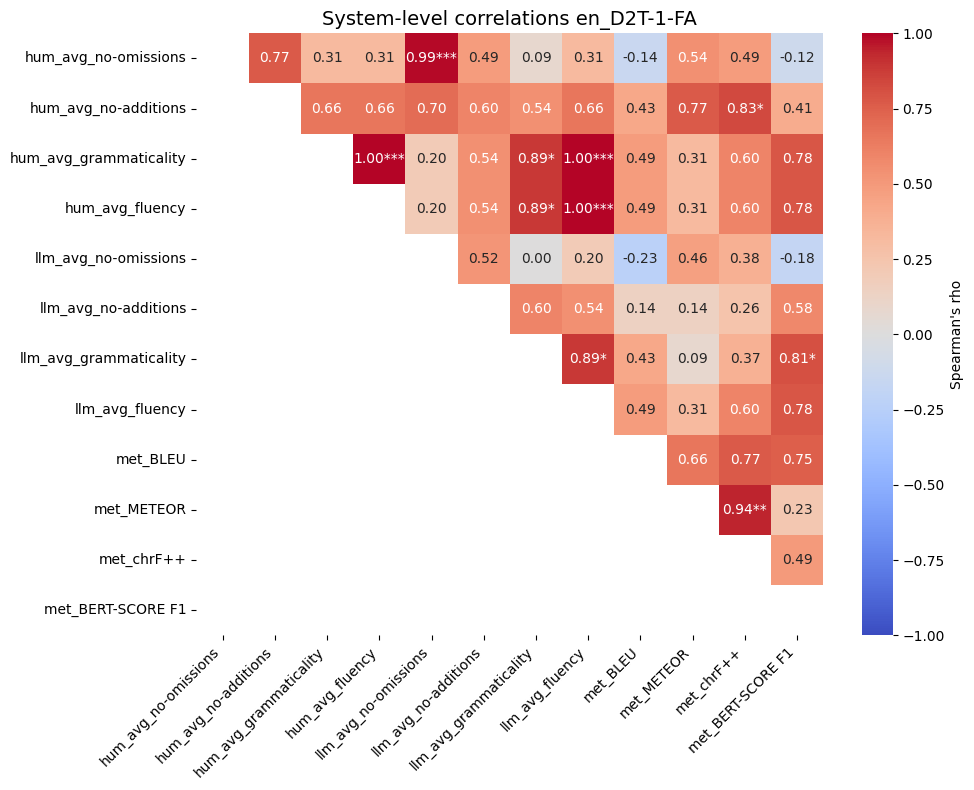

en_D2T-1-*
hum_avg_no-omissions hum_avg_no-additions
  [5.439866959442004, 4.594069146646, 5.475645827951435, 4.77159002841643, 5.722675019374839, 5.747610436579695]
  [5.380569189701197, 4.496493154223715, 5.4809351588736765, 4.638332041677431, 5.473803065530009, 5.503164556962026]
  0.942857142857143 - 0.004804664723032055
hum_avg_no-omissions hum_avg_grammaticality
  [5.439866959442004, 4.594069146646, 5.475645827951435, 4.77159002841643, 5.722675019374839, 5.747610436579695]
  [5.881314044605183, 5.295253164556962, 5.832129940583829, 5.211657194523379, 4.6916042366313615, 5.9617734435546375]
  0.3142857142857143 - 0.5440932944606414
hum_avg_no-omissions hum_avg_fluency
  [5.439866959442004, 4.594069146646, 5.475645827951435, 4.77159002841643, 5.722675019374839, 5.747610436579695]
  [5.817661241711875, 5.245154137604409, 5.731152587617326, 5.291259795057264, 4.811250322913976, 5.893012141565486]
  0.3714285714285715 - 0.46847813411078715
hum_avg_no-omissions llm_avg_no-omissions
  [

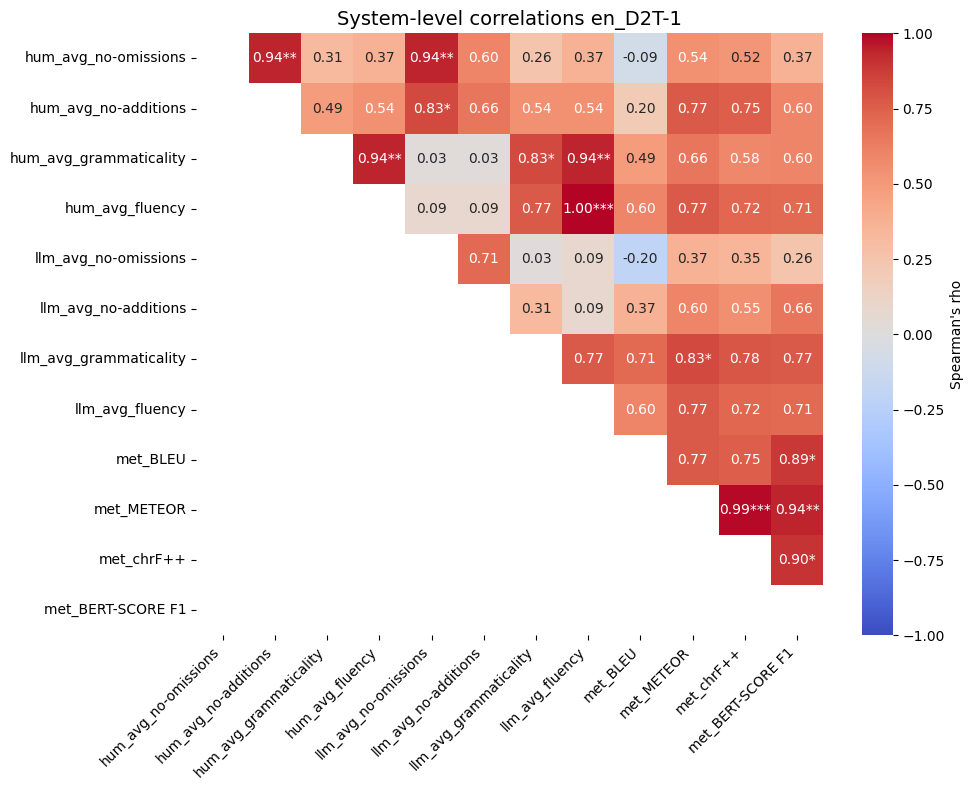

en_D2T-2-*
hum_avg_no-omissions hum_avg_no-additions
  [5.417364381650096, 4.343158032443747, 5.691701552415839, 4.6933586255014825, 5.415689865689866, 6.028785103785104]
  [5.239076399790686, 4.118785975928833, 5.717194313622886, 4.487868480725624, 4.998229548229548, 5.812973137973138]
  1.0 - 0.0
hum_avg_no-omissions hum_avg_grammaticality
  [5.417364381650096, 4.343158032443747, 5.691701552415839, 4.6933586255014825, 5.415689865689866, 6.028785103785104]
  [5.706924821210535, 4.8932016396302105, 5.872366125937554, 5.086616954474098, 4.183001918716204, 6.123438862724576]
  0.8285714285714287 - 0.04156268221574334
hum_avg_no-omissions hum_avg_fluency
  [5.417364381650096, 4.343158032443747, 5.691701552415839, 4.6933586255014825, 5.415689865689866, 6.028785103785104]
  [5.671995464852608, 4.887305948020233, 5.827206523635096, 5.159044130472702, 4.394208965637537, 6.062929530786675]
  0.8285714285714287 - 0.04156268221574334
hum_avg_no-omissions llm_avg_no-omissions
  [5.417364381650096

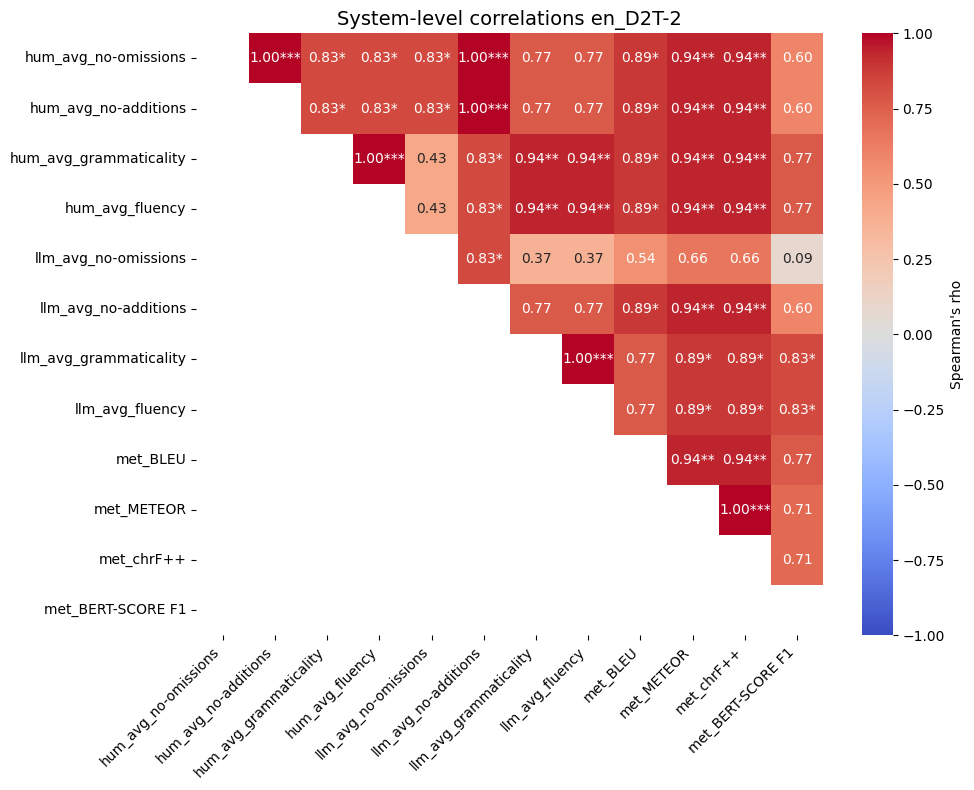

en_*-FA
hum_avg_no-omissions hum_avg_no-additions
  [5.478316326530612, 4.663265306122449, 5.626275510204081, 4.99234693877551, 5.600765306122449, 5.989795918367348]
  [5.520408163265307, 4.63265306122449, 5.821428571428571, 4.911989795918368, 5.274234693877551, 5.88265306122449]
  0.942857142857143 - 0.004804664723032055
hum_avg_no-omissions hum_avg_grammaticality
  [5.478316326530612, 4.663265306122449, 5.626275510204081, 4.99234693877551, 5.600765306122449, 5.989795918367348]
  [6.059948979591837, 5.2602040816326525, 6.065051020408163, 5.536989795918368, 4.316326530612245, 6.178571428571429]
  0.6571428571428573 - 0.15617492711370237
hum_avg_no-omissions hum_avg_fluency
  [5.478316326530612, 4.663265306122449, 5.626275510204081, 4.99234693877551, 5.600765306122449, 5.989795918367348]
  [5.983418367346939, 5.243622448979592, 5.974489795918368, 5.580357142857142, 4.520408163265307, 6.110969387755102]
  0.5428571428571429 - 0.26570262390670557
hum_avg_no-omissions llm_avg_no-omissions


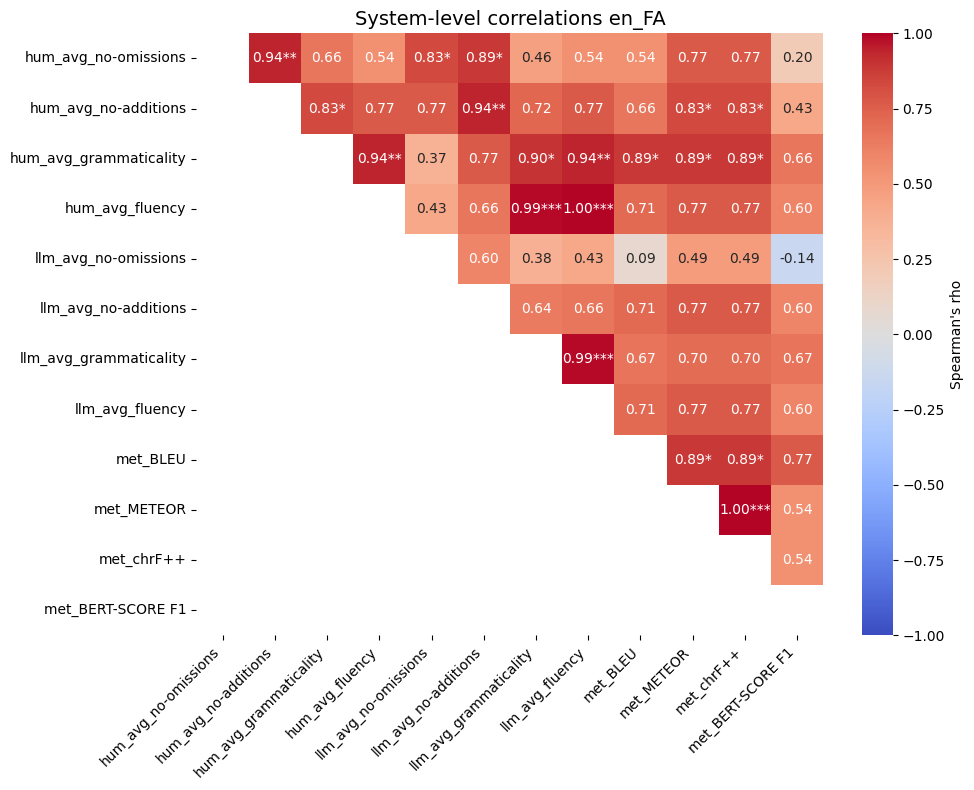

en_*-CFA
hum_avg_no-omissions hum_avg_no-additions
  [5.331403715332288, 4.362951334379906, 5.575817634746207, 4.739017530088958, 5.571238880167452, 5.723024594453166]
  [5.08693092621664, 4.055729984301413, 5.543903715332287, 4.49328231292517, 5.184844322344322, 5.33170460491889]
  0.942857142857143 - 0.004804664723032055
hum_avg_no-omissions hum_avg_grammaticality
  [5.331403715332288, 4.362951334379906, 5.575817634746207, 4.739017530088958, 5.571238880167452, 5.723024594453166]
  [5.673907639979069, 4.909955520669806, 5.81492673992674, 4.974313186813188, 4.380370225013082, 5.95429094714809]
  0.6571428571428573 - 0.15617492711370237
hum_avg_no-omissions hum_avg_fluency
  [5.331403715332288, 4.362951334379906, 5.575817634746207, 4.739017530088958, 5.571238880167452, 5.723024594453166]
  [5.61641156462585, 4.870499738356881, 5.739534275248561, 5.0612702773417055, 4.522435897435898, 5.878833071690215]
  0.6571428571428573 - 0.15617492711370237
hum_avg_no-omissions llm_avg_no-omissions


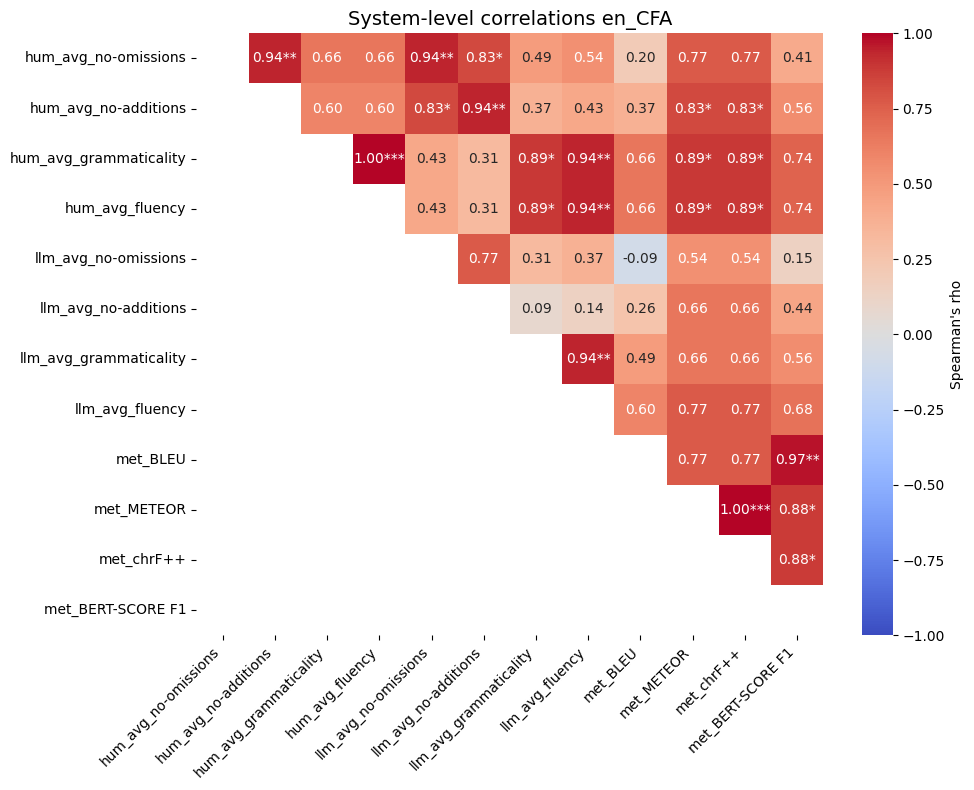

en_*-FI
hum_avg_no-omissions hum_avg_no-additions
  [5.476126969775252, 4.379624128132265, 5.54892792560062, 4.4660585120124, 5.535543141307156, 5.951772797726686]
  [5.322129294755877, 4.234535649702919, 5.431861921983984, 4.284028674761044, 5.248969904417463, 5.759848876259365]
  0.942857142857143 - 0.004804664723032055
hum_avg_no-omissions hum_avg_grammaticality
  [5.476126969775252, 4.379624128132265, 5.54892792560062, 4.4660585120124, 5.535543141307156, 5.951772797726686]
  [5.648501679152673, 5.1125226039783005, 5.676766339447172, 4.936108240764661, 4.615212477396022, 5.994956083699302]
  0.6 - 0.20799999999999982
hum_avg_no-omissions hum_avg_fluency
  [5.476126969775252, 4.379624128132265, 5.54892792560062, 4.4660585120124, 5.535543141307156, 5.951772797726686]
  [5.634655127873934, 5.084567941100492, 5.623514595711702, 5.0338284680960985, 4.765344872126065, 5.944110049082925]
  0.48571428571428577 - 0.3287230320699709
hum_avg_no-omissions llm_avg_no-omissions
  [5.4761269697752

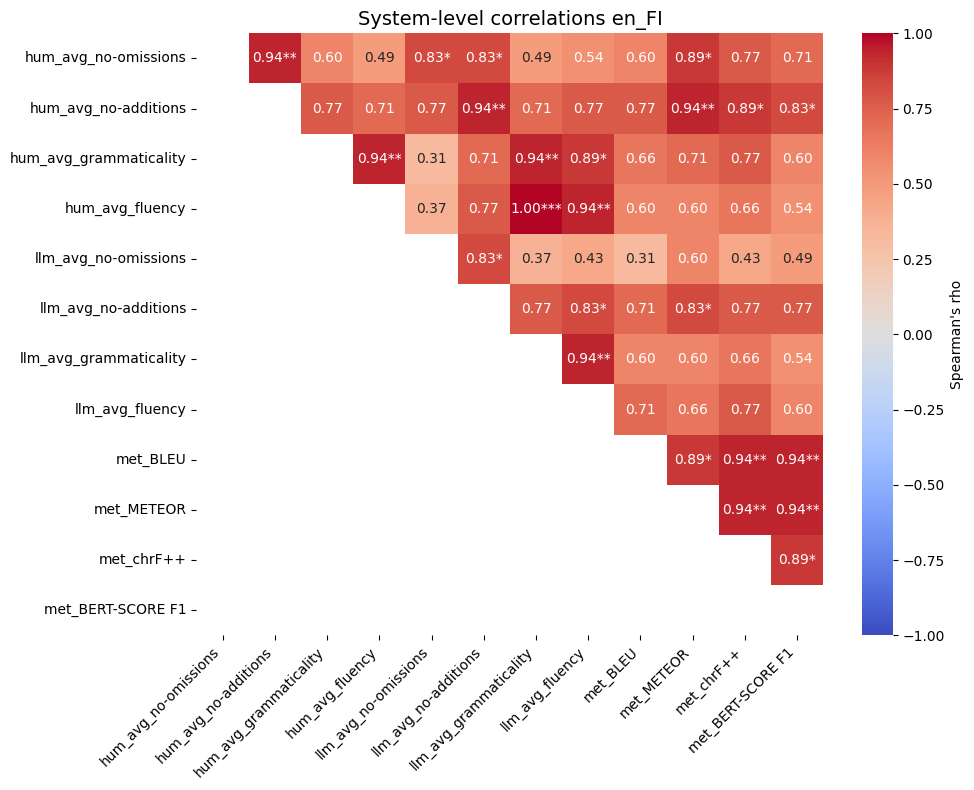

en_*-*
hum_avg_no-omissions hum_avg_no-additions
  [5.42861567054605, 4.468613589544874, 5.583673690183637, 4.732474326958957, 5.569182442532352, 5.888197770182399]
  [5.3098227947459415, 4.307639565076274, 5.59906473624828, 4.563100261201528, 5.236016306879779, 5.658068847467582]
  0.942857142857143 - 0.004804664723032055
hum_avg_no-omissions hum_avg_grammaticality
  [5.42861567054605, 4.468613589544874, 5.583673690183637, 4.732474326958957, 5.569182442532352, 5.888197770182399]
  [5.79411943290786, 5.094227402093586, 5.852248033260692, 5.149137074498738, 4.437303077673783, 6.042606153139606]
  0.6571428571428573 - 0.15617492711370237
hum_avg_no-omissions hum_avg_fluency
  [5.42861567054605, 4.468613589544874, 5.583673690183637, 4.732474326958957, 5.569182442532352, 5.888197770182399]
  [5.744828353282241, 5.066230042812321, 5.779179555626211, 5.225151962764983, 4.602729644275756, 5.97797083617608]
  0.6571428571428573 - 0.15617492711370237
hum_avg_no-omissions llm_avg_no-omissions
  

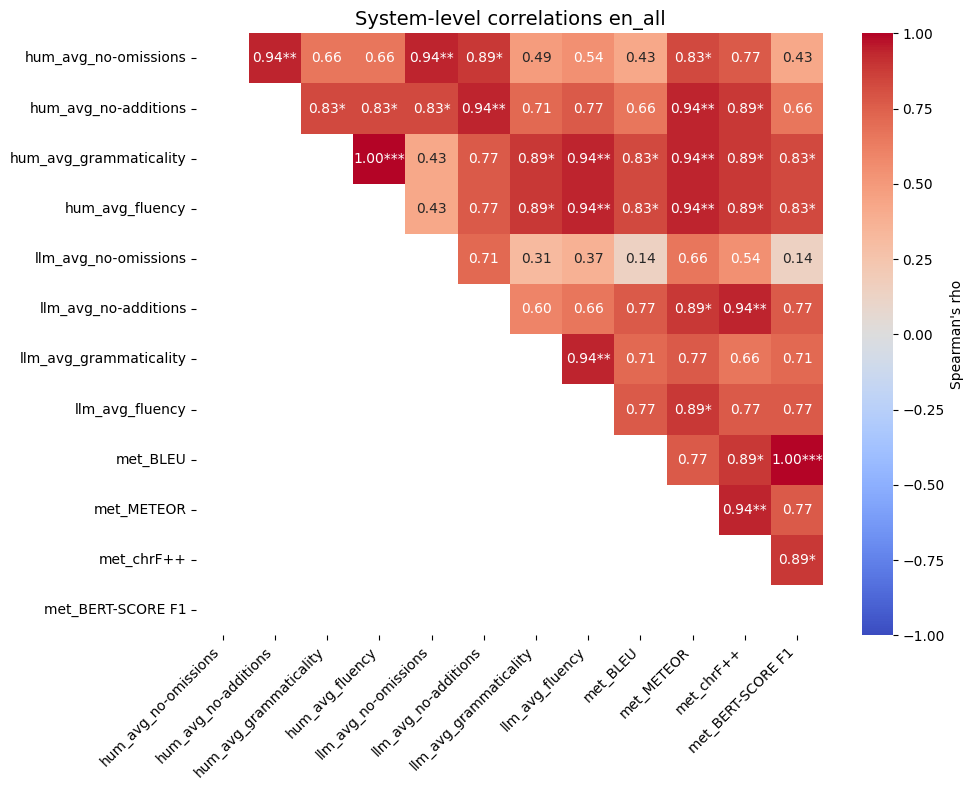

In [4]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Which systems to consider for groupings (actually keep all same systems for all groupings for comparability; so removed system 1 from the first two groups)
system_ID_datasets = {'en_D2T-1-FA': [2, 3, 4, 5, 6, 7],
                      'en_D2T-1-*': [2, 3, 4, 5, 6, 7],
                      'en_D2T-2-*':  [2, 3, 4, 5, 6, 7],
                      'en_*-FA':  [2, 3, 4, 5, 6, 7],
                      'en_*-CFA':  [2, 3, 4, 5, 6, 7],
                      'en_*-FI':  [2, 3, 4, 5, 6, 7],
                      'en_*-*':  [2, 3, 4, 5, 6, 7],
                      }

# Extract all single [ordered list of system scores] for which we will want Spearman, for instance the ordered list of all system scores for BLEU on 'en_D2T-1-FA
dico_sysLevel_correls = {'en_D2T-1-FA':{}, 'en_D2T-1-*':{}, 'en_D2T-2-*':{}, 'en_*-FA':{}, 'en_*-CFA':{}, 'en_*-FI':{}, 'en_*-*':{}}

def extractListsSystemScores(csv_file, eval_type, dico_sysLevel_correls):
  # Lists of column headers to extract numbers from
  QCmetrics_list = []
  if eval_type == 'hum' or eval_type == 'llm':
    QCmetrics_list = ["avg_no-omissions", "avg_no-additions", "avg_grammaticality", "avg_fluency"]
  elif eval_type == 'met':
    QCmetrics_list = ["BLEU", "METEOR", "chrF++", "BERT-SCORE F1"]
  # Load CSV as pandas dataframe
  df_allScores = pd.read_csv(csv_file)
  # print(df_allScores)
  # Group all rows that have language=en and task='D2T-1-FA'
  for full_dataset_ID in dico_sysLevel_correls.keys():
    # print(full_dataset_ID)
    language = full_dataset_ID.split('_')[0]
    dataset_ID = full_dataset_ID.split('_')[1]
    # Important: sort rows by system so they are always in the same order
    df_dataset = df_allScores[(df_allScores['language'] == language) & (df_allScores['task'] == dataset_ID)].sort_values(by=['system'])
    # Filter out rows of systems for which the full_dataset_ID is not present in system_ID_datasets[system]
    df_dataset = df_dataset[df_dataset['system'].isin(system_ID_datasets[full_dataset_ID])]
    # print(df_dataset)
    for QCmetric in QCmetrics_list:
      # Print only value of the QCmetric column in df_dataset
      full_QCmetric_name = eval_type+'_'+QCmetric
      list_scores = df_dataset[QCmetric].tolist()
      # print(f'  {full_QCmetric_name} {list_scores}')
      dico_sysLevel_correls[full_dataset_ID][full_QCmetric_name] = list_scores
  return dico_sysLevel_correls

csv_file_all_humans = '/content/content/csv_sysLevel_scores/sysLevel_scores_Humans_allScores.csv'
csv_file_all_llms = '/content/content/csv_sysLevel_scores/sysLevel_scores_avgLLM_allScores.csv'
csv_file_all_metrics = '/content/content/csv_sysLevel_scores/sysLevel_scores_metrics_allScores.csv'

dico_sysLevel_correls = extractListsSystemScores(csv_file_all_humans, 'hum', dico_sysLevel_correls)
dico_sysLevel_correls = extractListsSystemScores(csv_file_all_llms, 'llm', dico_sysLevel_correls)
dico_sysLevel_correls = extractListsSystemScores(csv_file_all_metrics, 'met', dico_sysLevel_correls)

for dataset_correl in dico_sysLevel_correls:
  print(dataset_correl)
  results = []
  keys = list(dico_sysLevel_correls[dataset_correl].keys())
  rho_matrix = pd.DataFrame(index=keys, columns=keys, dtype=float)
  pval_matrix = pd.DataFrame(index=keys, columns=keys, dtype=float)
  for k1, k2 in itertools.combinations(keys, 2):
    print(k1, k2)
    print(f'  {dico_sysLevel_correls[dataset_correl][k1]}')
    print(f'  {dico_sysLevel_correls[dataset_correl][k2]}')
    rho, pval, _ , _ = getSpearmanKendall(dico_sysLevel_correls[dataset_correl][k1], dico_sysLevel_correls[dataset_correl][k2])
    print(f'  {rho} - {pval}')
    rho_matrix.loc[k1, k2] = rho
    pval_matrix.loc[k1, k2] = pval
    results.append({
        "Var1": k1,
        "Var2": k2,
        "Spearman_rho": rho,
        "p_value": pval
    })
  # Put results in a nice DataFrame
  # df_results = pd.DataFrame(results)
  # Display neatly
  # print(df_results)
  # print("Spearman's rho matrix:")
  # print(rho_matrix)

  # plt.figure(figsize=(10, 8))
  # sns.heatmap(rho_matrix.astype(float),
  #             annot=True, fmt=".2f", cmap="coolwarm",
  #             cbar_kws={'label': "Spearman's rho"})
  # plt.title("Spearman Correlation Heatmap", fontsize=14)
  # plt.xticks(rotation=45, ha="right")
  # plt.yticks(rotation=0)
  # plt.tight_layout()
  # plt.show()

  annot = rho_matrix.copy().astype(str)

  label_heatmap = dataset_correl.replace('*-*', 'all').replace('*-', '').replace('-*', '')
  for i in rho_matrix.index:
    for j in rho_matrix.columns:
      rho = rho_matrix.loc[i, j]
      p = pval_matrix.loc[i, j]
      stars = ""
      if p < 0.001:
        stars = "***"
      elif p < 0.01:
        stars = "**"
      elif p < 0.05:
        stars = "*"
      annot.loc[i, j] = f"{rho:.2f}{stars}"

  # Plot heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(rho_matrix.astype(float),
              annot=annot.values, fmt="", cmap="coolwarm",
              cbar_kws={'label': "Spearman's rho"},
              xticklabels=rho_matrix.columns,
              yticklabels=rho_matrix.index,
              vmin=-1, vmax=1)

  plt.title(f"System-level correlations {label_heatmap}", fontsize=14)
  plt.xticks(rotation=45, ha="right")
  plt.yticks(rotation=0)
  plt.tight_layout()

  # Save figure as PNG
  plt.savefig("spearman_heatmap_"+label_heatmap+".png", dpi=300, bbox_inches='tight')  # high resolution

  # Display the plot
  plt.show()